In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')

ImportError: No module named 'seaborn'

## Models WIthout MSA Encoding

### Import, Split, and Standardize Data

In [170]:
df = pd.read_pickle('../data/merged/all_data_2006_to_2016.pkl')

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 11 columns):
year                                                                           928 non-null int64
MSA                                                                            928 non-null object
now_married_except_separated                                                   928 non-null float64
less_than_high_school_diploma                                                  928 non-null float64
unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months    928 non-null float64
households_with_food_stamp_snap_benefits                                       928 non-null float64
percentage_married_couple_family                                               928 non-null float64
percentage_female_householder_no_husband_present_family                        928 non-null float64
poverty_all_people                                                             928 non-null float6

In [172]:
# drop MSA names
df = df.drop('MSA', axis=1)

In [173]:
# separate labels and features

label_col = 'murder_per_100_k'

x = df.drop([label_col], axis=1)
y = df[label_col]

print('Sizes match: {}'.format(len(x)==len(y)))

Sizes match: True


In [174]:
# train test split

from sklearn.model_selection import train_test_split

x_train_s, x_test_s, y_train, y_test = train_test_split(x,y, test_size=0.3)

print('Len x_train: {}'.format(len(x_train_s)))
print('Len x_test: {}'.format(len(x_test_s)))
print('Len y_train: {}'.format(len(y_train)))
print('Len x_test: {}'.format(len(y_test)))

Len x_train: 649
Len x_test: 279
Len y_train: 649
Len x_test: 279


In [175]:
# standardize data

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler().fit(x_train_s)

x_train = standardizer.transform(x_train_s)
x_test = standardizer.transform(x_test_s)

### EDA

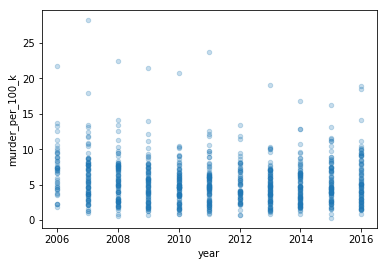

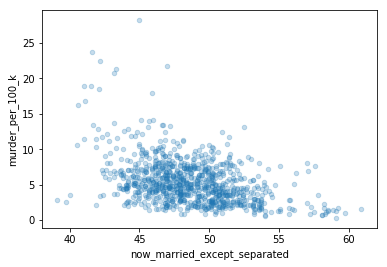

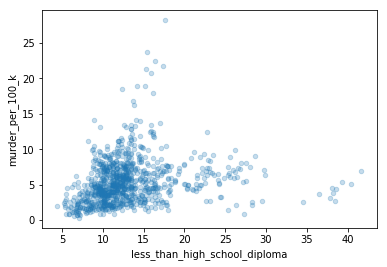

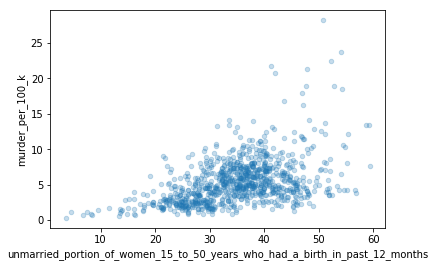

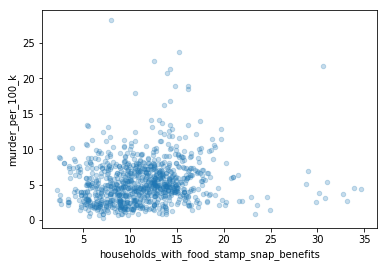

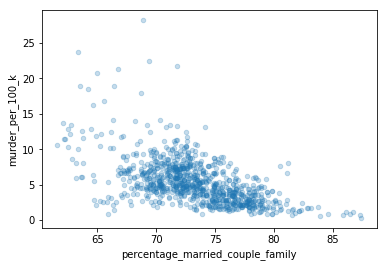

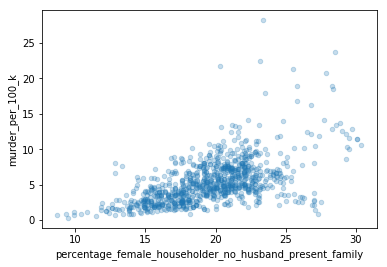

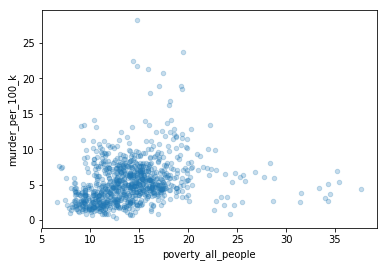

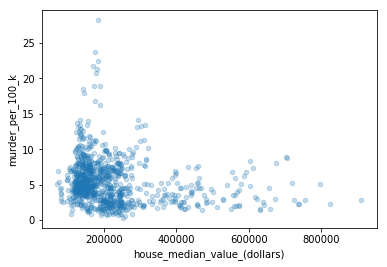

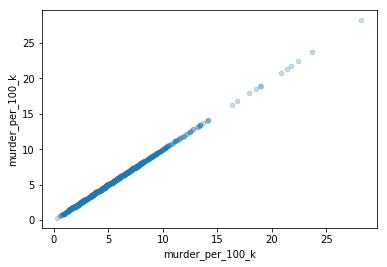

In [83]:
for col in df.columns:
    
    plt.figure(figsize=(20,10));
    #sns.lmplot(x=df[col],y=df[label_col],data=df,fit_reg=True) 
    df.plot.scatter(col,label_col, alpha=0.25);

### Simple Linear Regression

In [167]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [184]:
# instantiate and fit models

def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=15).fit(x_train, y_train)
    md['lasso'] = LassoCV(cv=15).fit(x_train, y_train)
    md['bayes'] = BayesianRidge(tol=0.0001).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}).fit(x_train, y_train).best_estimator_
    md['ffdnn'] = MLPRegressor(hidden_layer_sizes=(9*9,9*9,9*9)).fit(x_train, y_train)
    
    return md

In [146]:
# score models

def score_model(model, x_train, y_train, x_test, y_test):

    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)

    return np.array([train_score, test_score])

In [186]:
def results_df(model, x_train, y_train, x_test, y_test):

    # get train and test scores
    scores_df = pd.DataFrame(score_model(model, x_train, y_train, x_test, y_test)).transpose()
    scores_df.columns = ['Train R2','Test R2']

    # get coefficient matrix
    if hasattr(model, 'coef_'):
        coeffs_df = pd.DataFrame(model.coef_).transpose()
        coeffs_df.columns = df.drop(label_col, axis=1).columns
    else:
        coeffs_df = pd.DataFrame(np.zeros(2))
        
    # join dataframes
    return pd.concat([scores_df, coeffs_df], axis=1)

In [12]:
from sklearn.utils import resample

In [178]:
def run_experiment(n_iters, x_train, y_train, x_test, y_test):
    
    sample_results = dict()
    
    for n in range(n_iters):
        # get new sample
        xb, yb = resample(x_train, y_train)

        # make and fit models
        model_dict = make_models(xb, yb)

        # get sample of results for each model
        for key in model_dict:
            
            # initialize empty dictionary
            if key not in sample_results:
                sample_results[key] = []
                        
            # get model results
            sample_results[key].append(results_df(model_dict[key], x_train, y_train, x_test, y_test))
            
    # concatenate results dfs into single df
    for key in sample_results:
        sample_results[key] = pd.concat(sample_results[key])
        
    return sample_results

In [179]:
def get_coefdata(experiment):
    exp = experiment
    
    coef_dict = dict()

    # iterate over all models
    for key in exp:

        # iterate over results of this model
        for c in exp[key].columns:

            # initialize dict for result names
            if c not in coef_dict:
                coef_dict[c] = dict()

            # add this coeff to the dict
            coef_dict[c][key] = exp[key][c]

    # convert dict of dicts into dict of dataframes
    coef_dfs = {key: pd.DataFrame(coef_dict[key]) for key in coef_dict}
    
    return coef_dfs

In [180]:
# violin plots of the experimental results

def violin_coefs(experiment):

    coef_dfs = get_coefdata(experiment)
    
    for key in coef_dfs:

        plt.figure(figsize=(20,10))
        plt.violinplot(coef_dfs[key].transpose())

        # center everything on 0 but allow scale adjustment
        lim = np.abs(coef_dfs[key].values).max()*1.2
        plt.ylim((-lim,lim))

        x_labels = list(coef_dfs[key].columns)
        plt.xticks(range(len(x_labels)+1), ['']+x_labels, rotation='vertical')
        plt.axhline(c='y')
        plt.title(key);

In [187]:
exp = run_experiment(20, x_train, y_train, x_test, y_test)

In [188]:
violin_coefs(exp)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

### MSA-encoded Models Data Prep

In [122]:
df_2 = pd.read_pickle('../data/merged/all_data_2006_to_2016.pkl')

In [123]:
# OHE MSA names
df_2_dummies = pd.get_dummies(df_2['MSA'])

In [124]:
# drop MSA names
df_2 = df_2.drop('MSA', axis=1)

In [125]:
# combine dataframes, preserving list of columns that need normalization
cols_to_norm = df_2.columns[:-1]
df_2 = pd.concat([df_2, df_2_dummies], axis=1)

In [126]:
# separate labels and features

label_col = 'murder_per_100_k'

x_2 = df_2.drop([label_col], axis=1)
y_2 = df_2[label_col]

print('Sizes match: {}'.format(len(x)==len(y)))

Sizes match: True


In [127]:
# train test split

from sklearn.model_selection import train_test_split

x_train_s_2, x_test_s_2, y_train_2, y_test_2 = train_test_split(x_2,y_2, test_size=0.3)

print('Len x_train: {}'.format(len(x_train_s)))
print('Len x_test: {}'.format(len(x_test_s)))
print('Len y_train: {}'.format(len(y_train)))
print('Len x_test: {}'.format(len(y_test)))

Len x_train: 649
Len x_test: 279
Len y_train: 649
Len x_test: 279


In [132]:
# standardize data
means = np.mean(x_train_s_2, axis=0)
stds = np.std(x_train_s_2, axis=0)

# initialize training containers
x_train_2 = x_train_s_2
x_test_2 = x_test_s_2

# standardize relevant data, will throw a warning
for i,c in enumerate(cols_to_norm):
    x_train_2[c] = (x_train_s_2[c]-means[i])/stds[i]
    x_test_2[c] = (x_test_s_2[c]-means[i])/stds[i]

/Users/David/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/David/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Running MSA-Encoded Models

In [155]:
exp_2 = run_experiment(10, x_train_2, y_train_2, x_test_2, y_test_2)

/Users/David/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


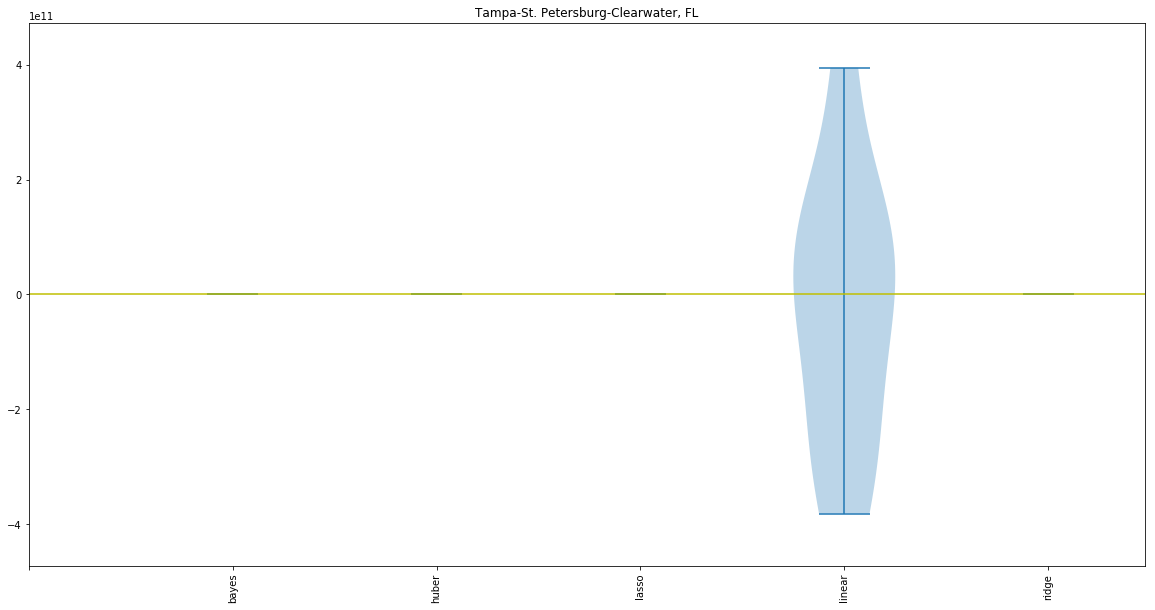

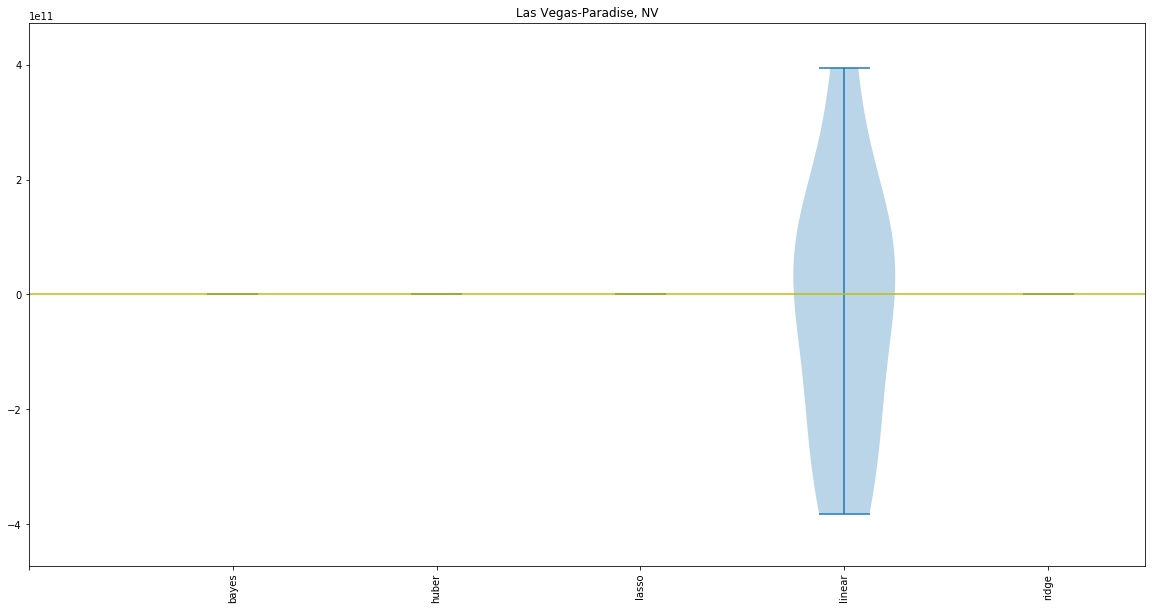

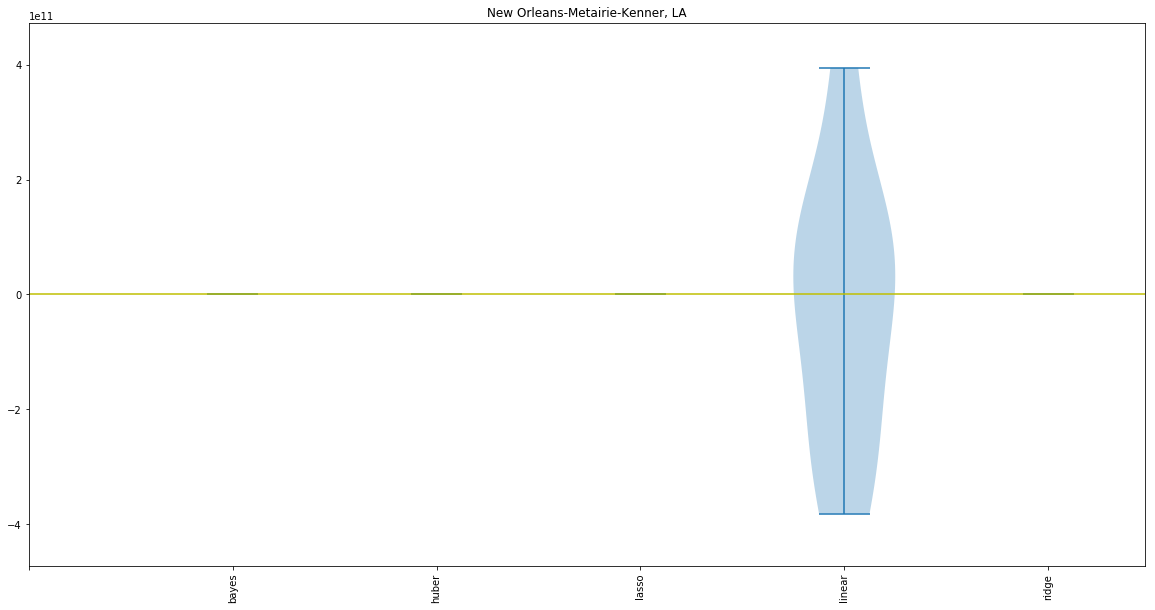

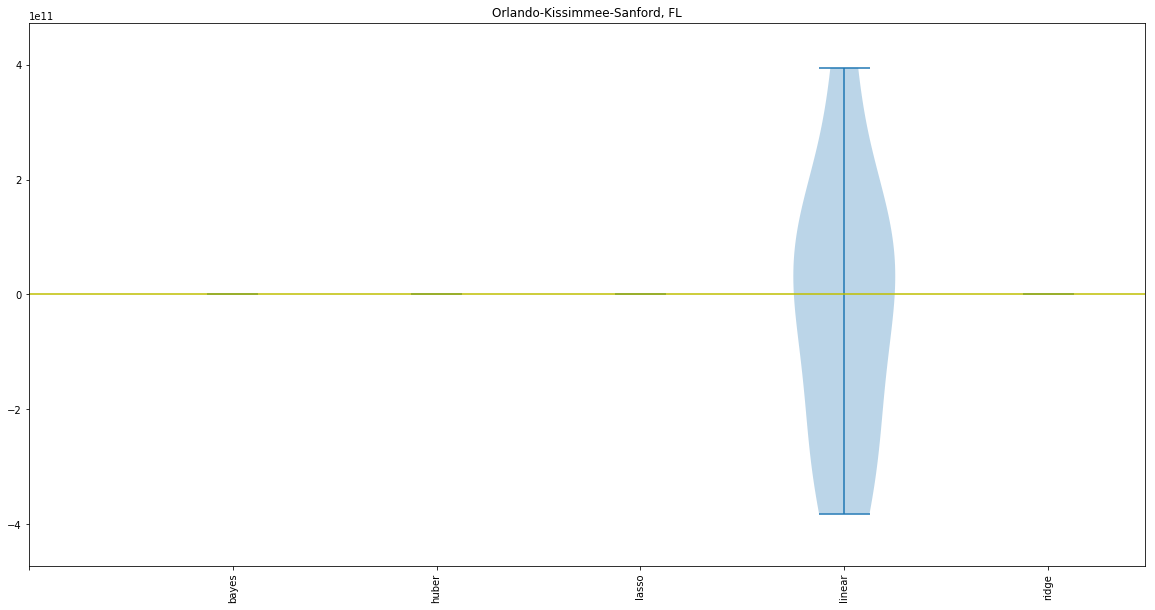

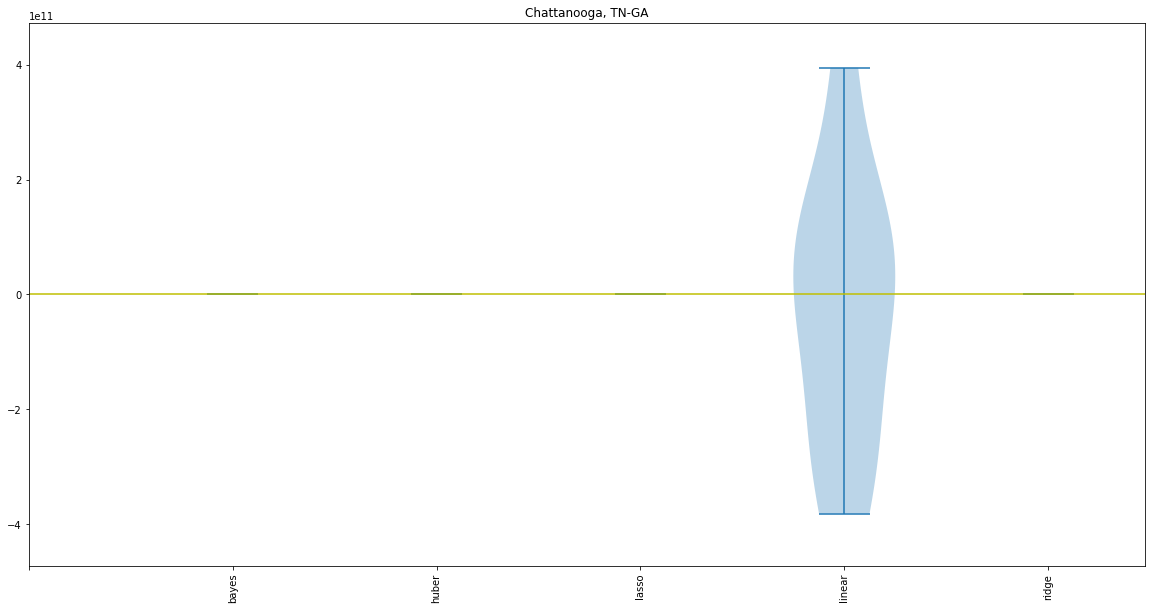

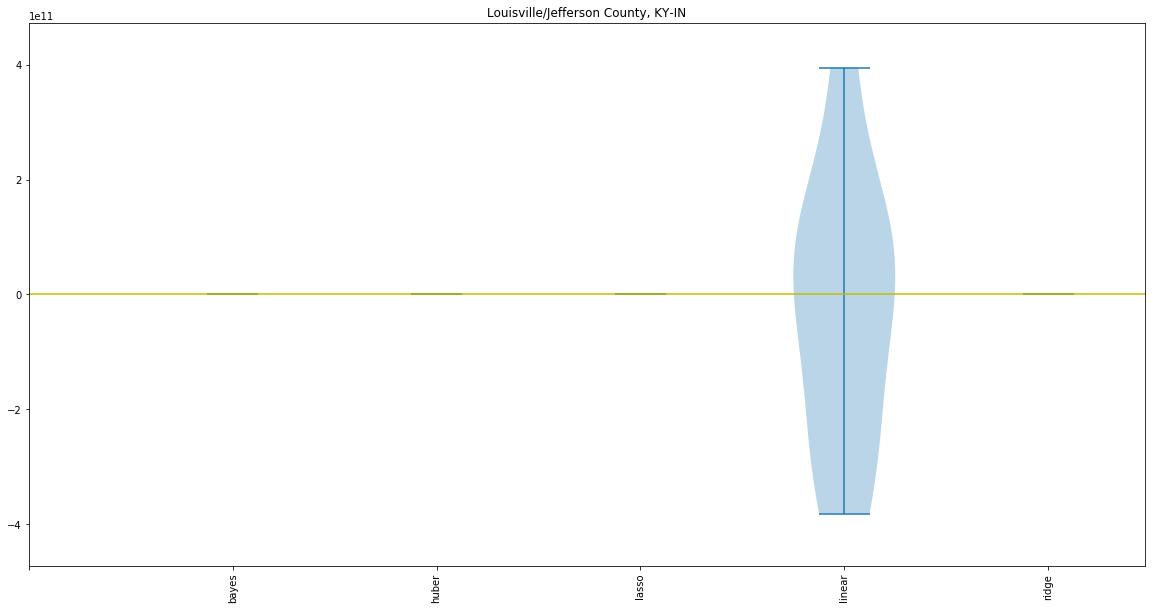

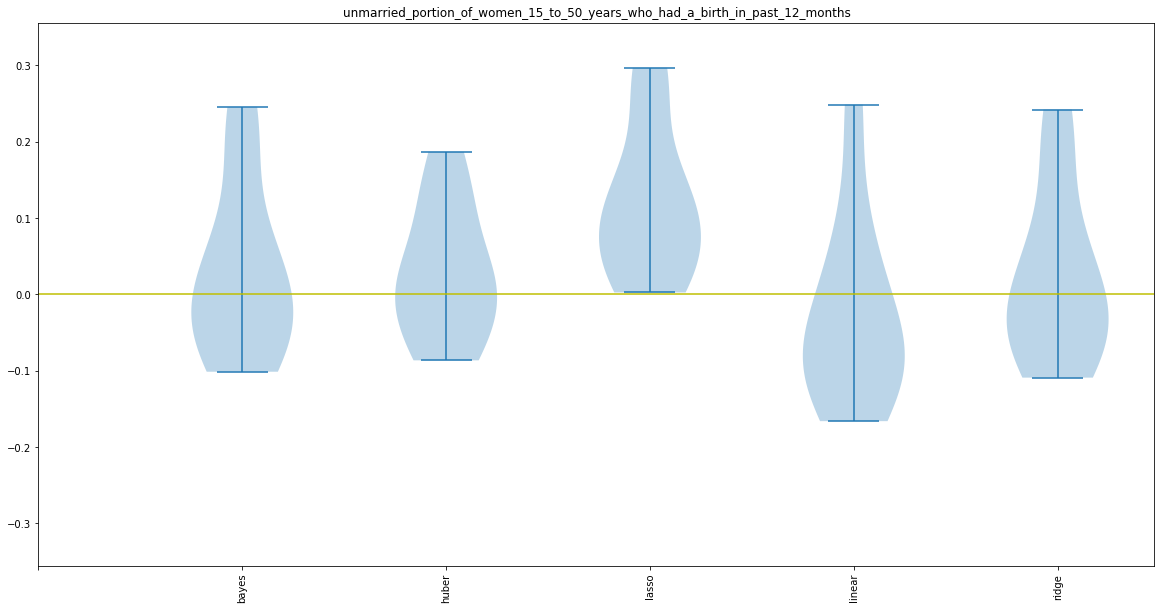

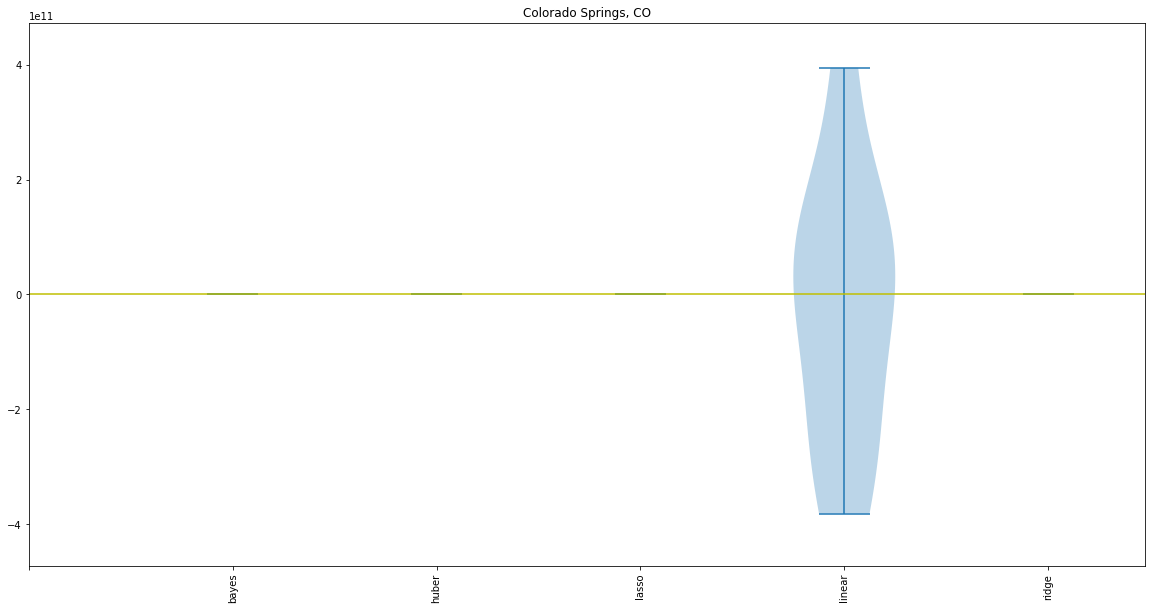

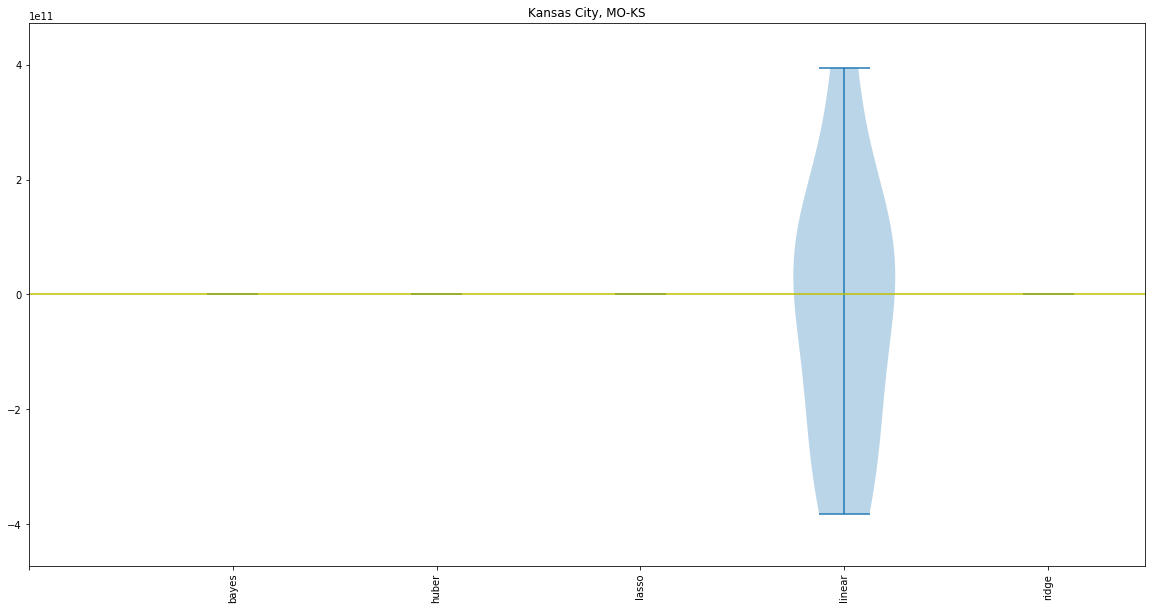

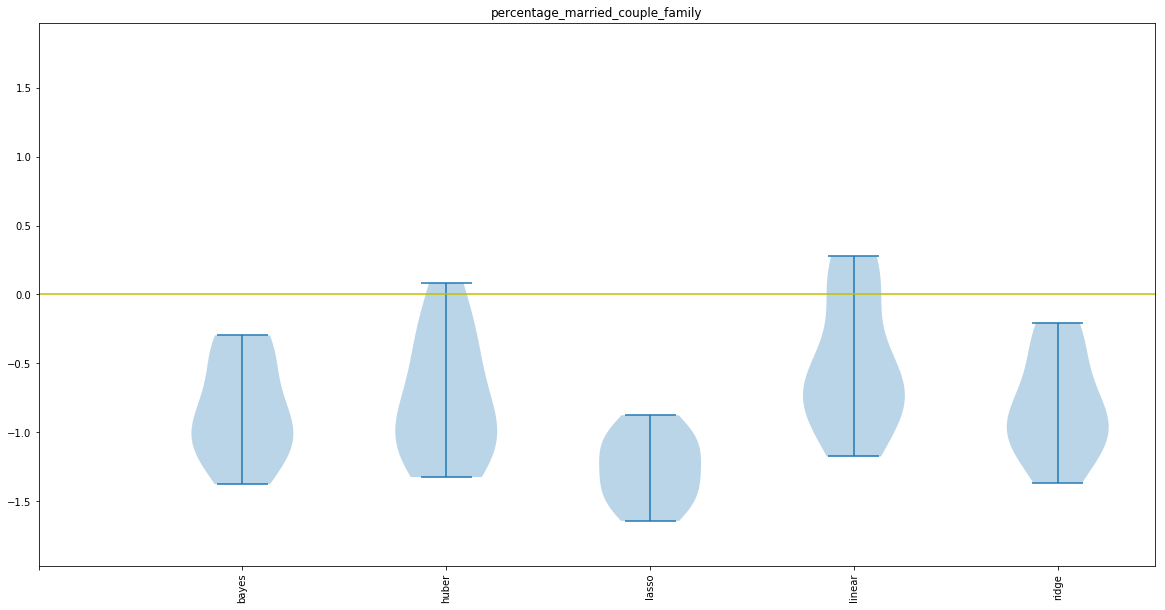

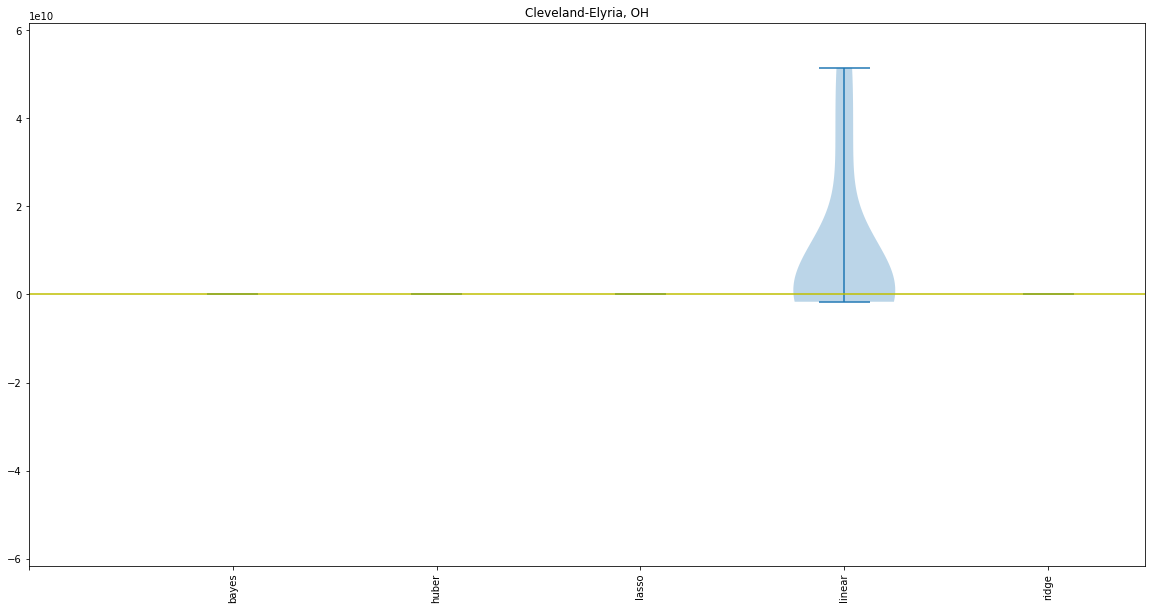

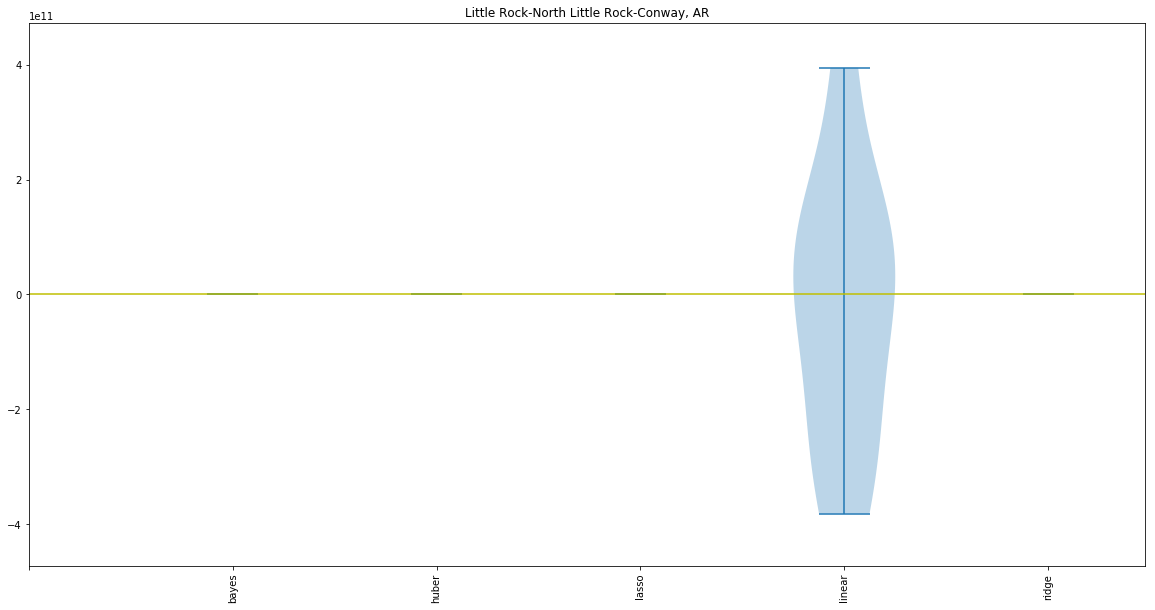

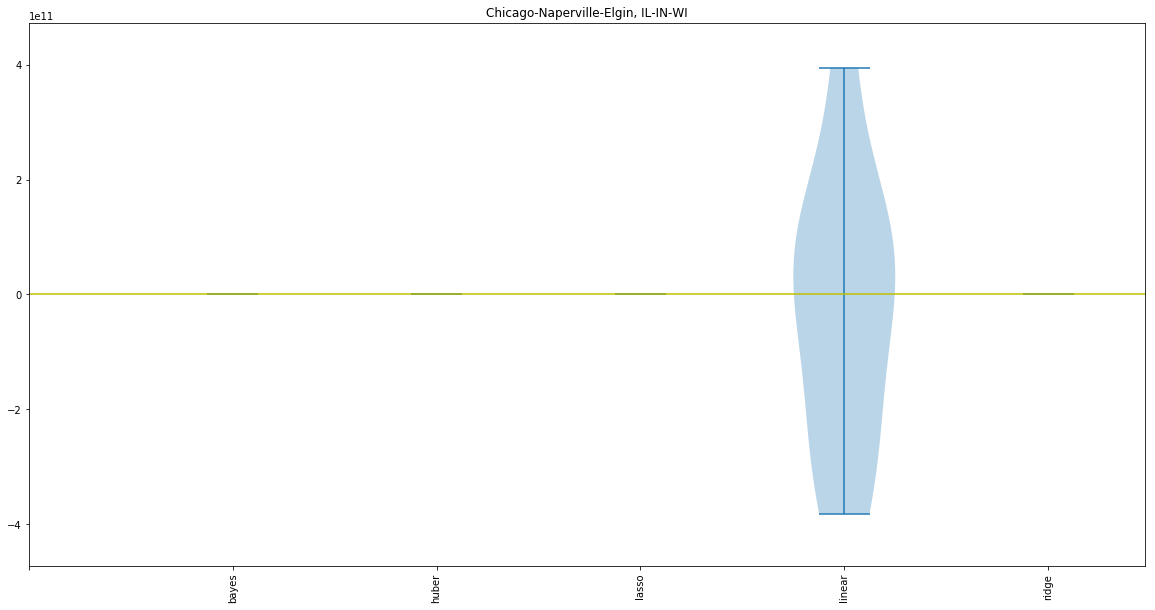

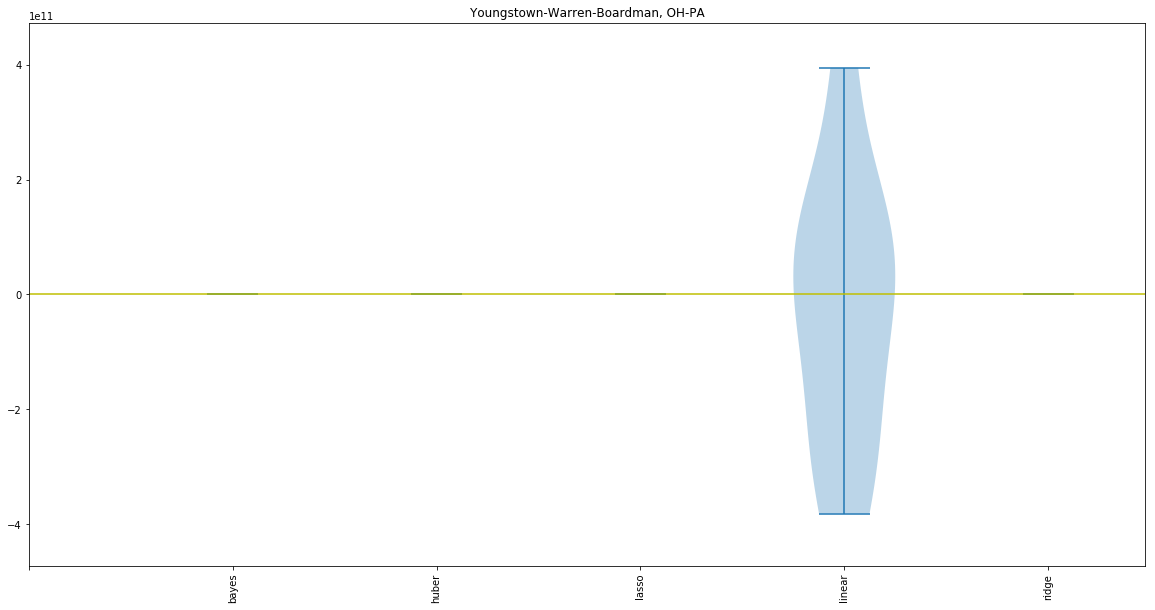

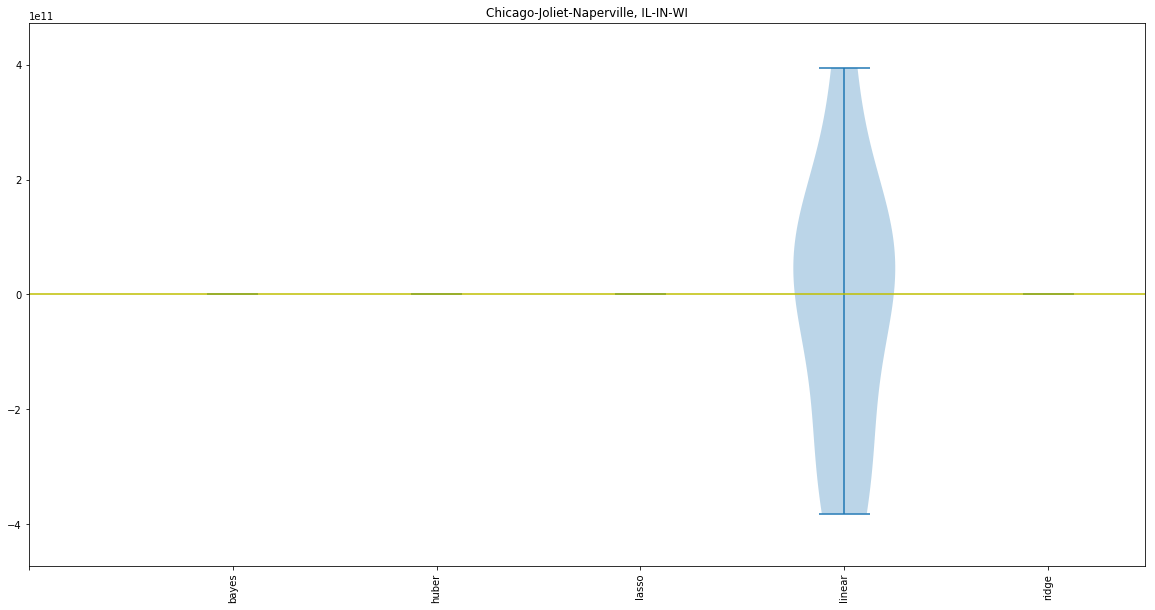

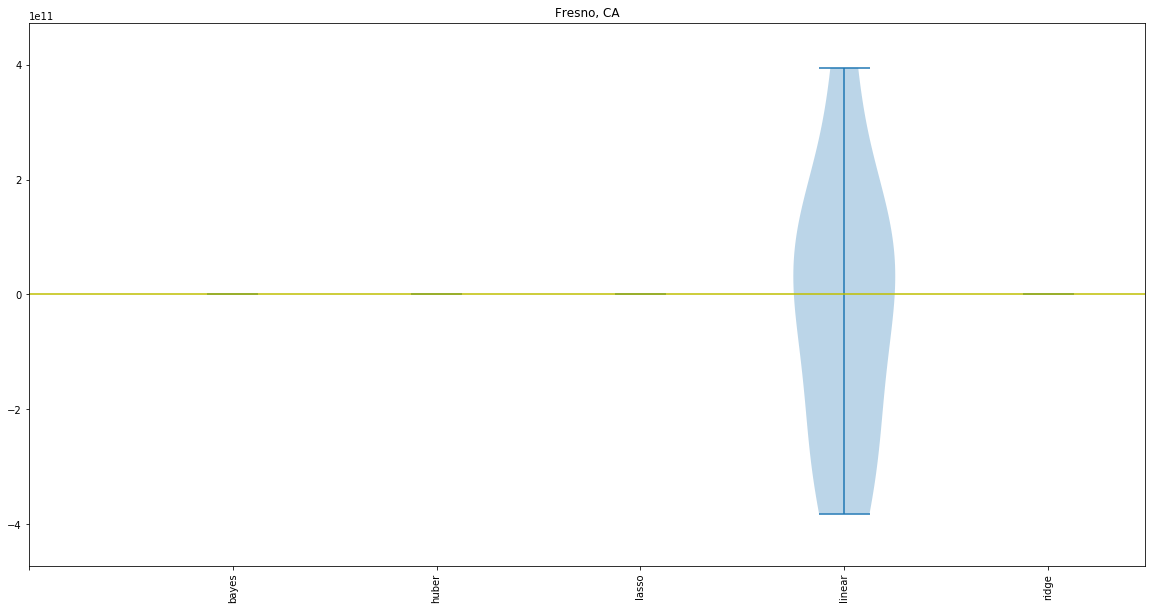

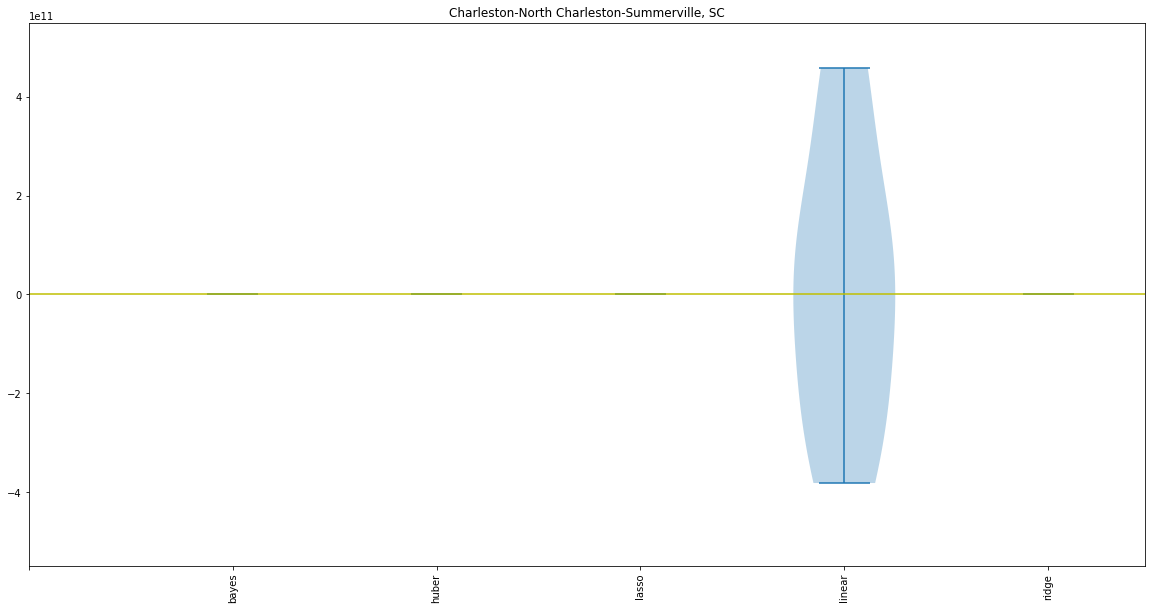

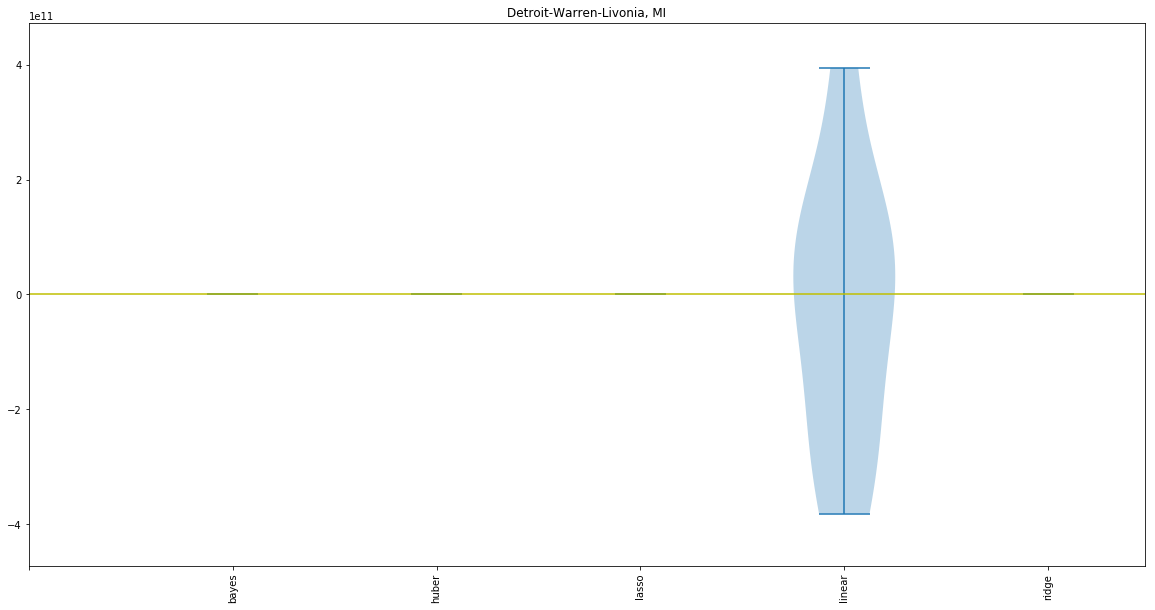

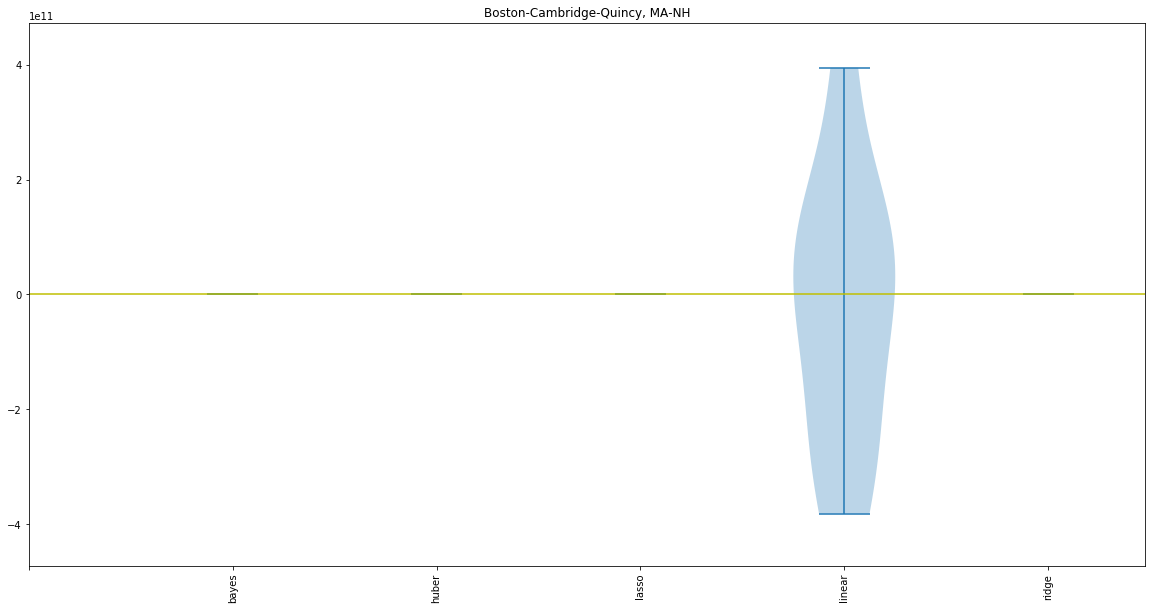

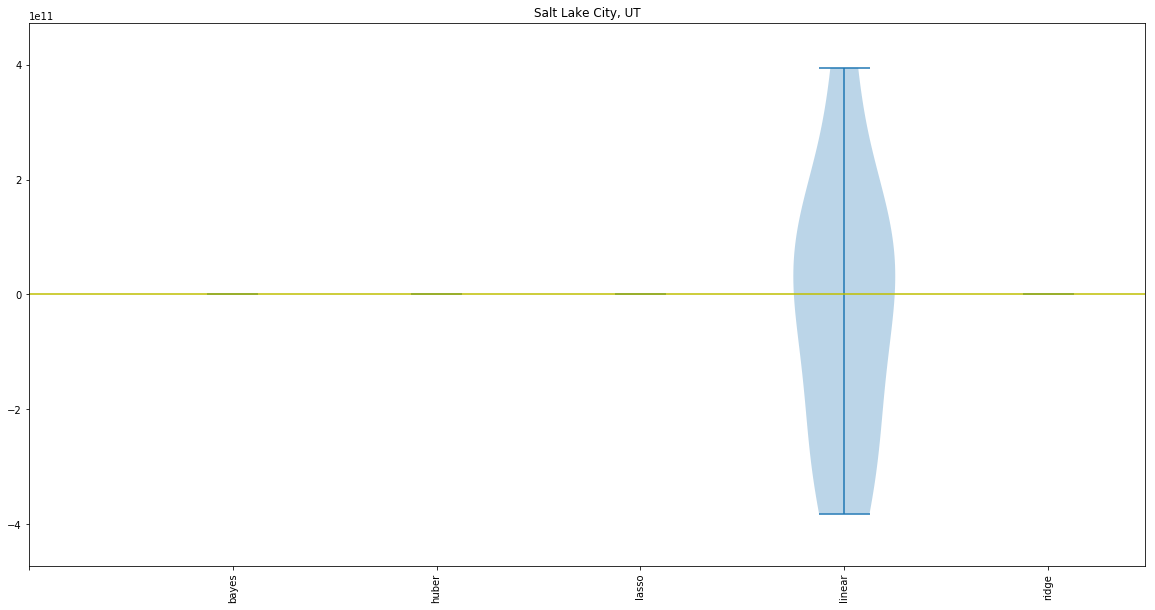

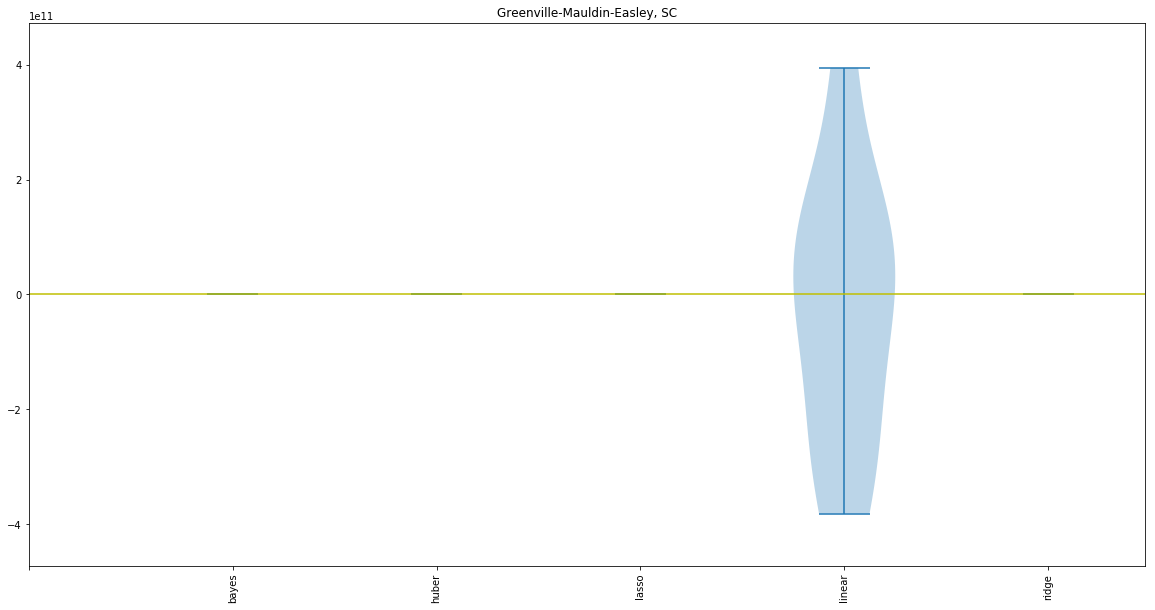

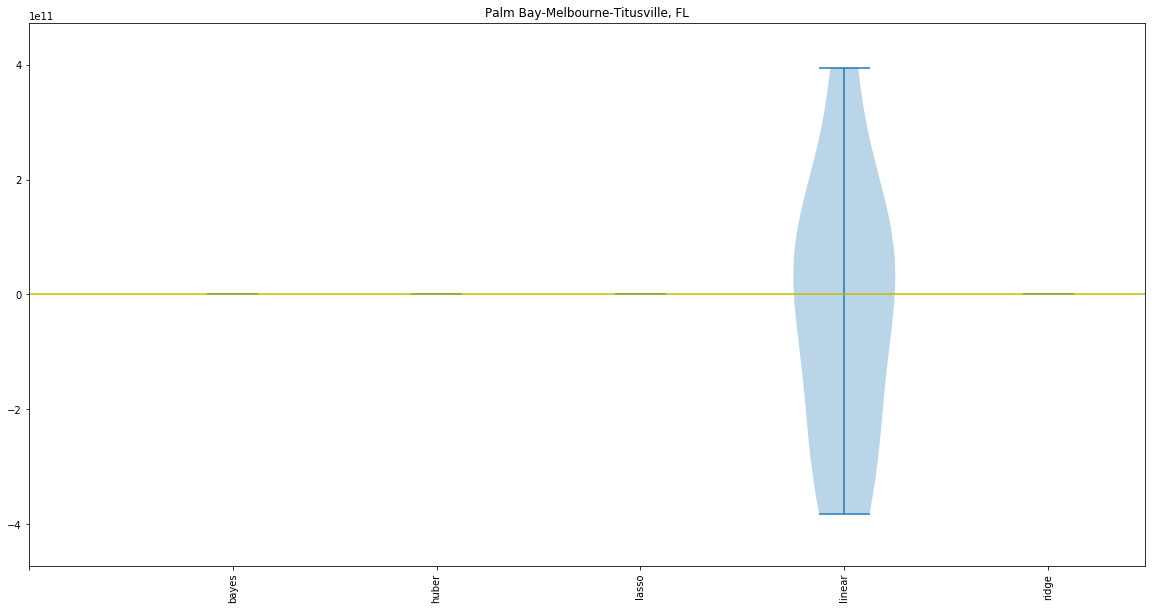

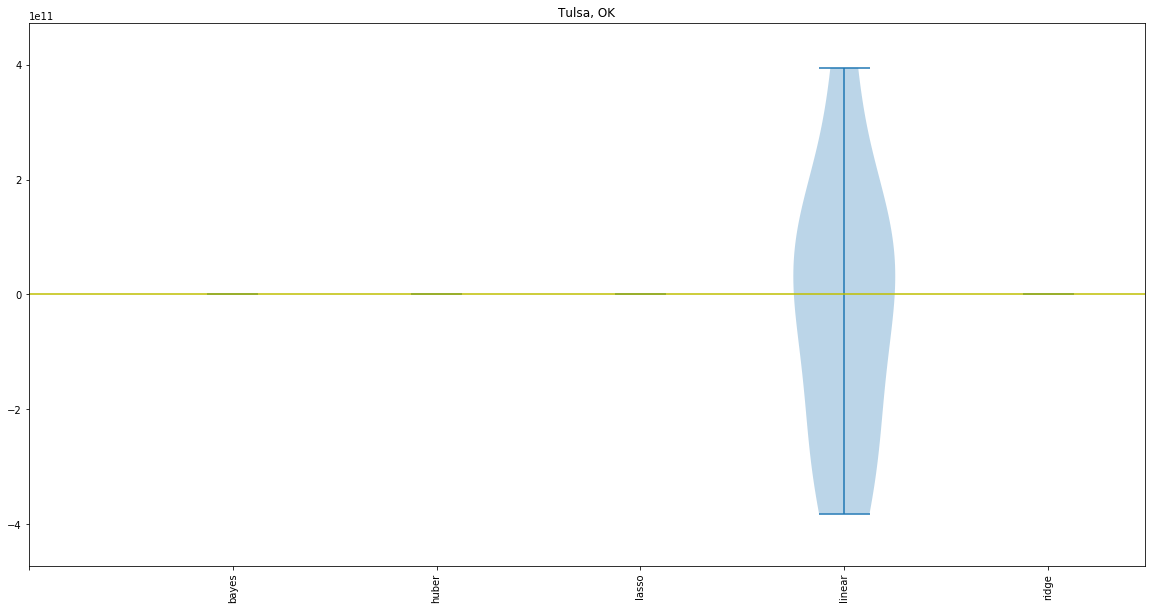

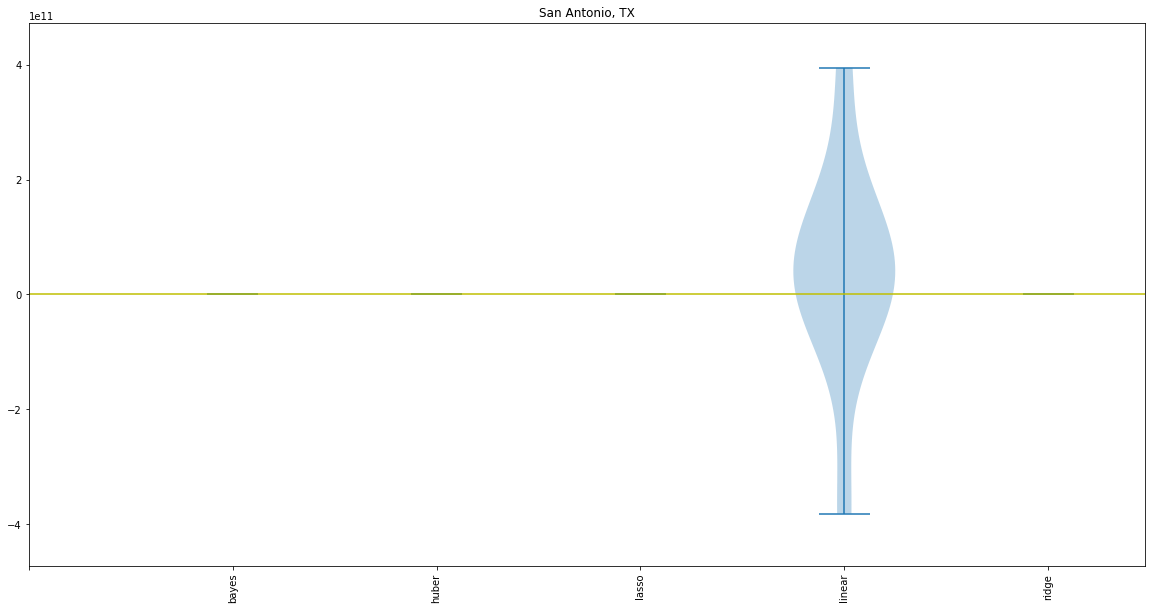

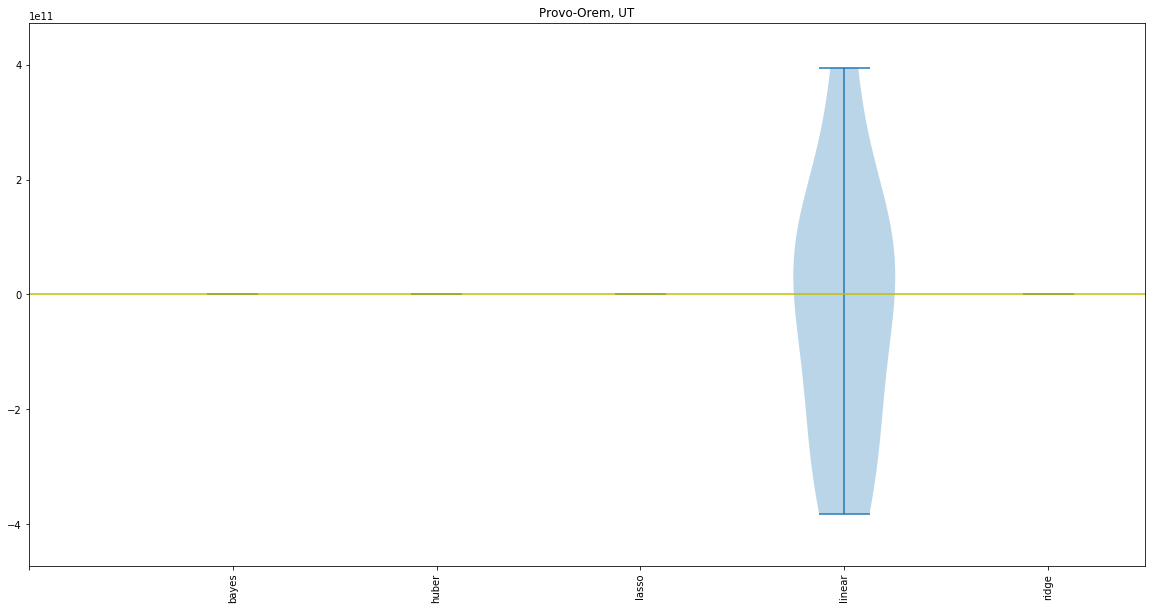

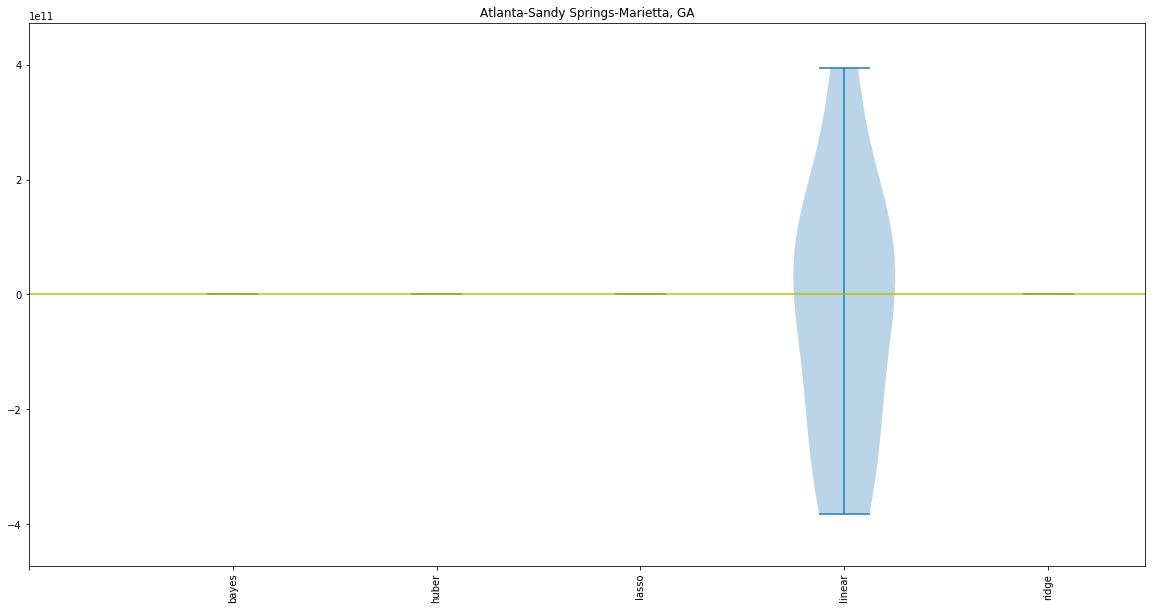

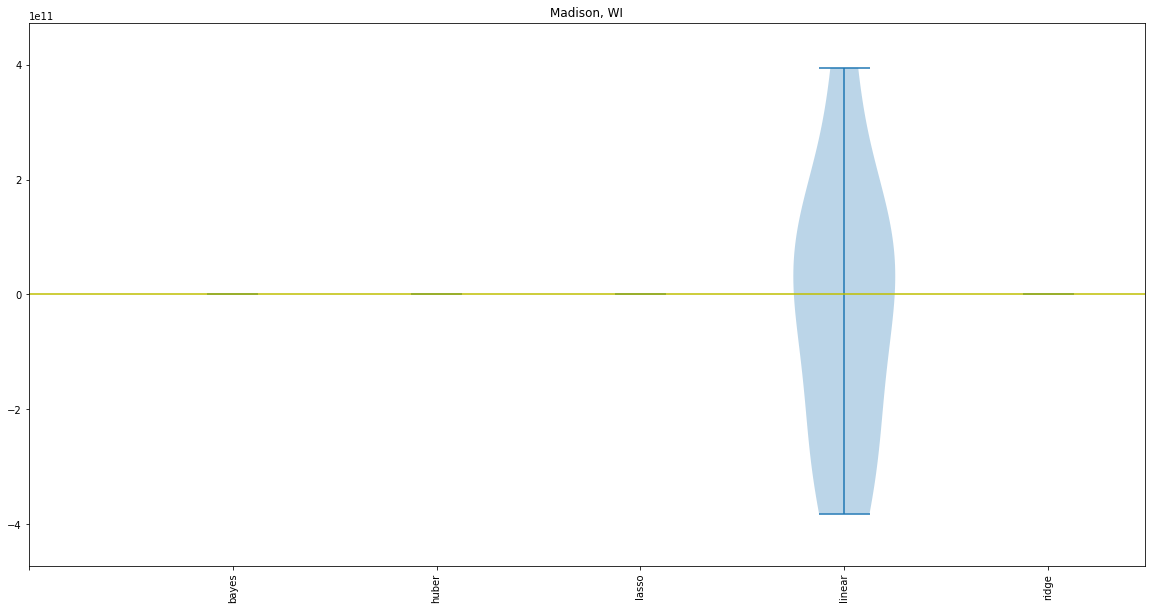

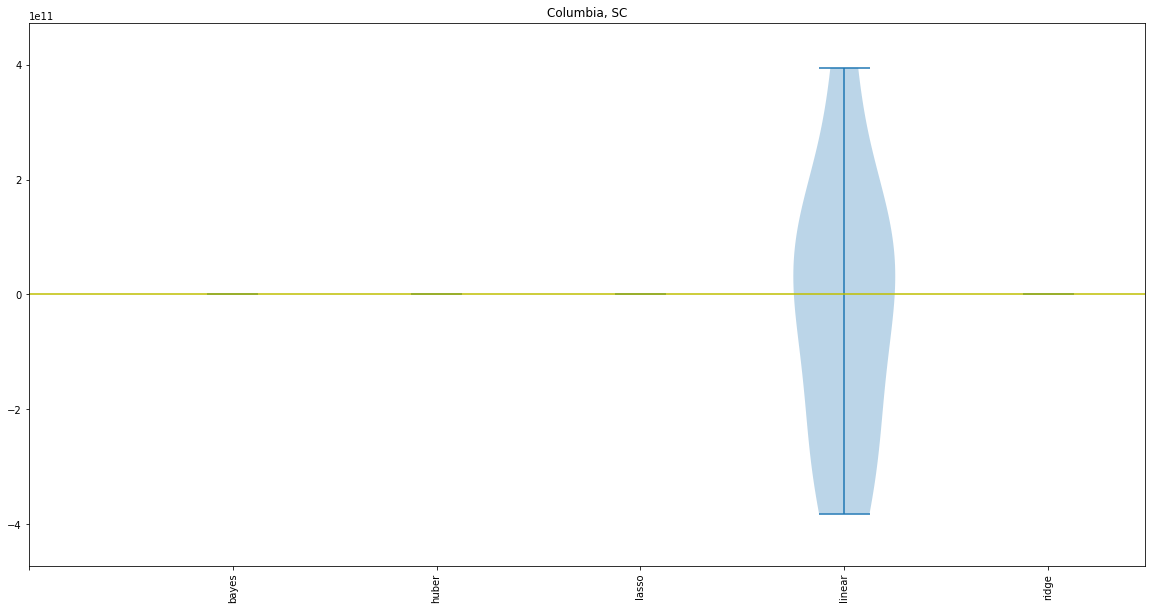

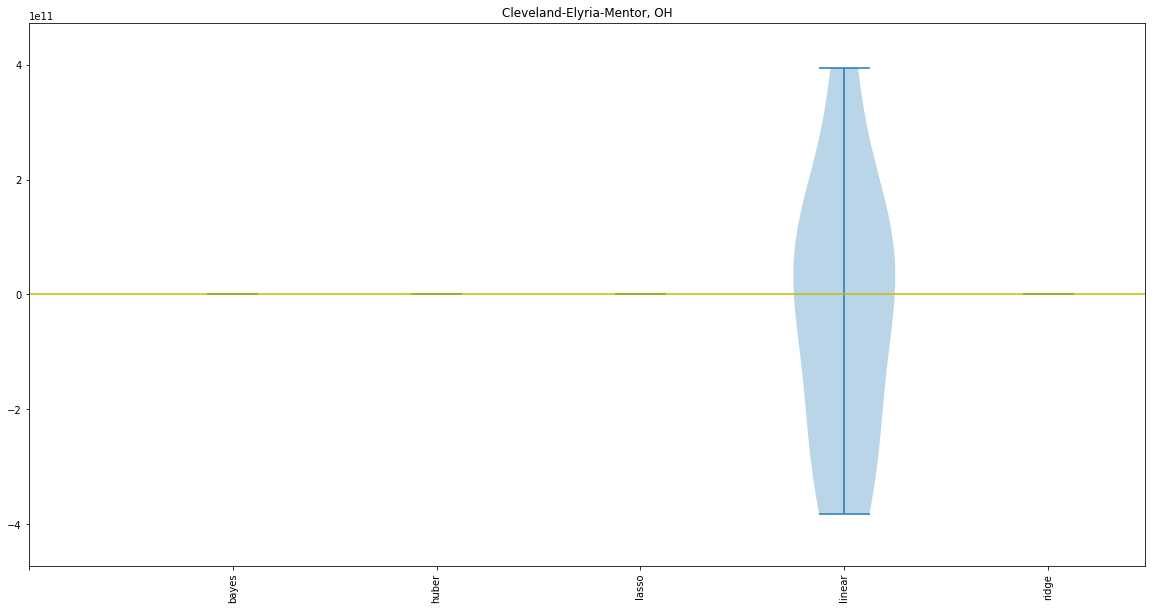

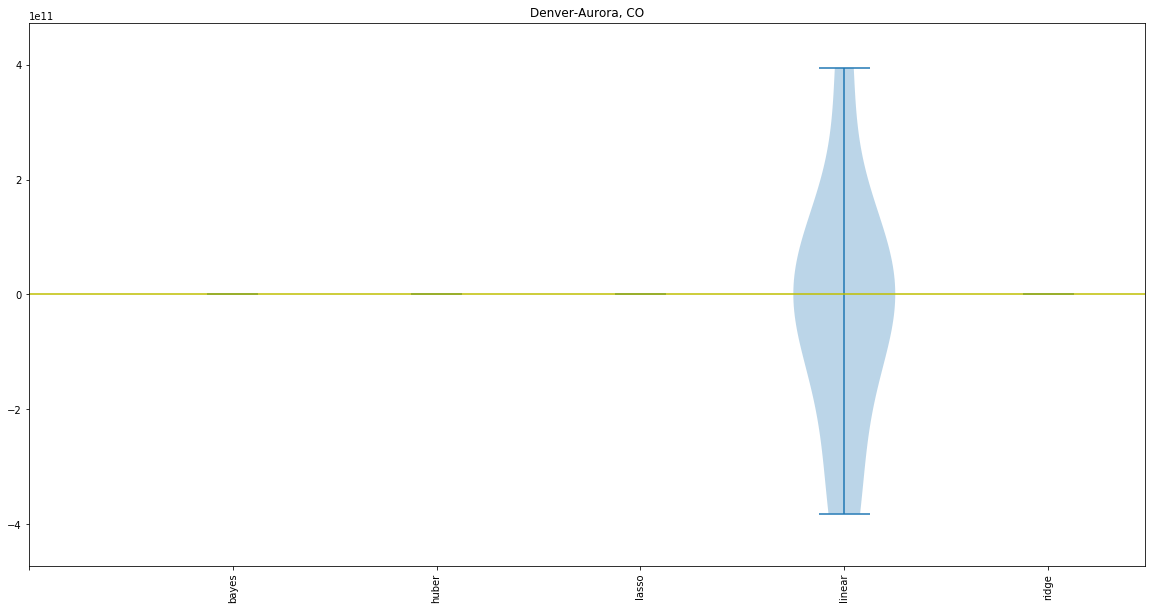

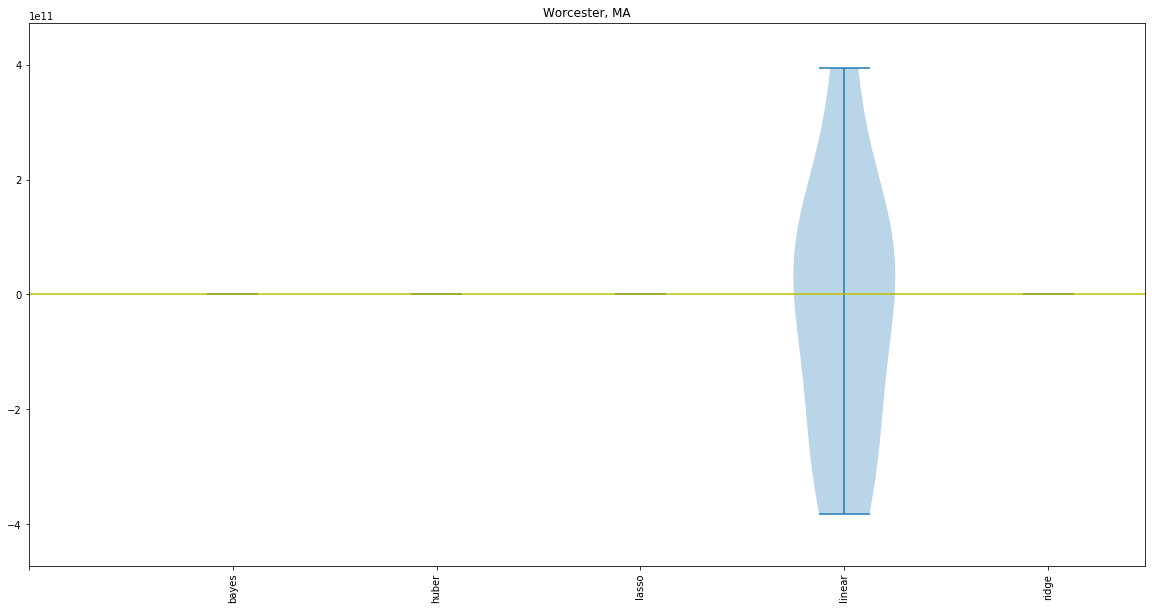

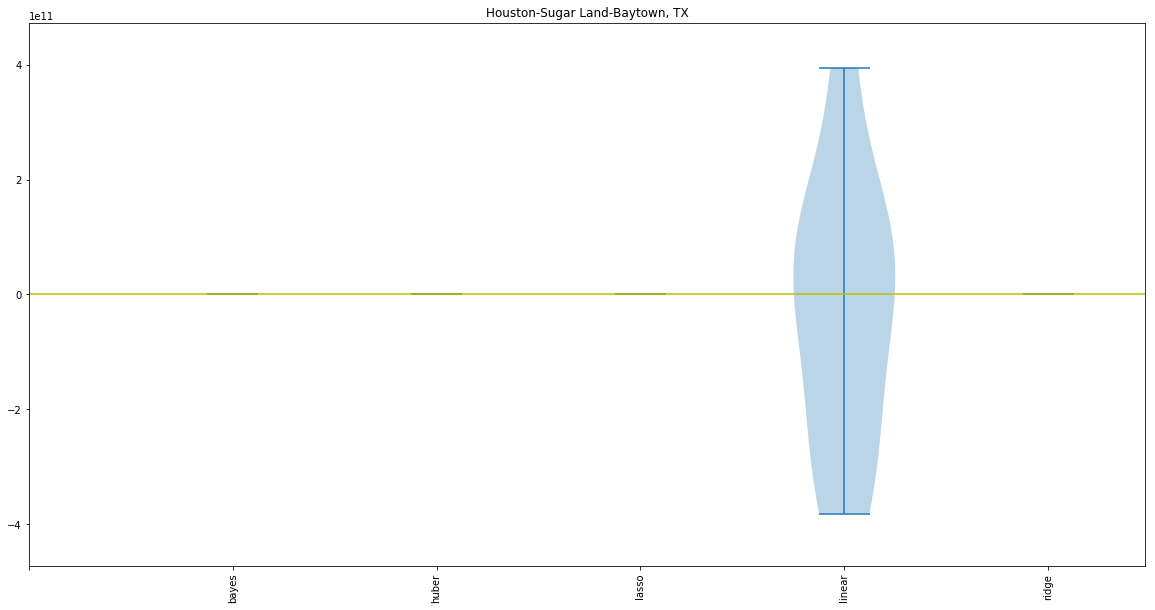

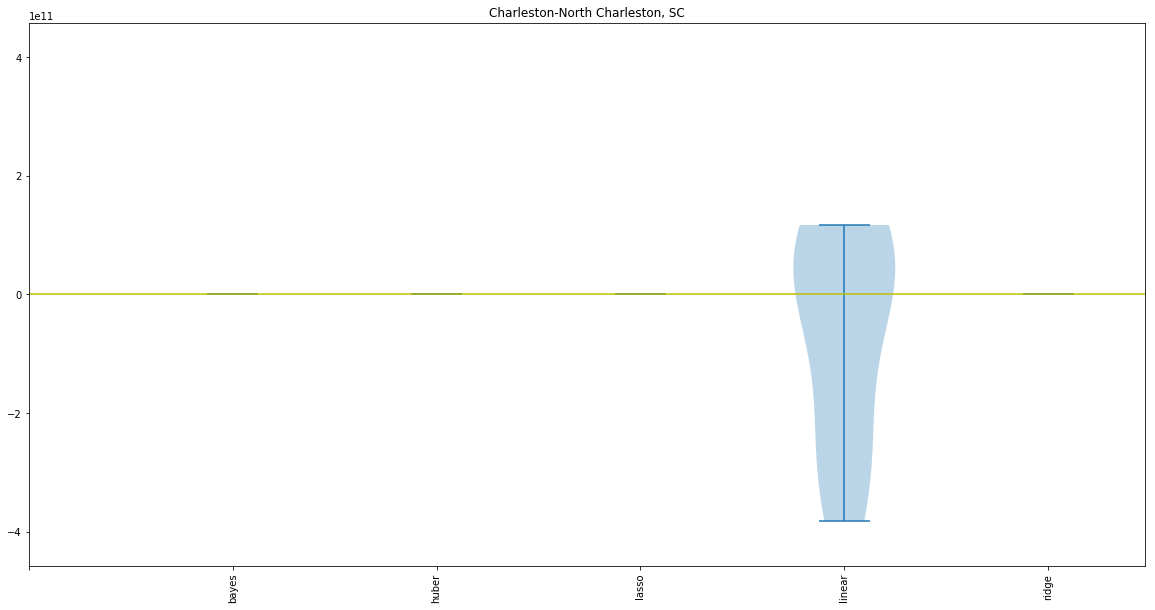

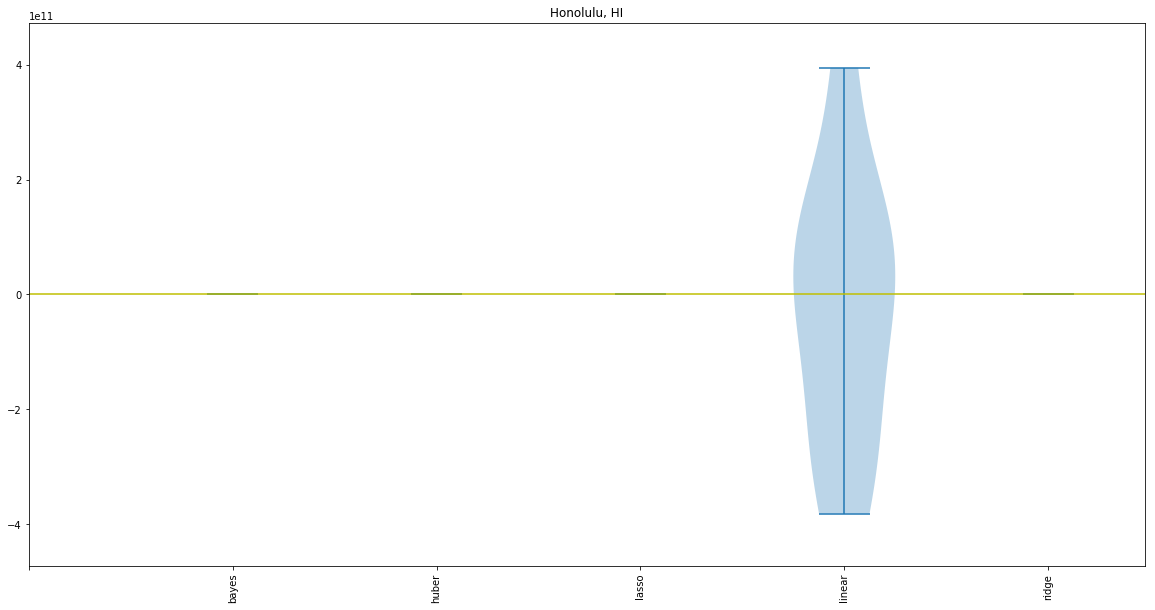

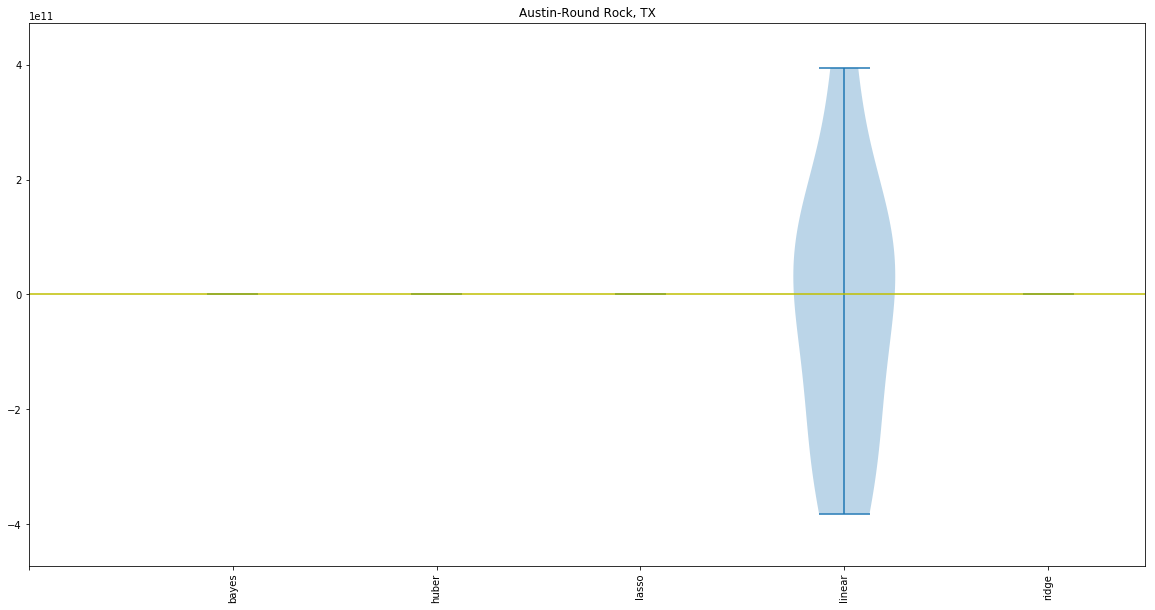

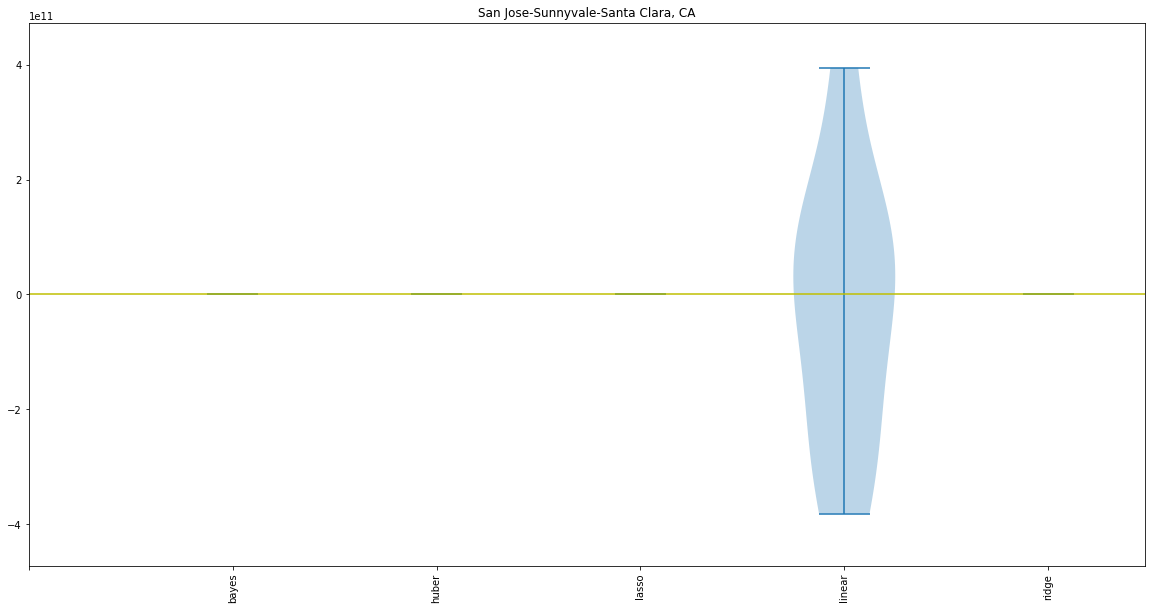

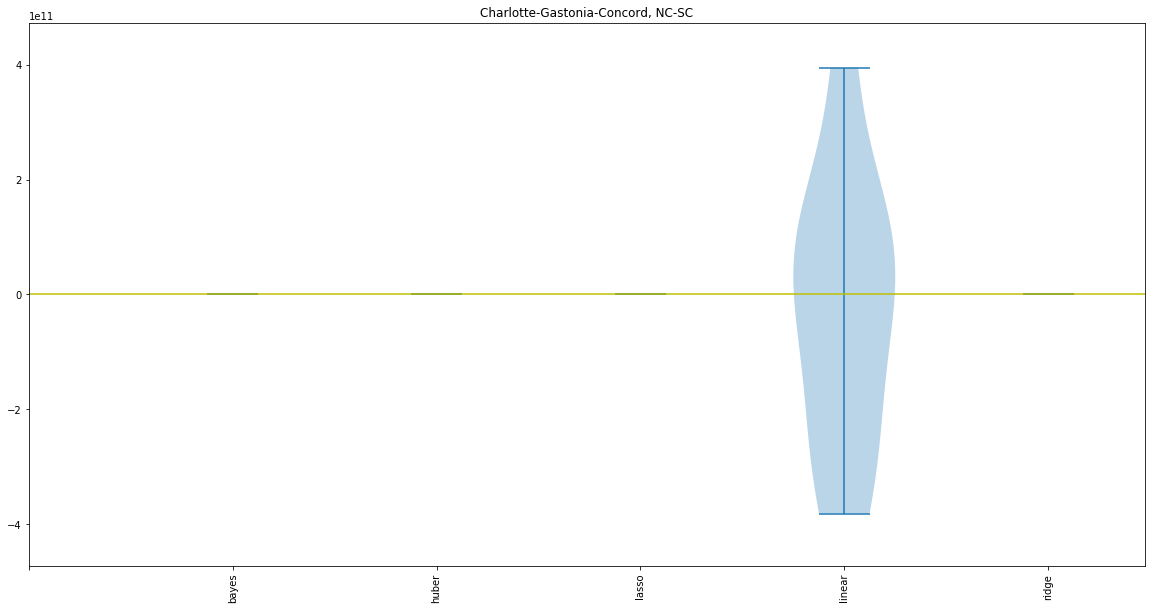

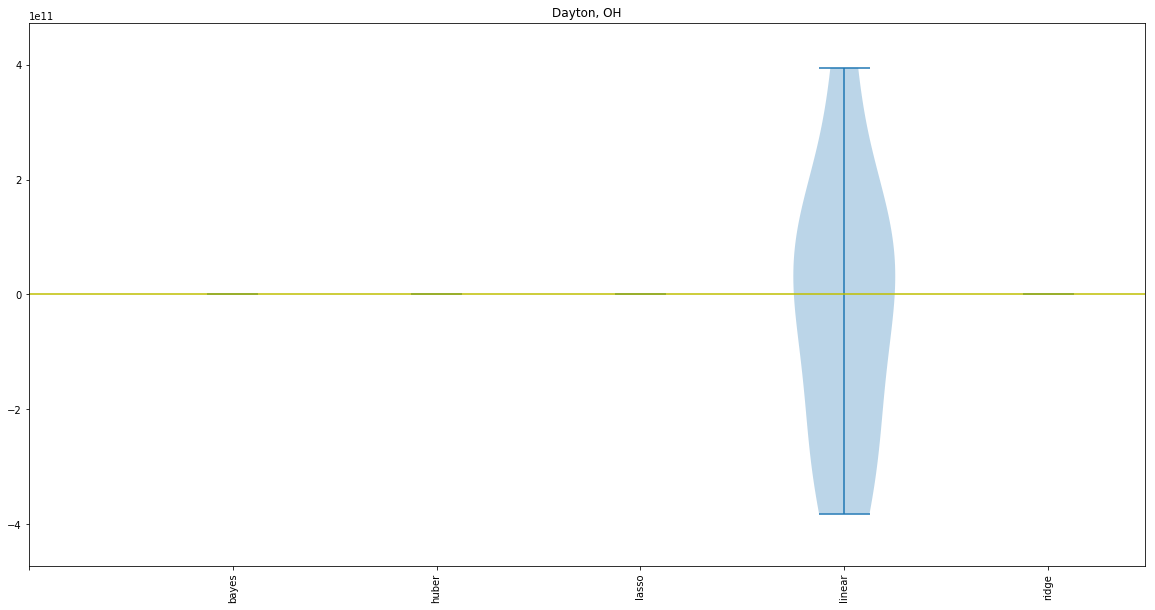

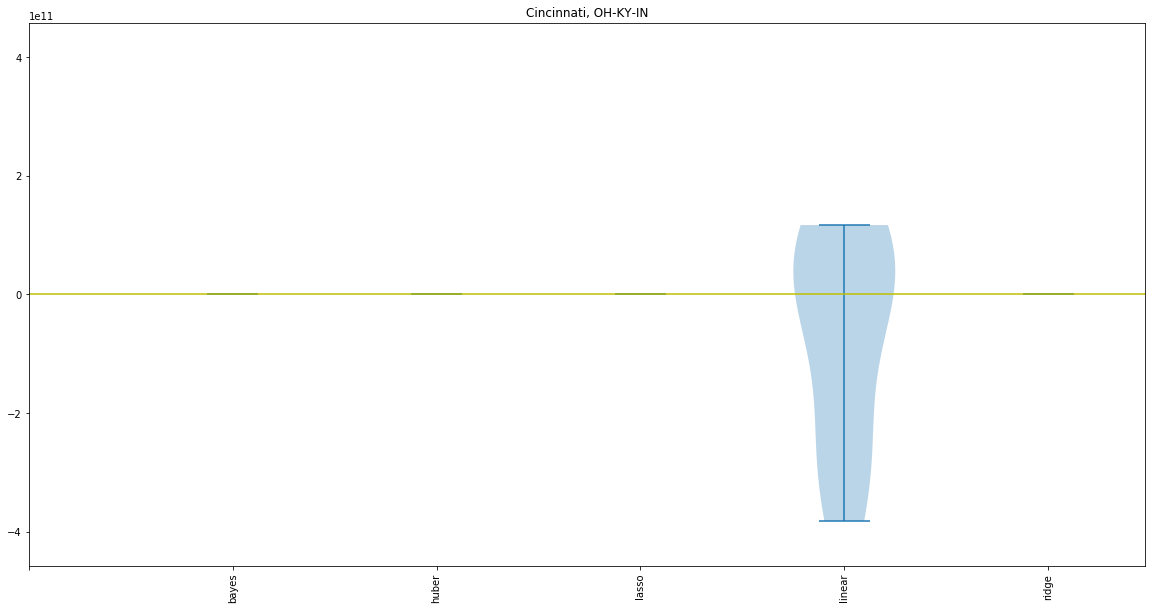

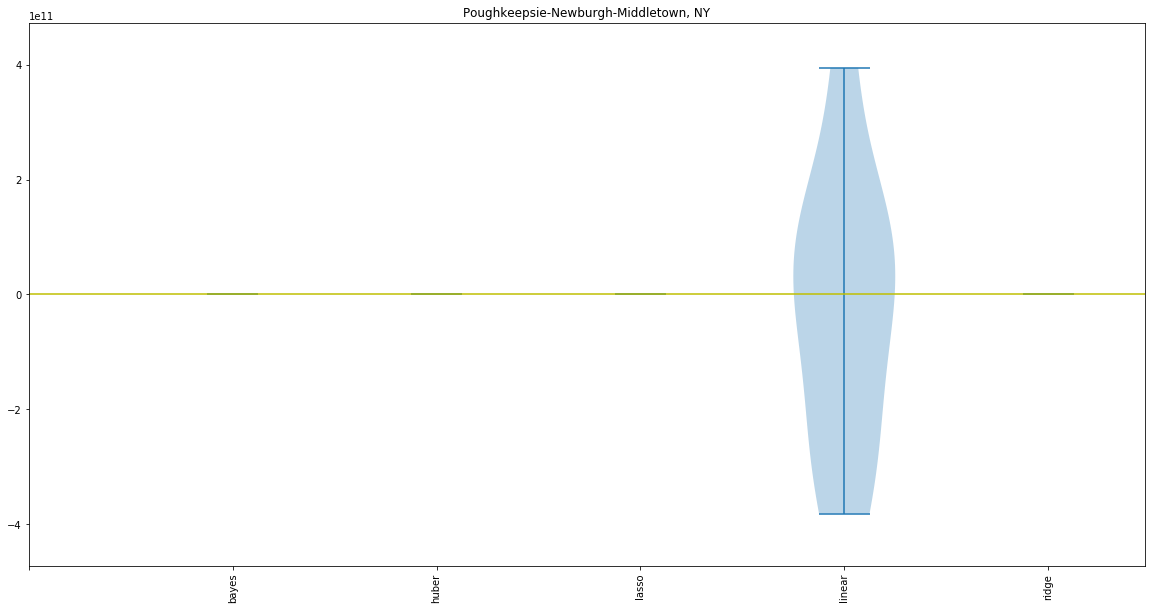

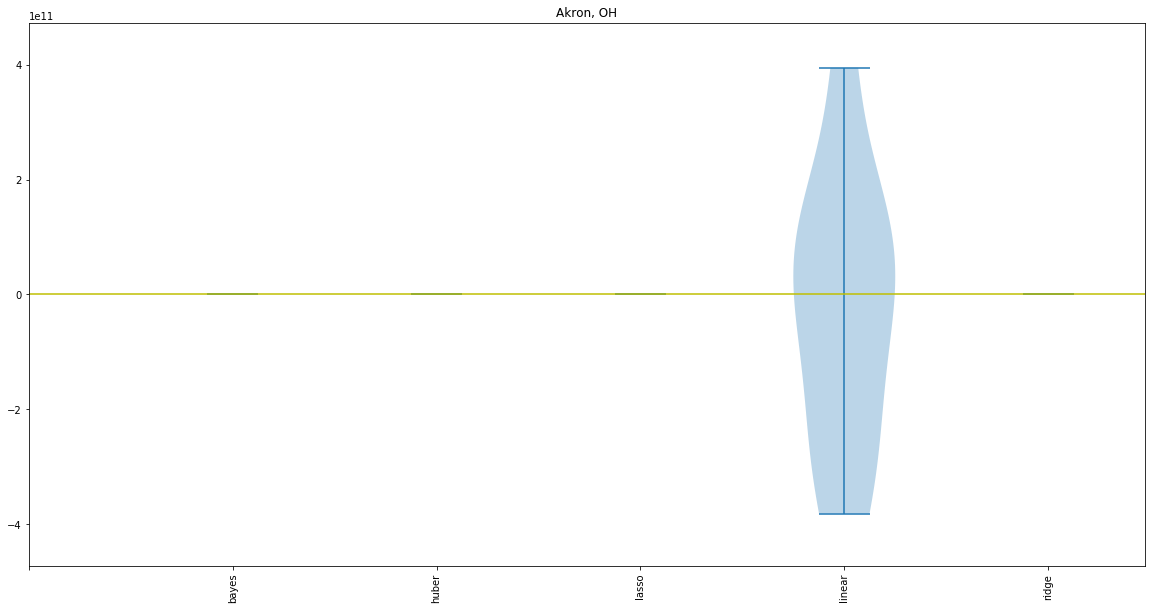

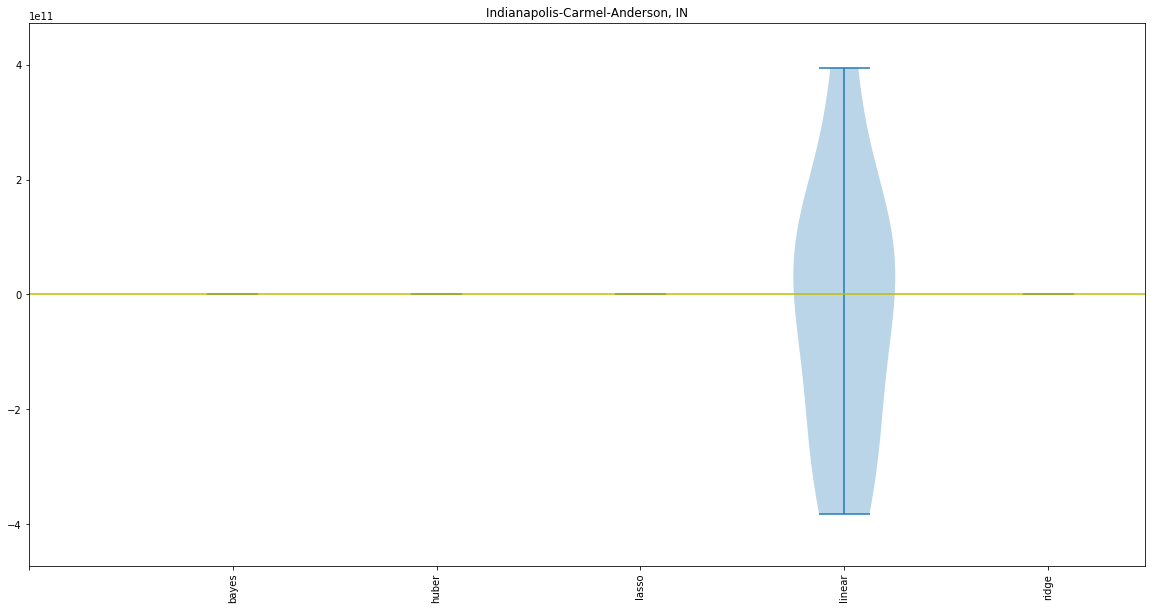

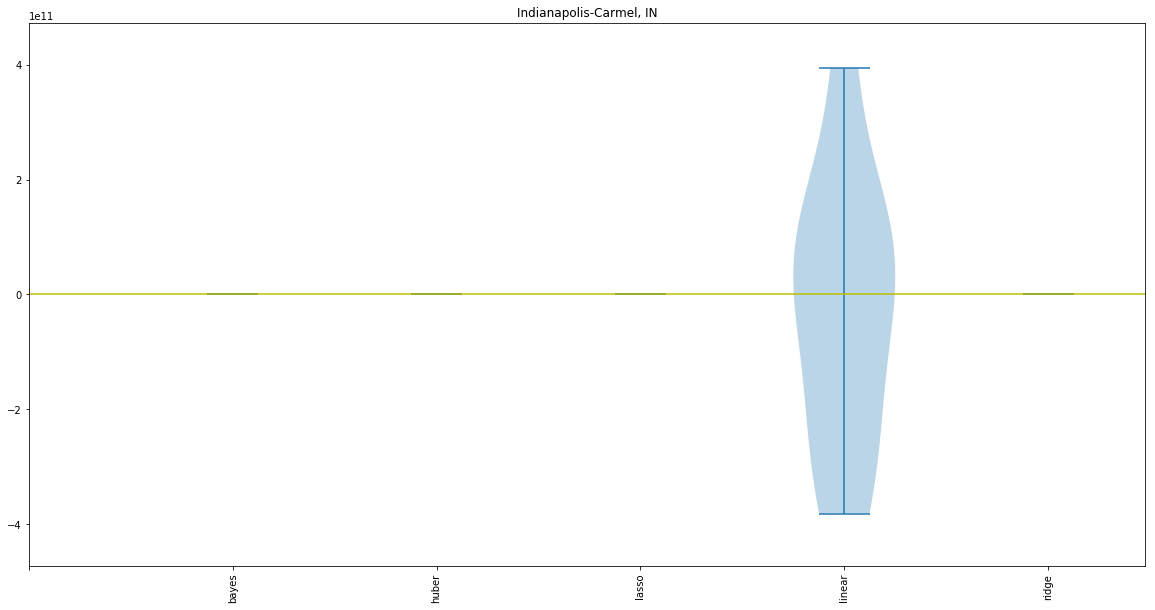

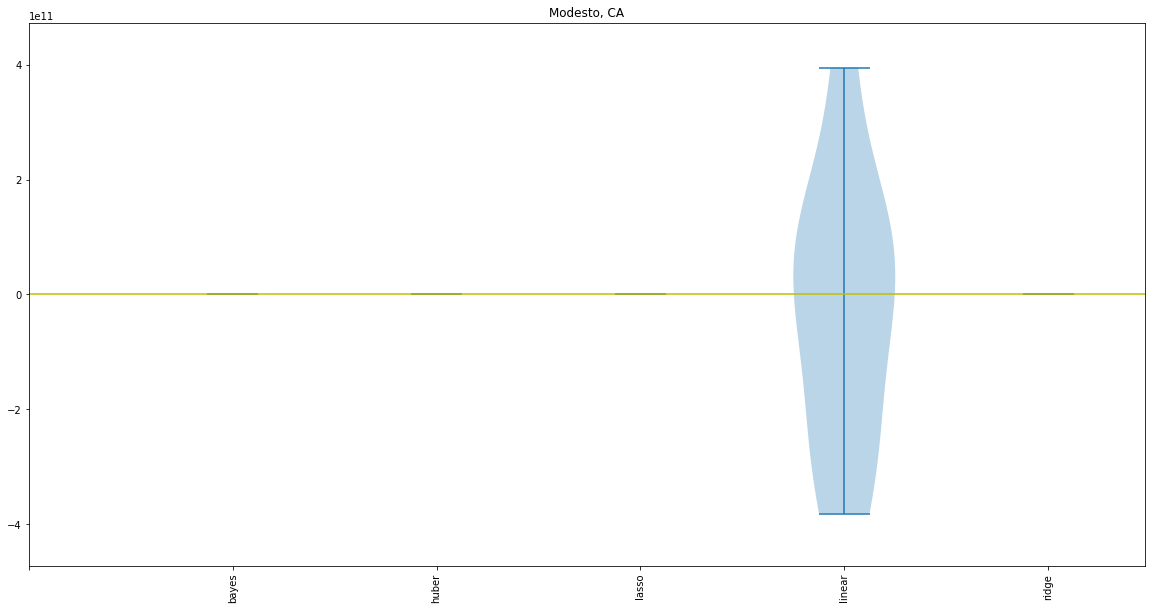

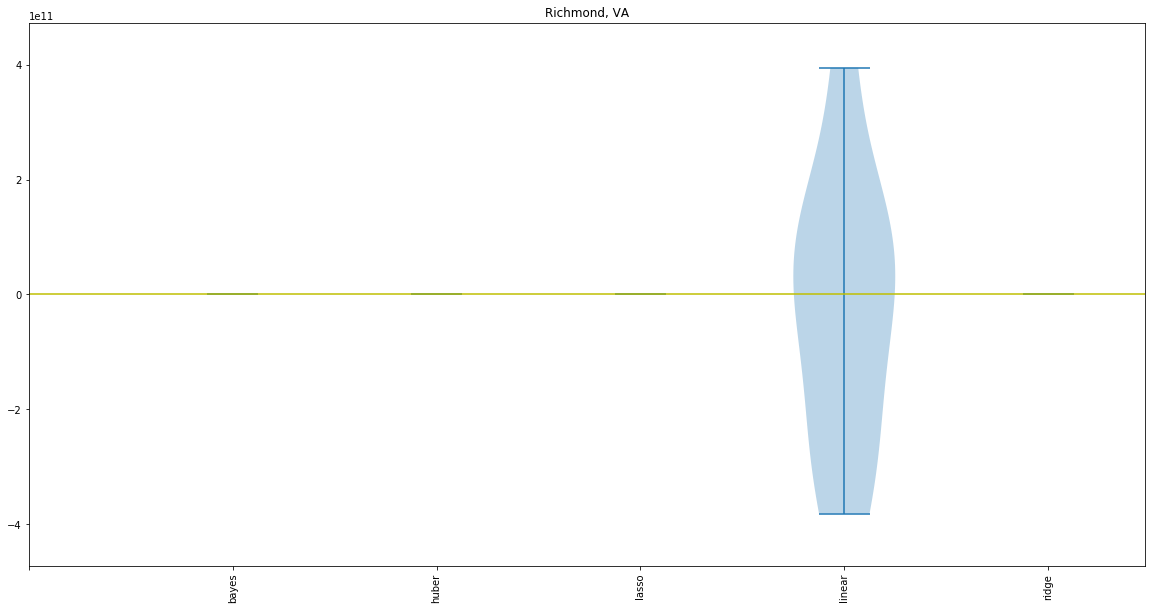

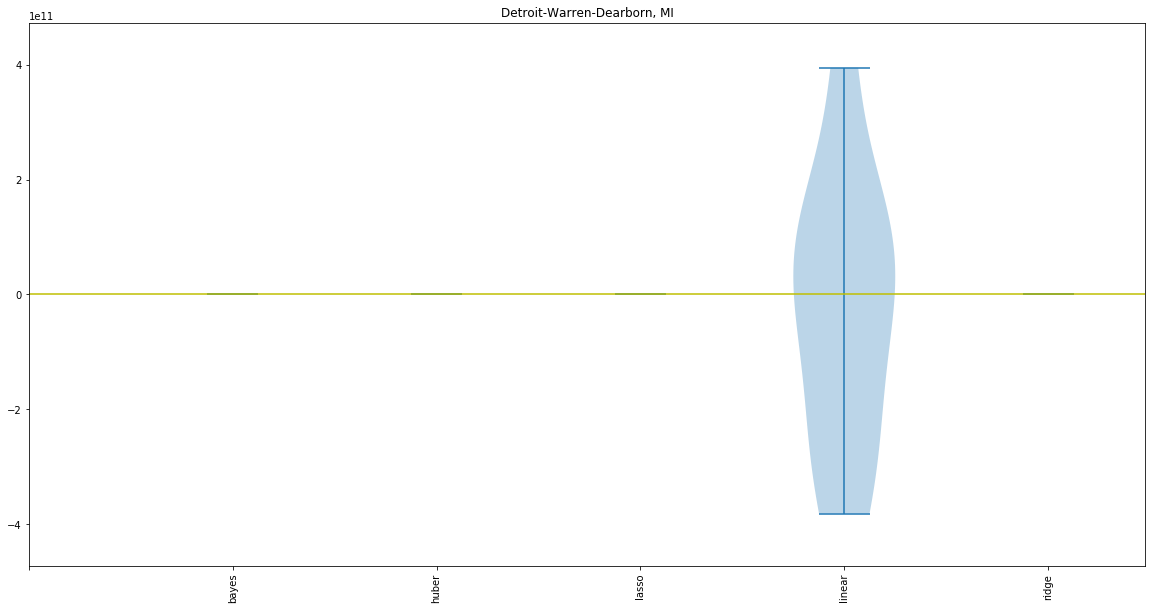

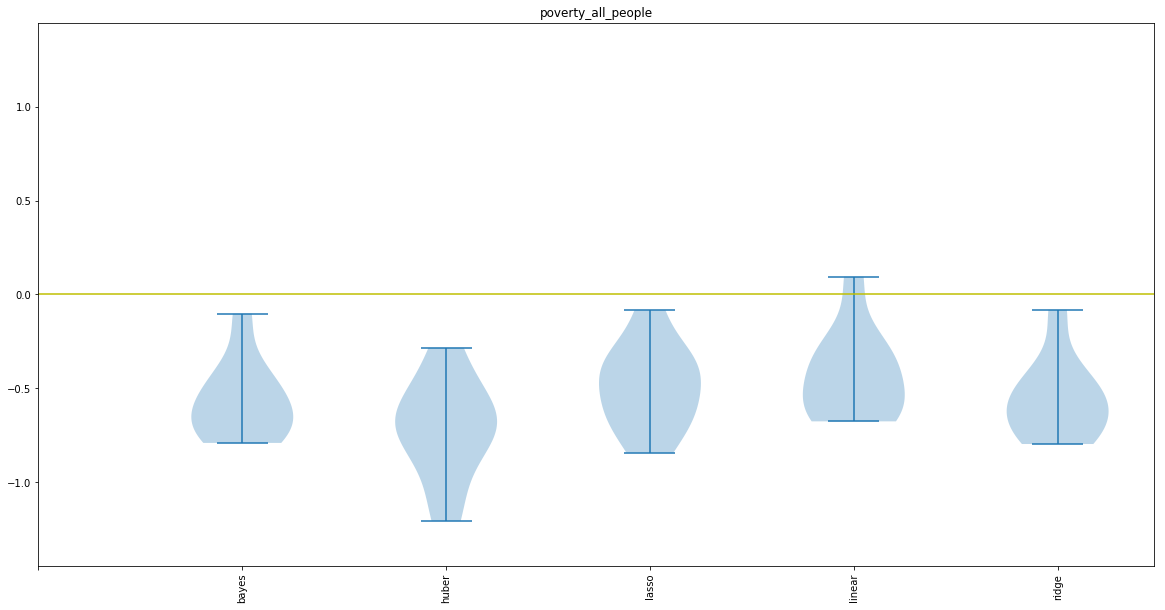

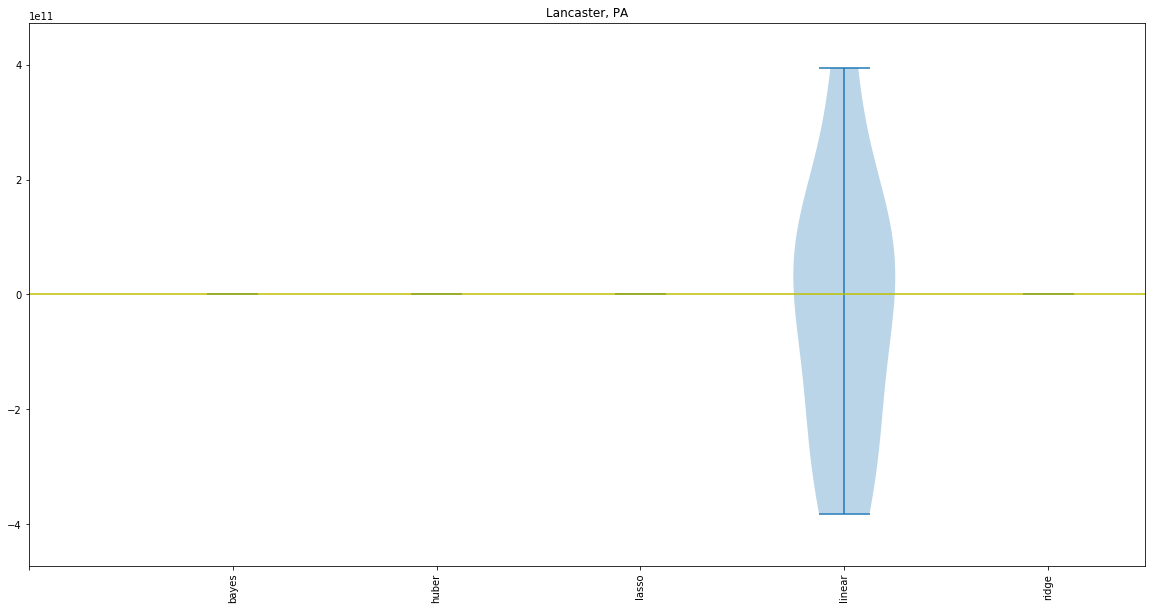

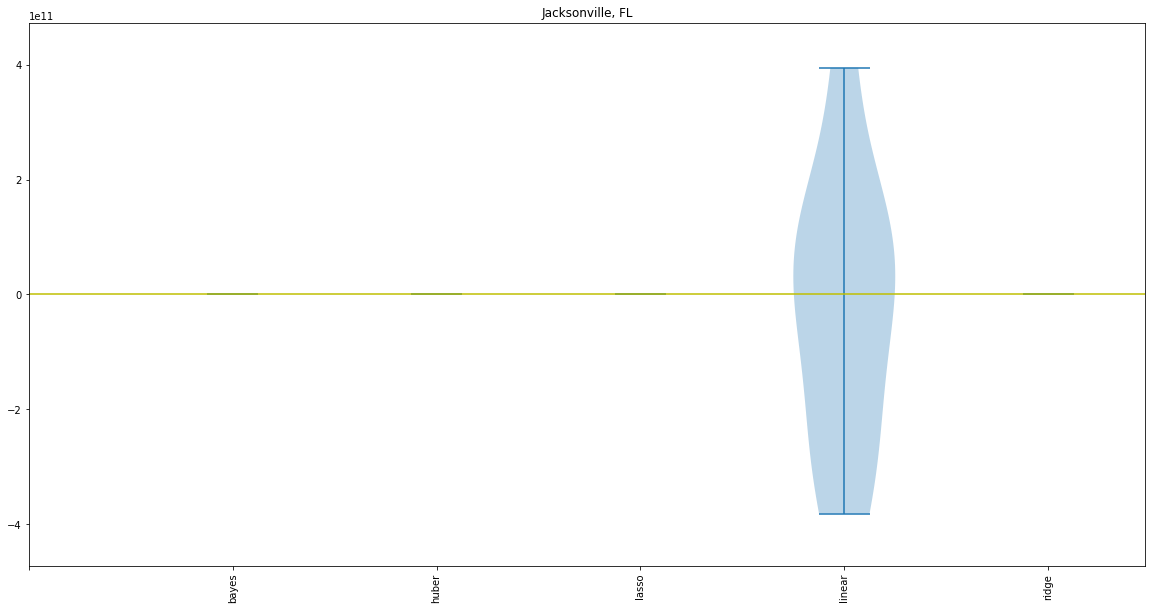

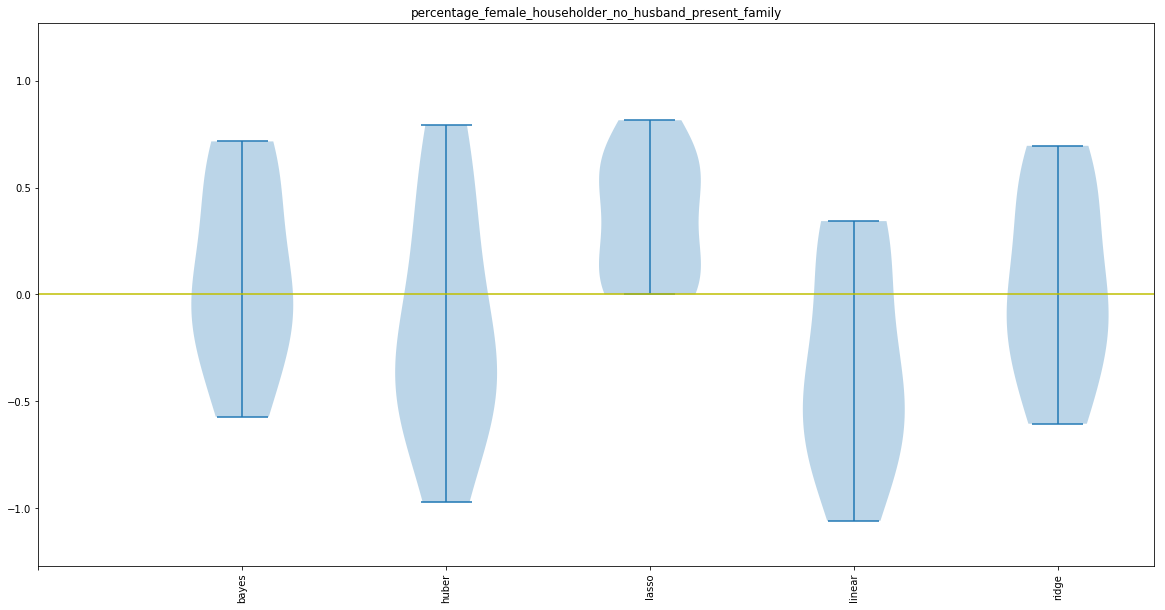

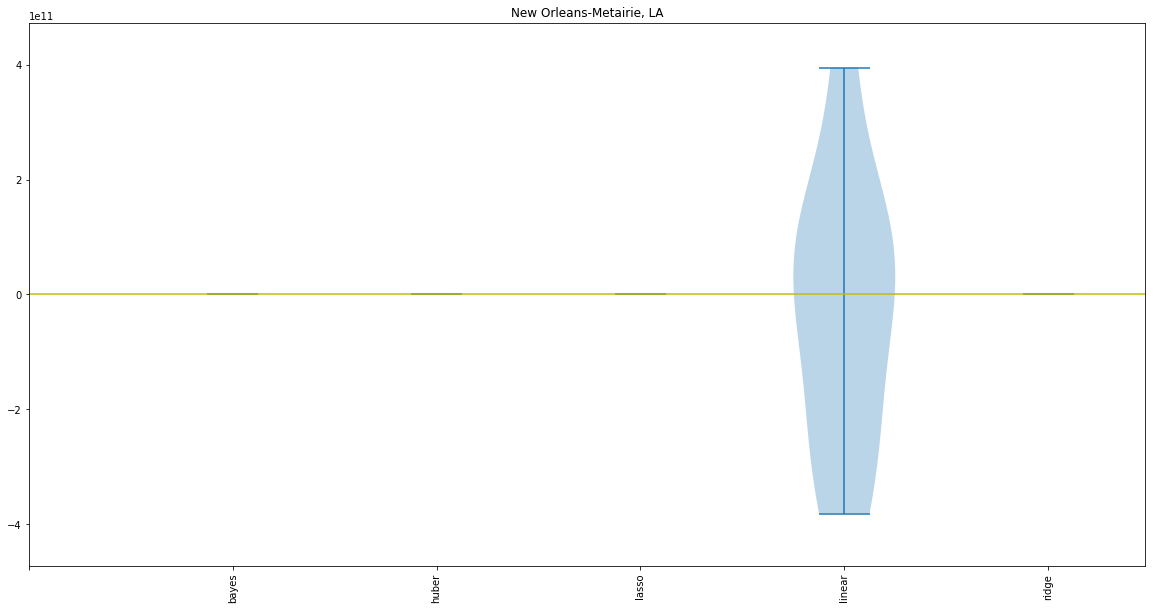

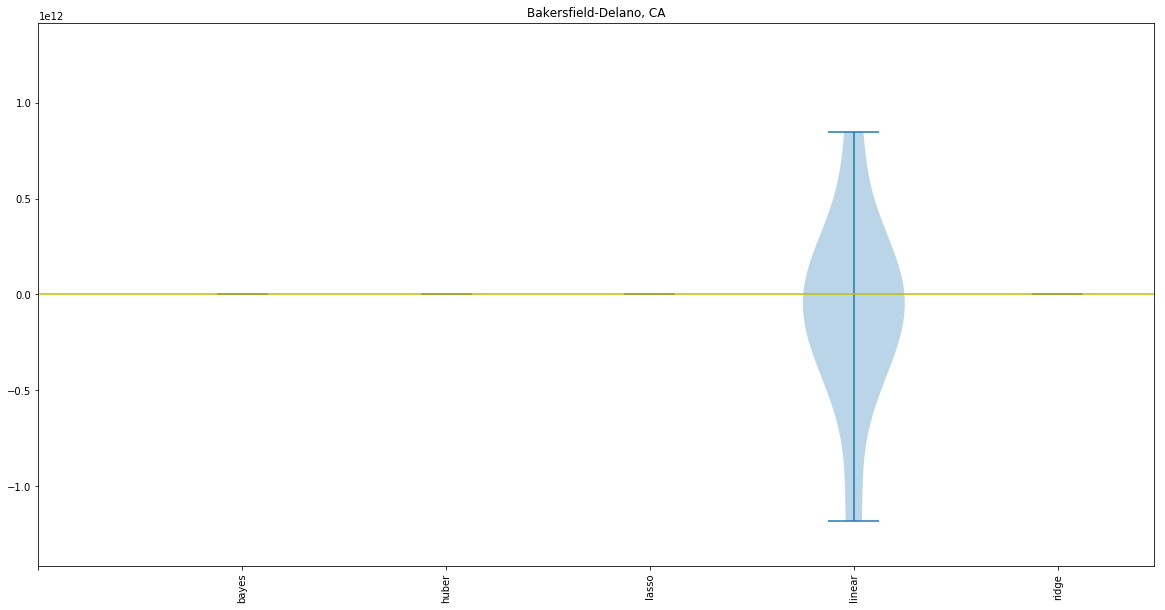

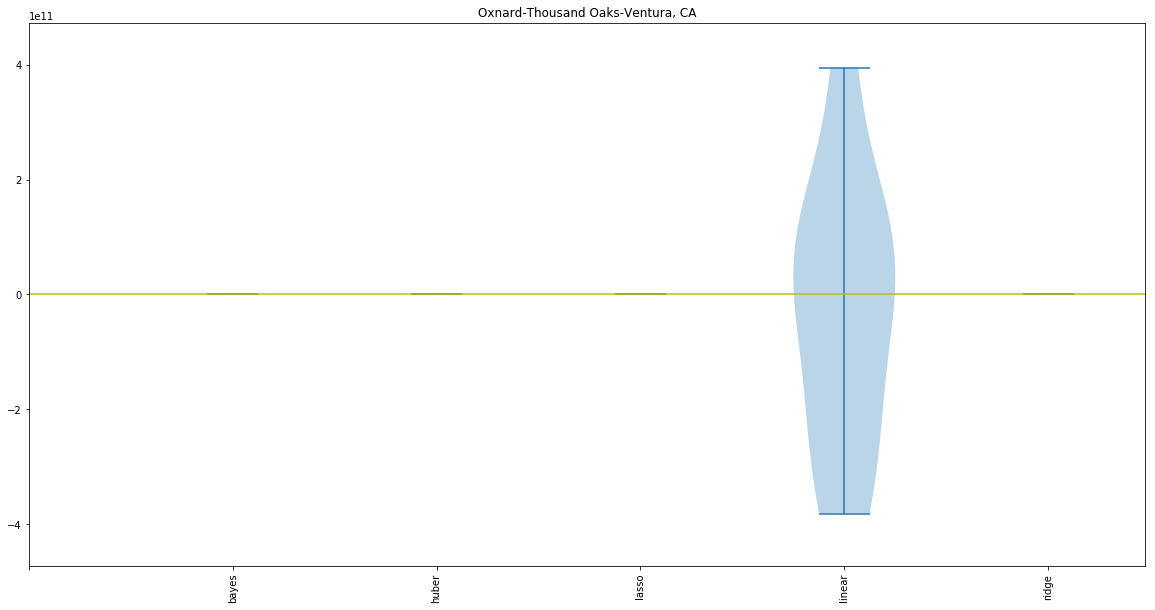

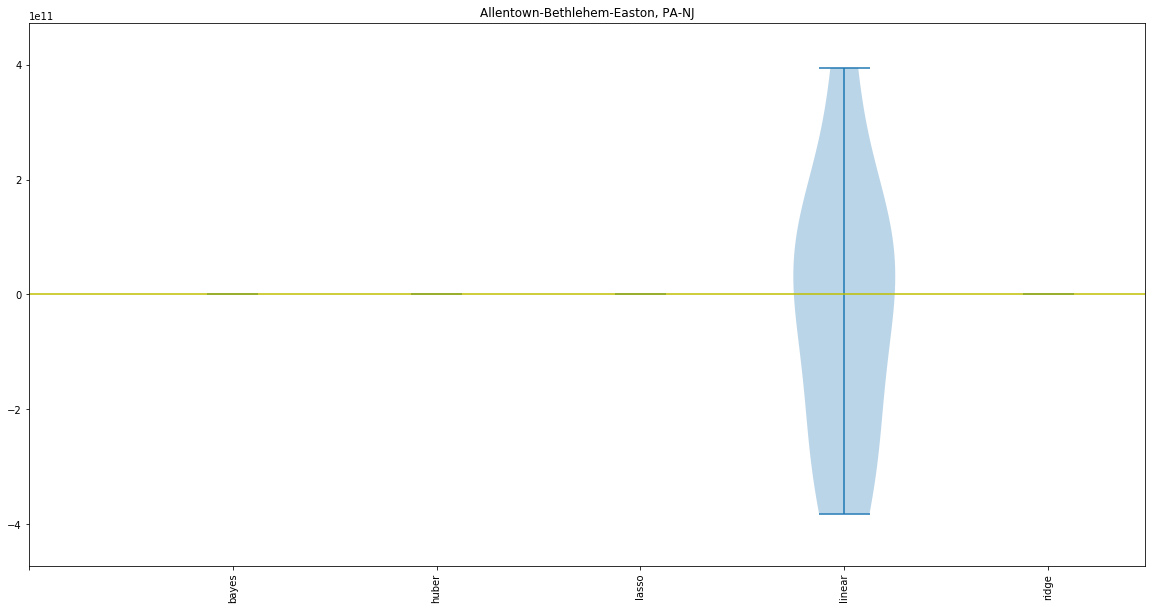

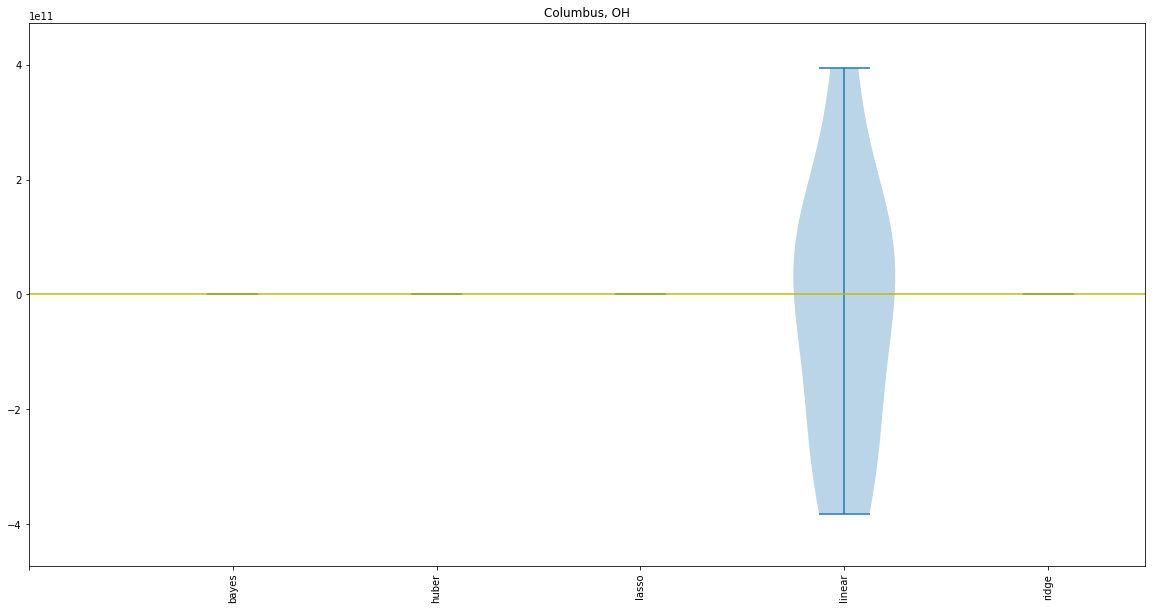

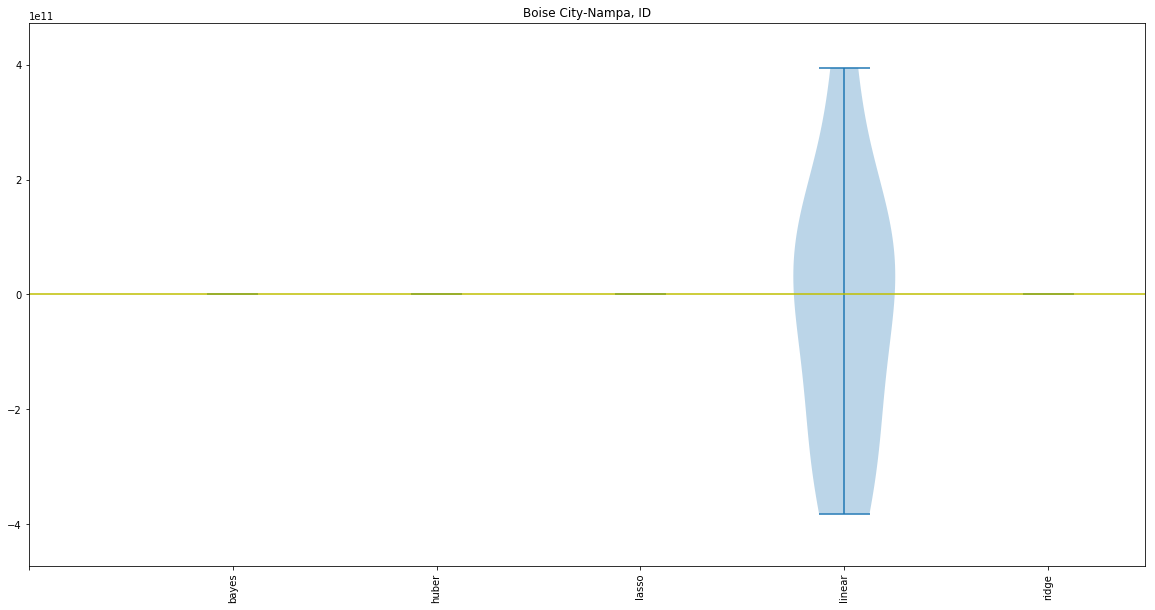

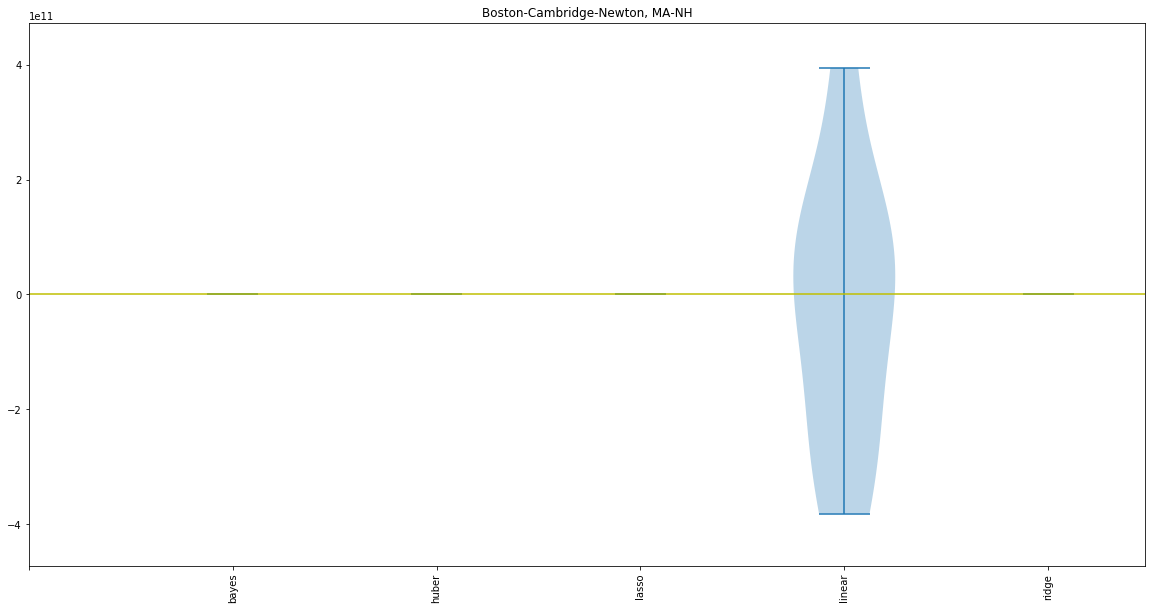

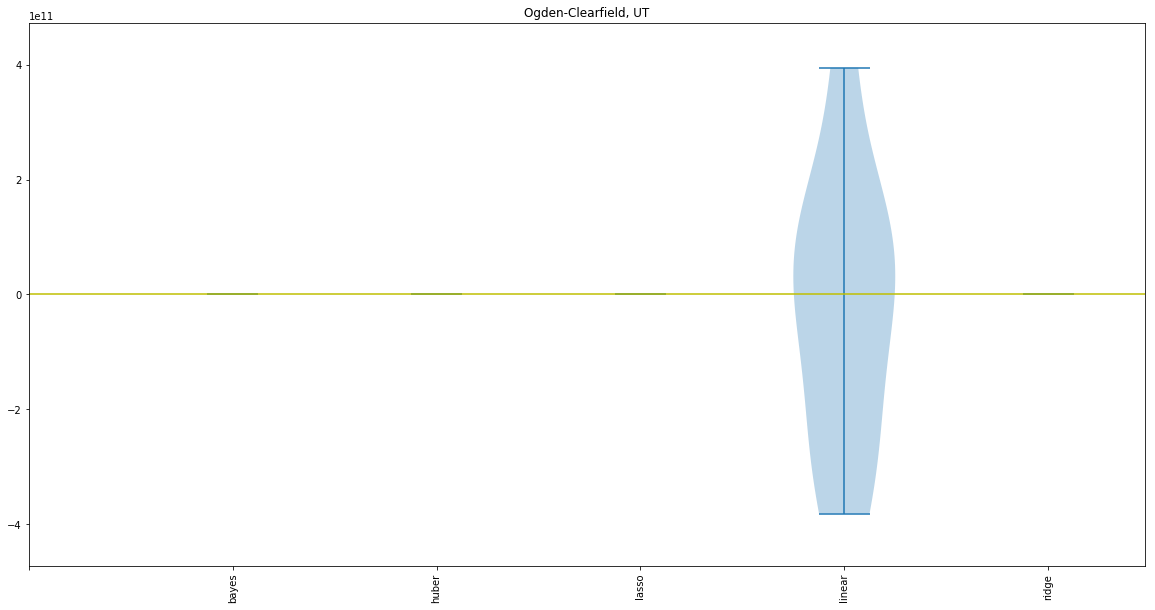

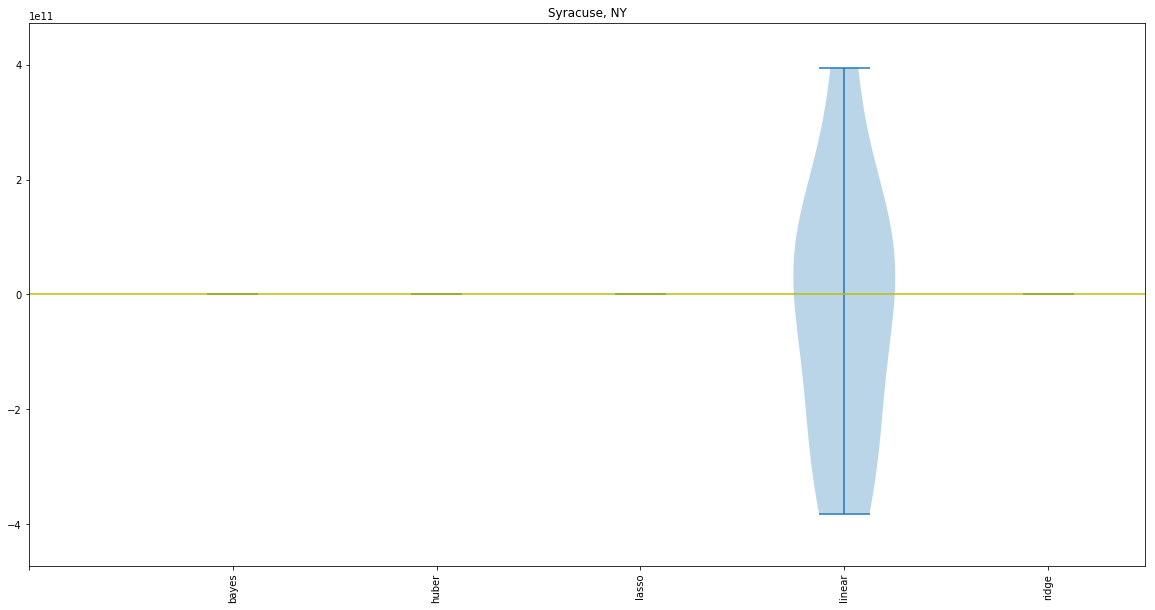

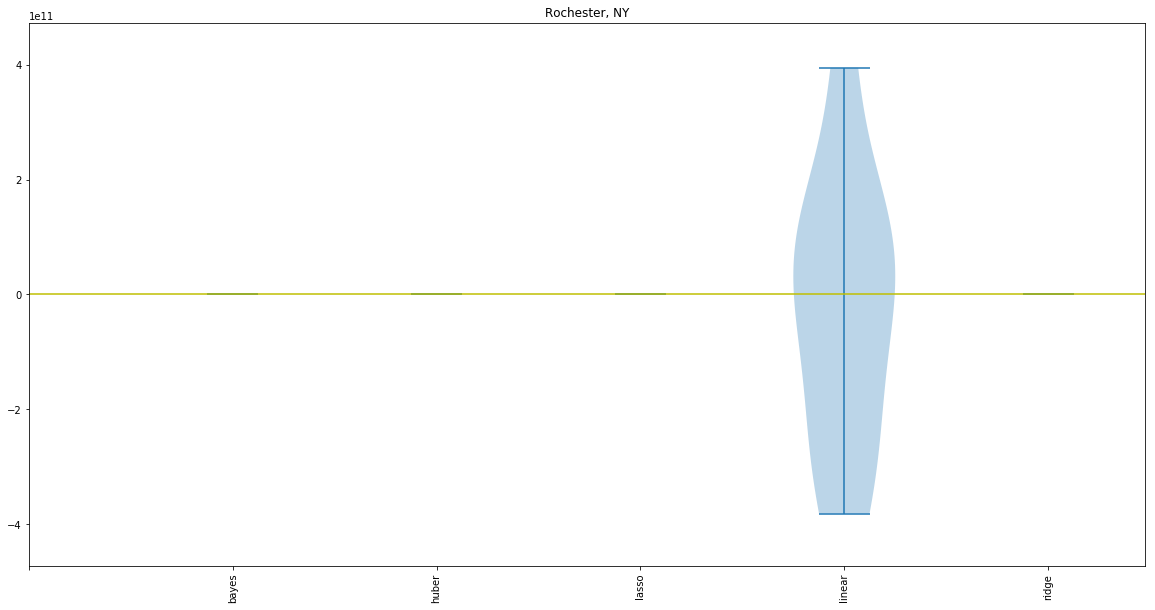

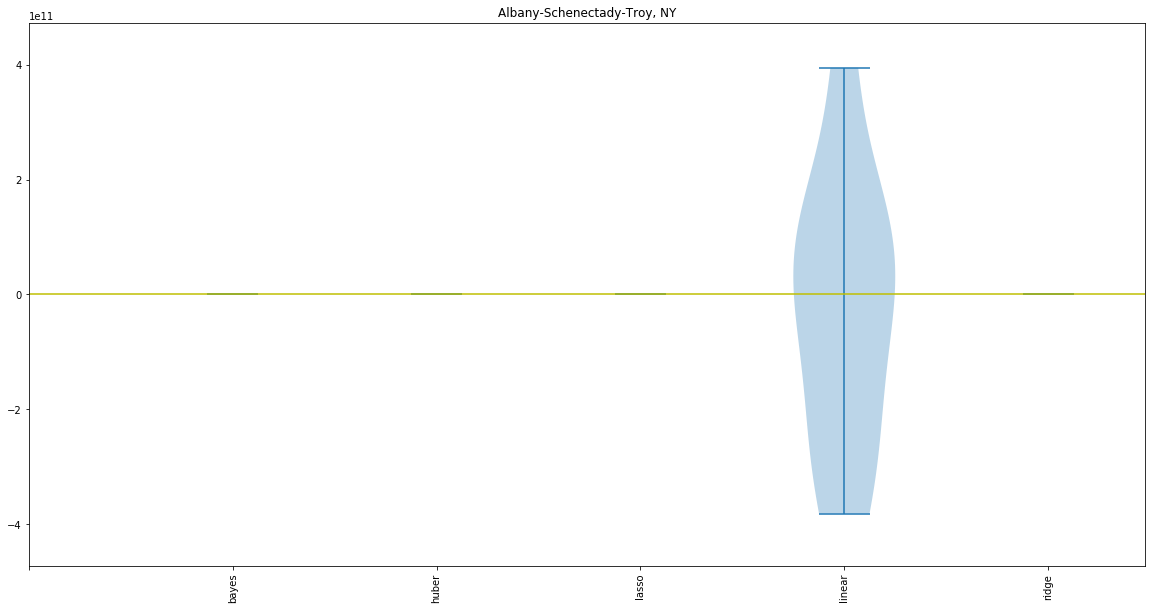

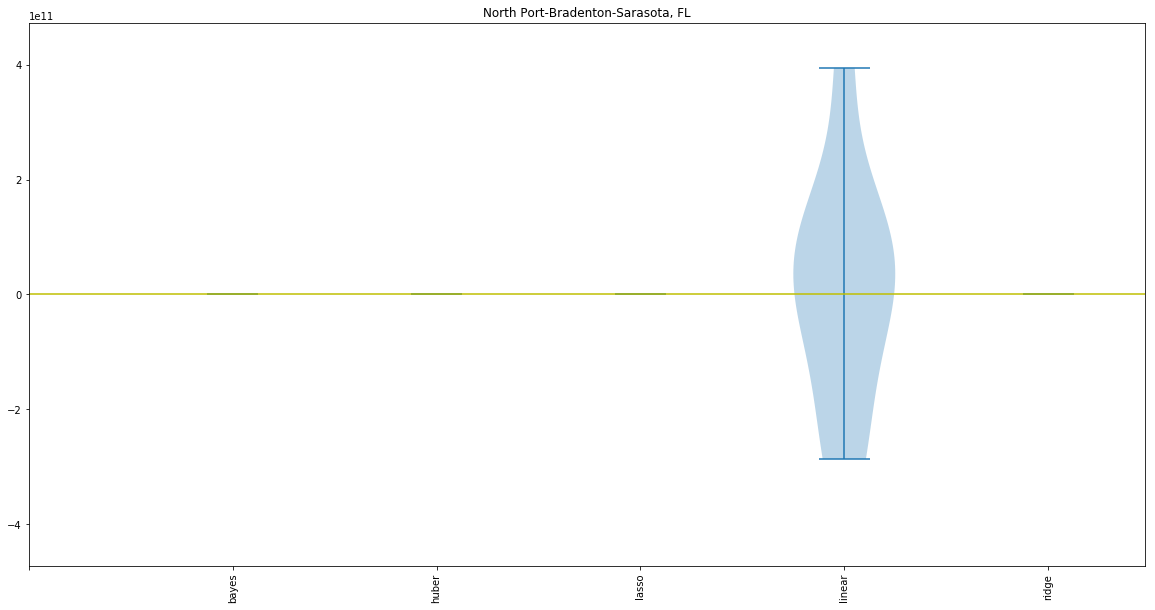

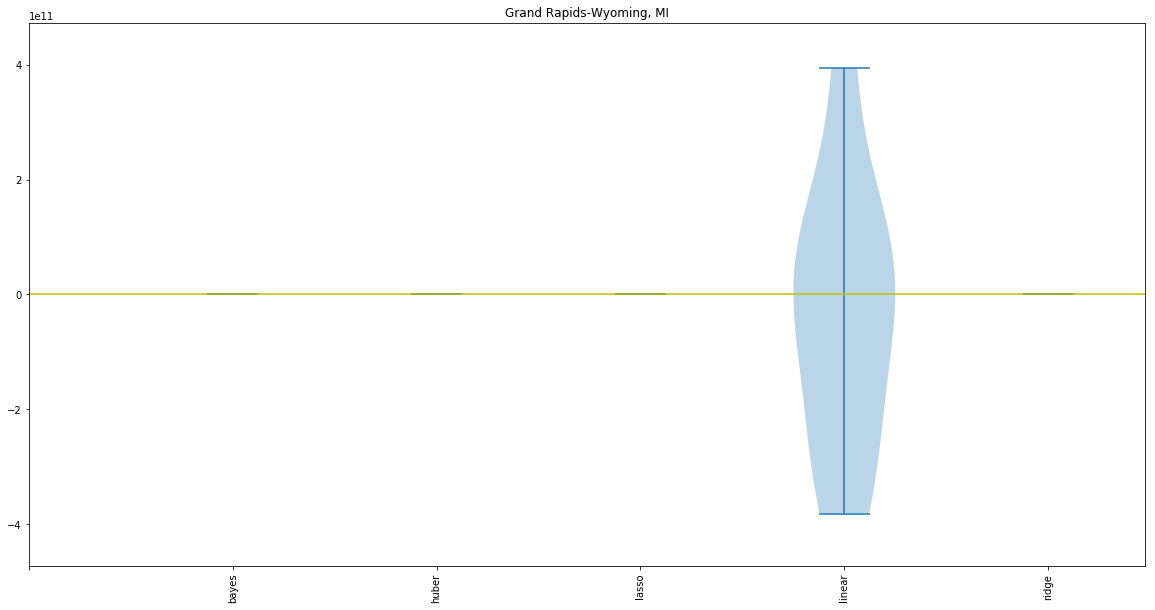

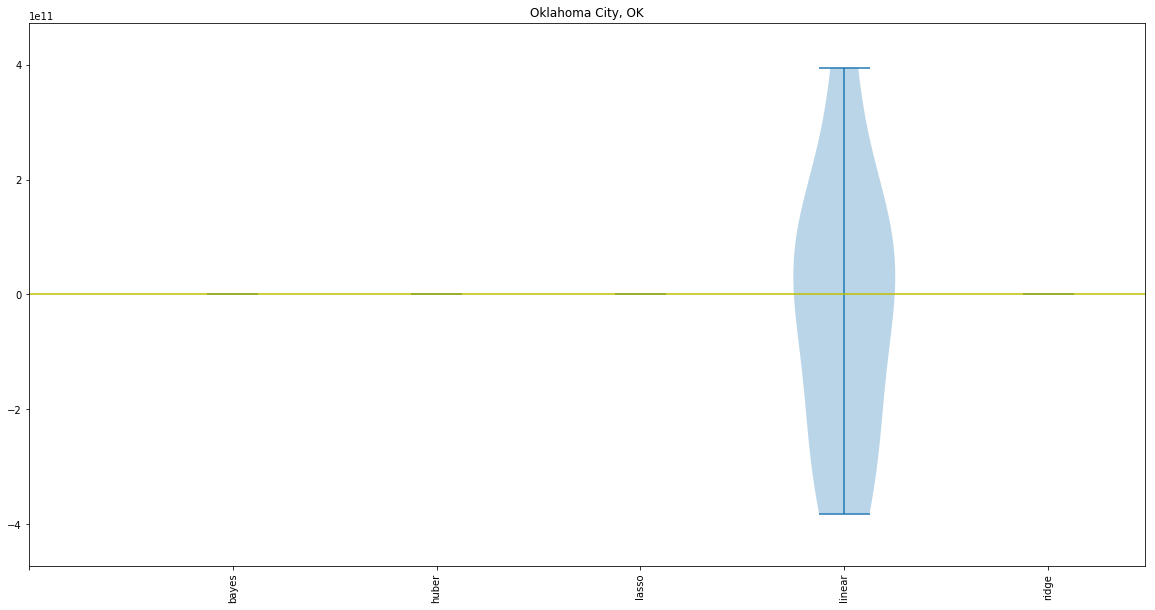

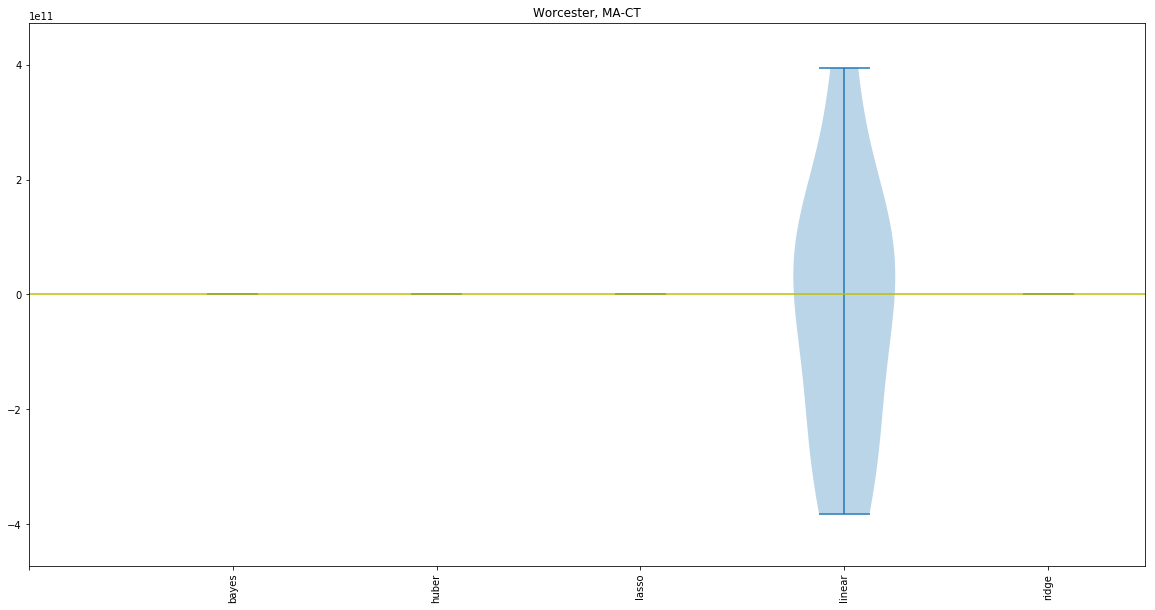

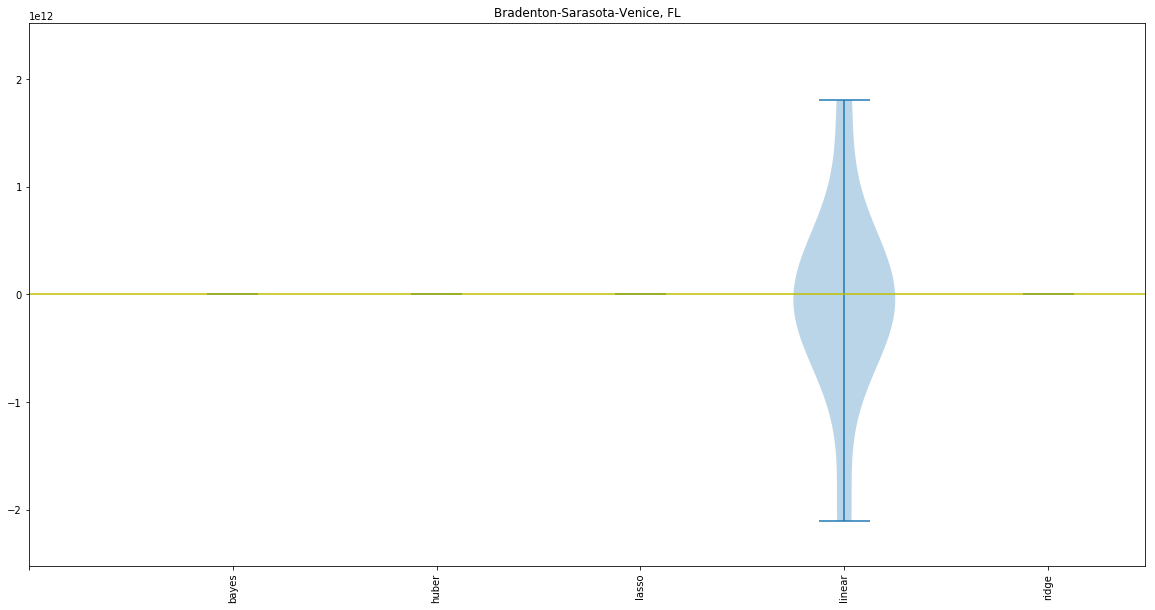

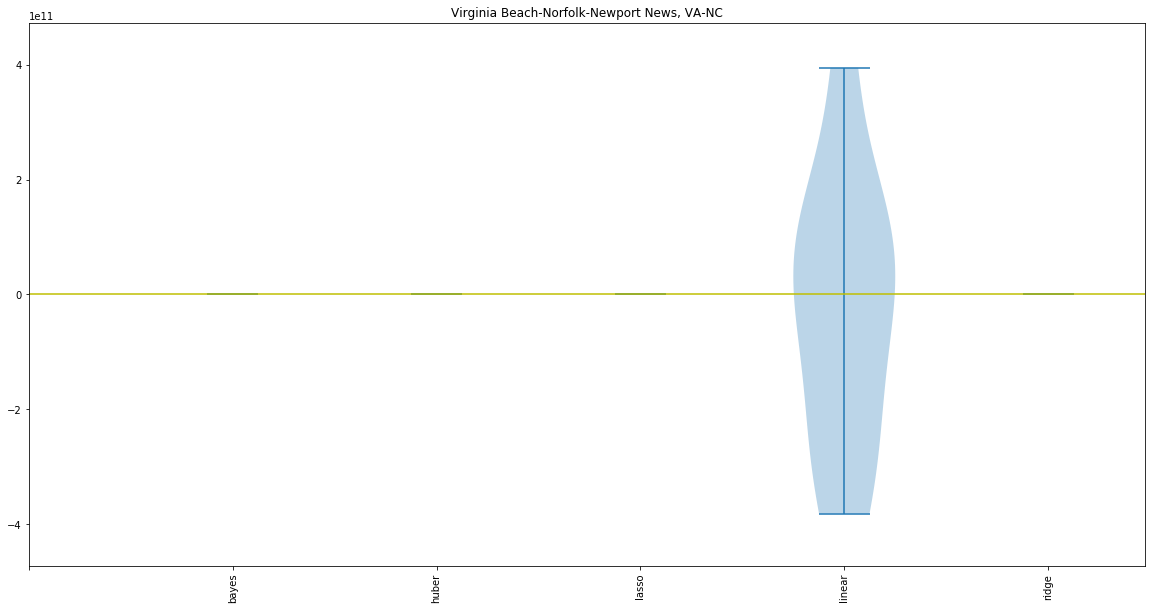

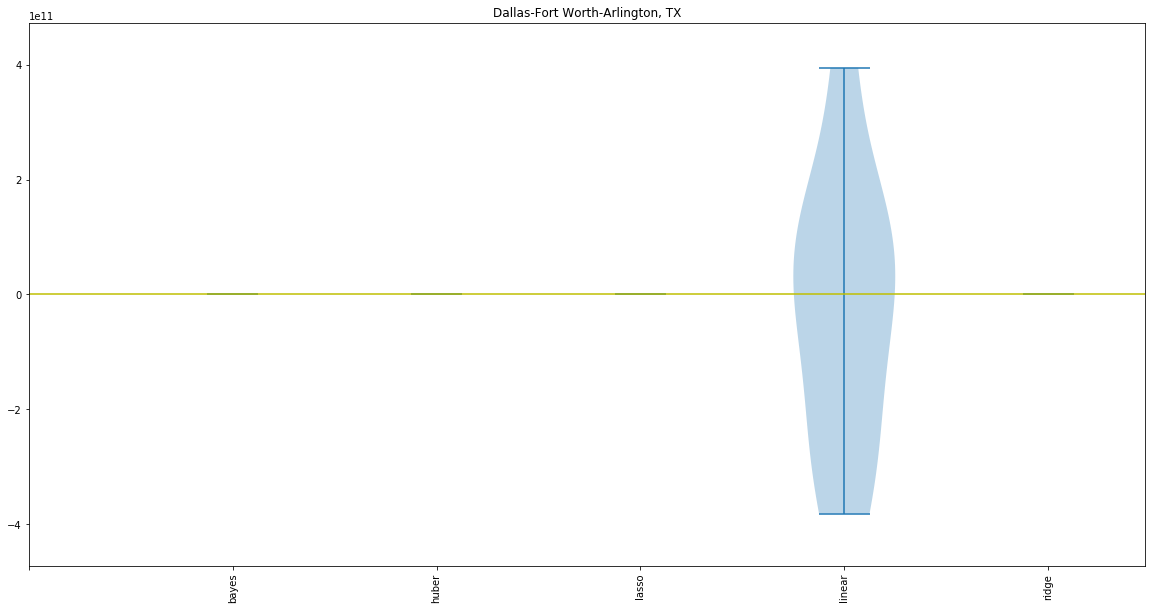

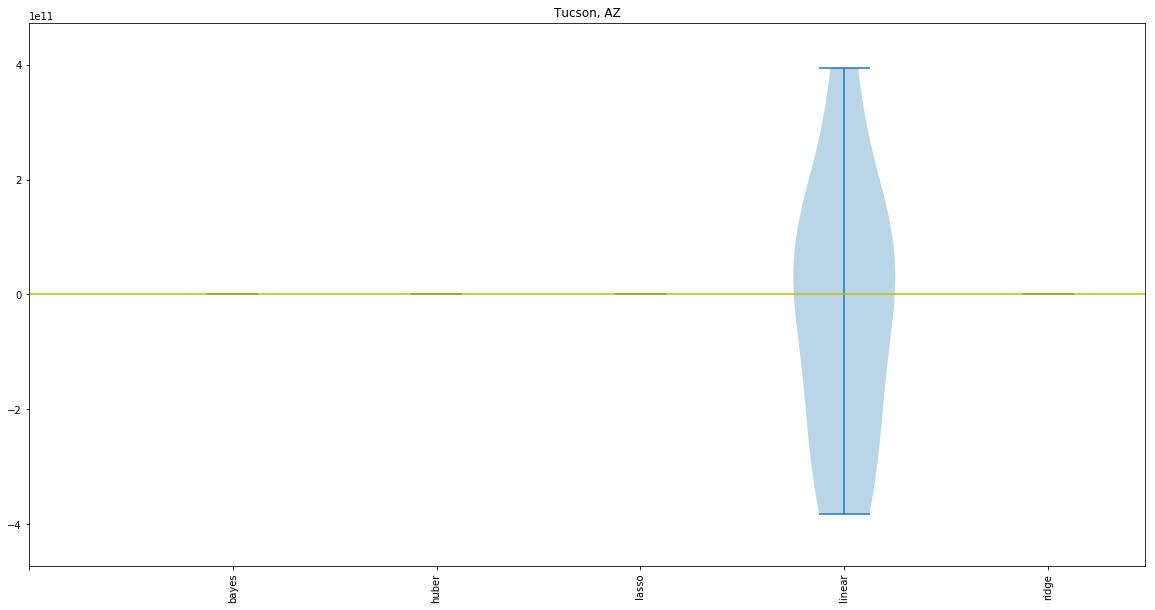

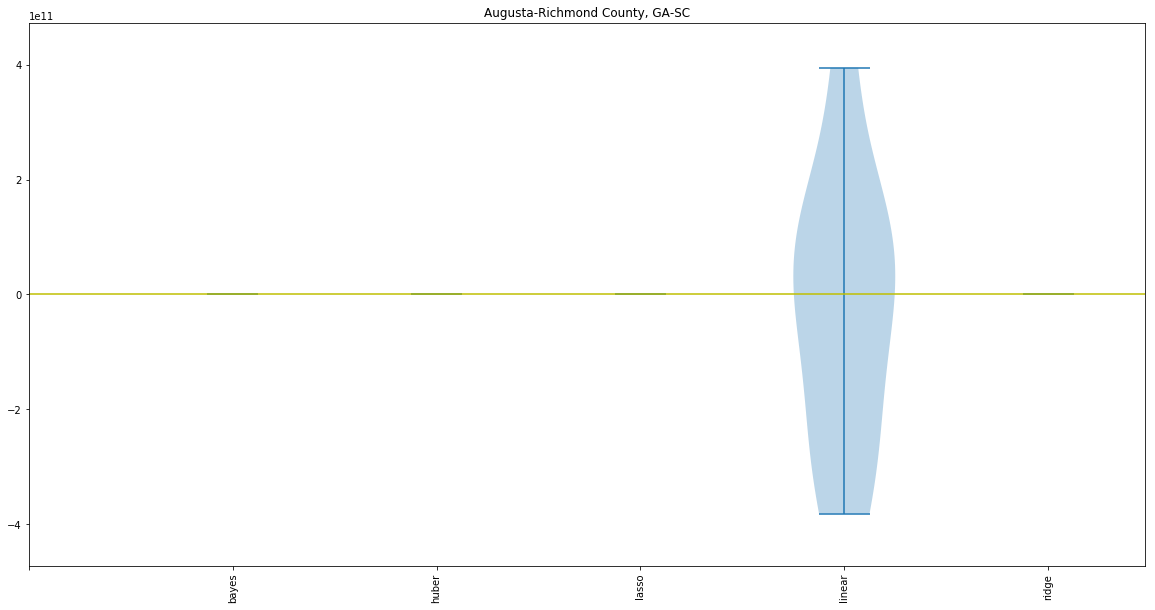

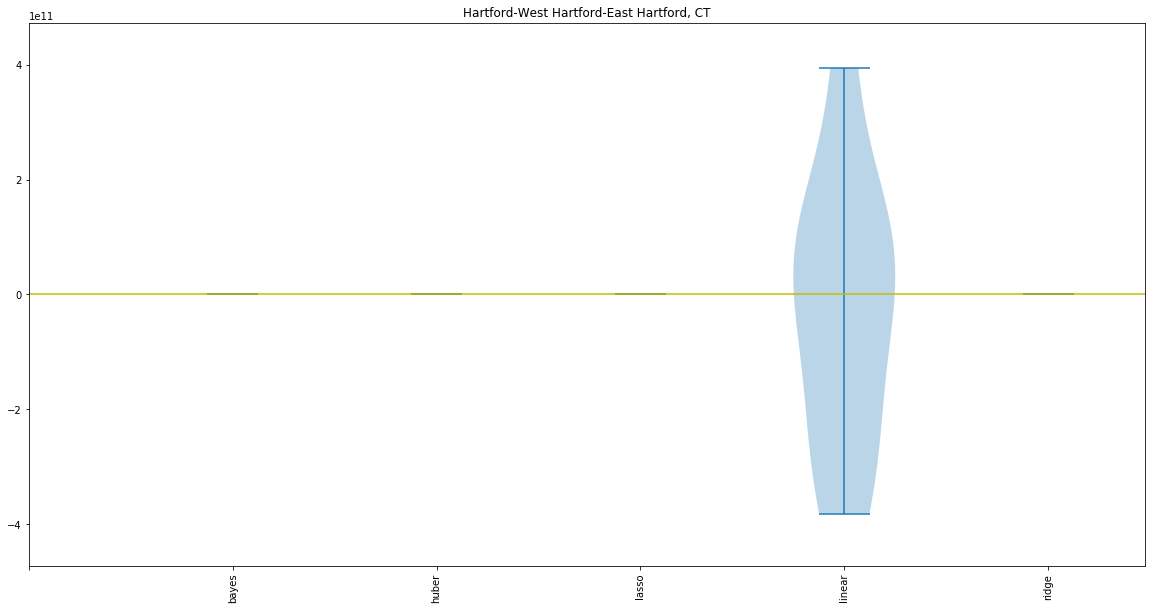

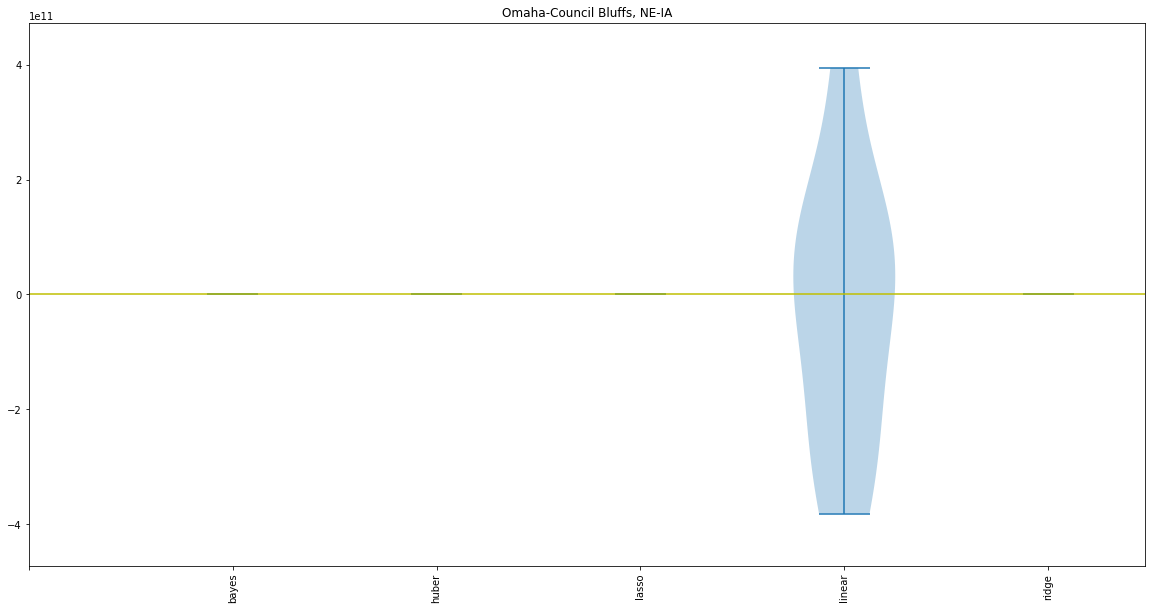

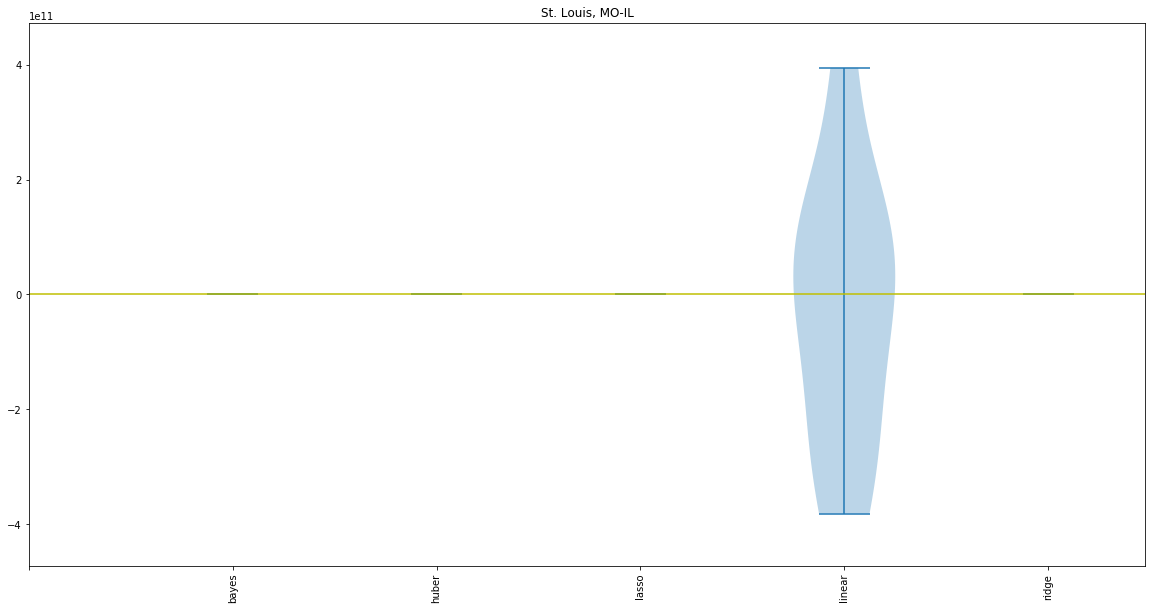

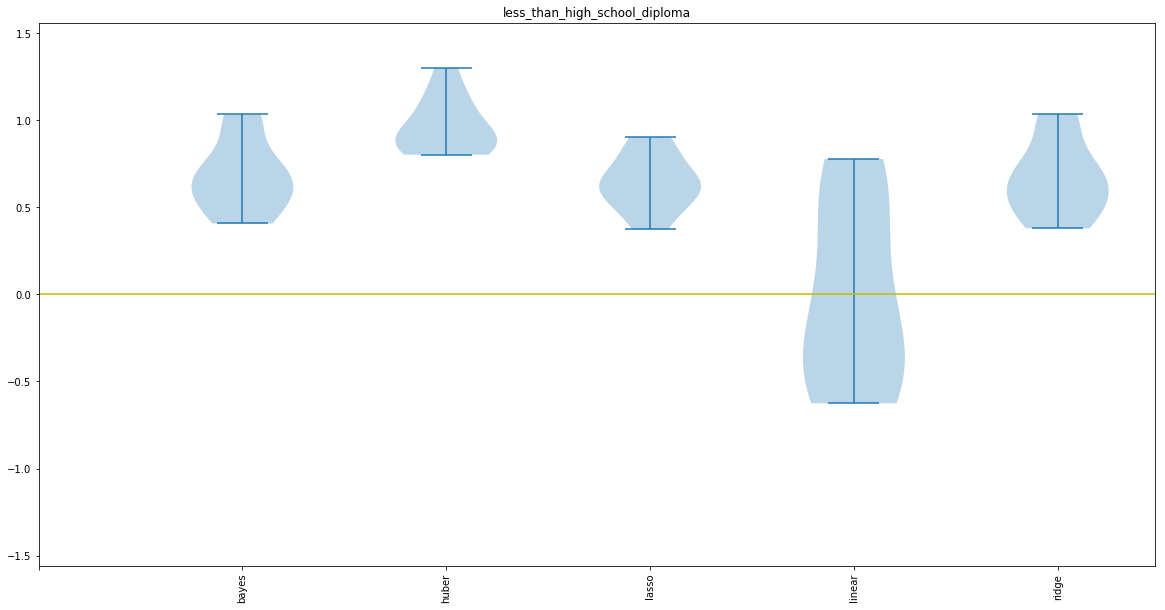

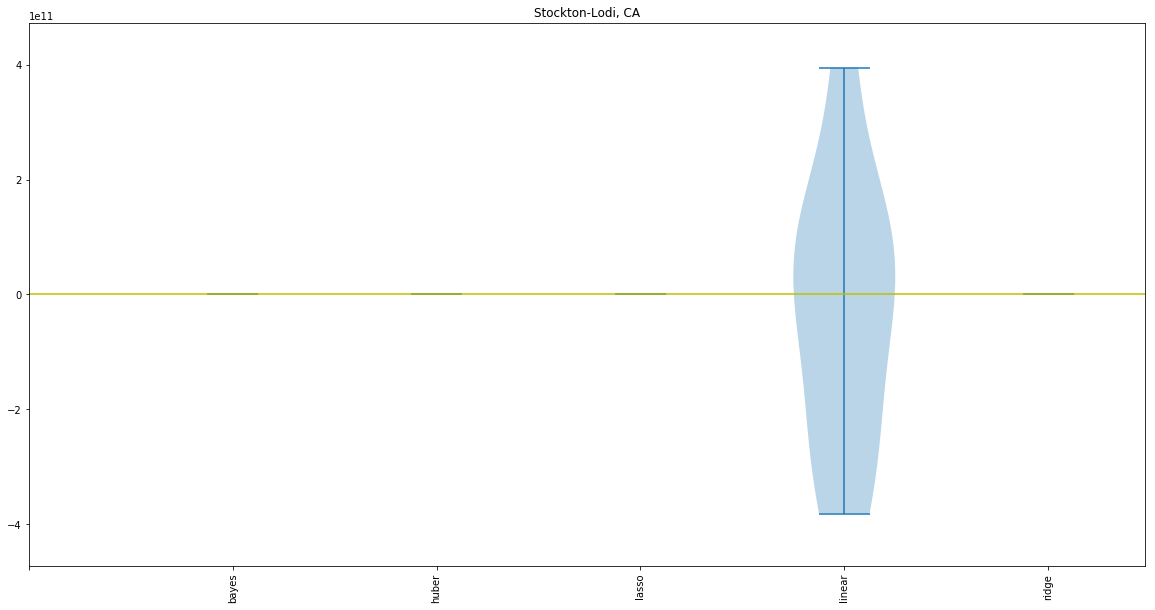

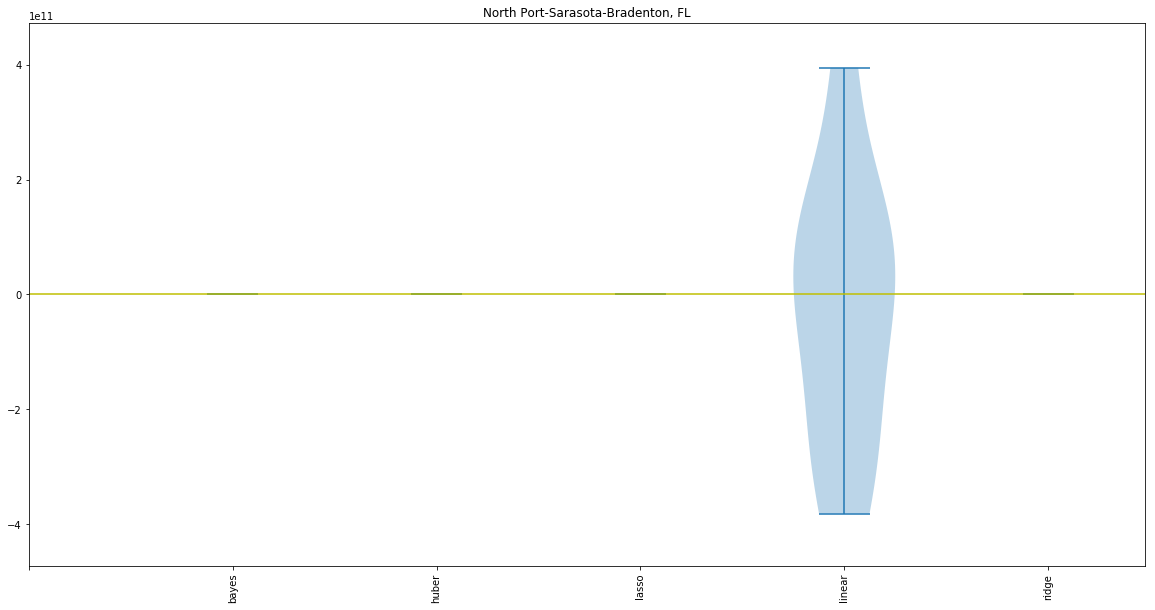

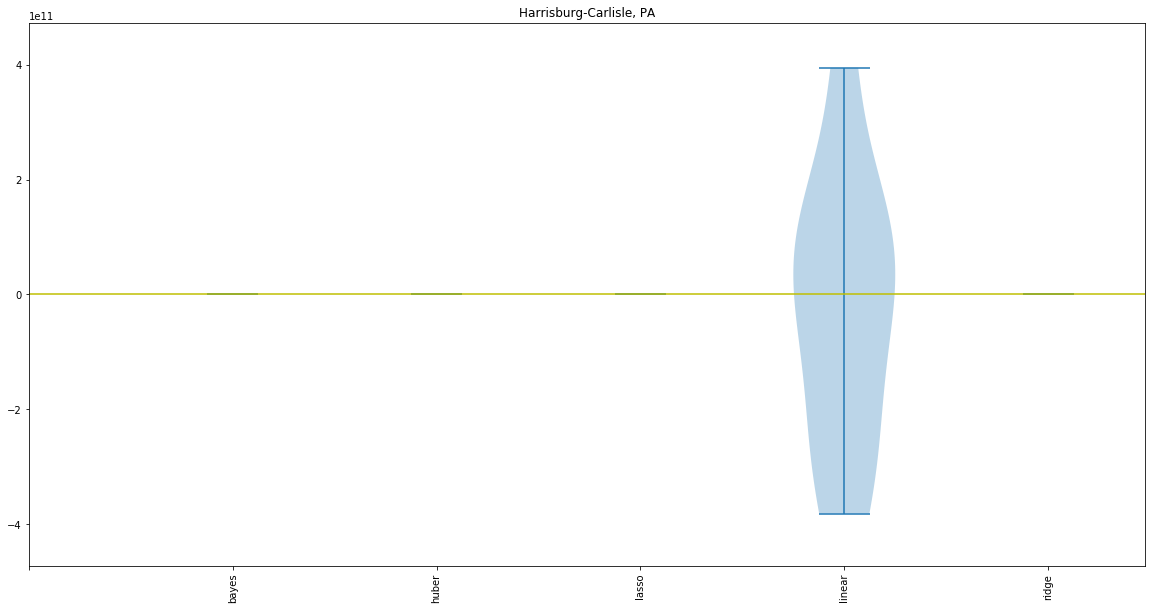

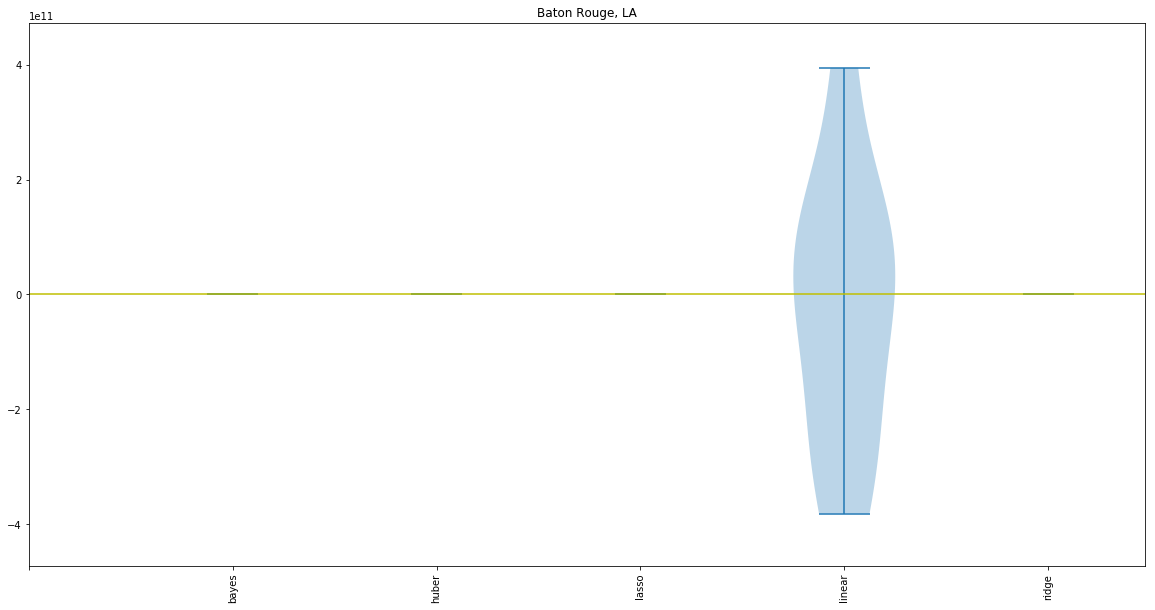

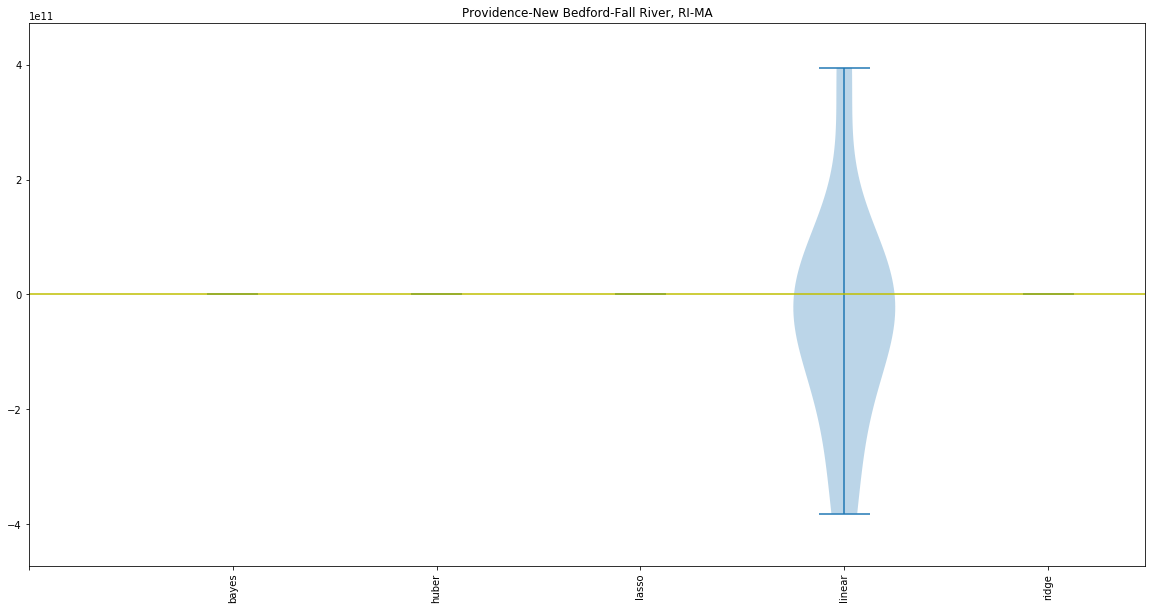

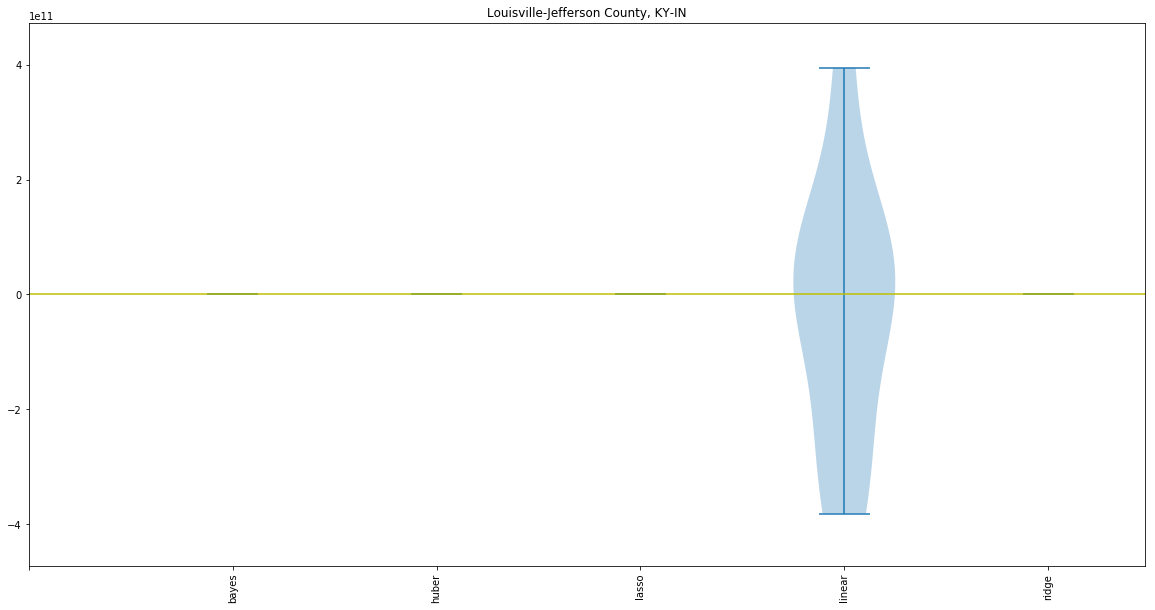

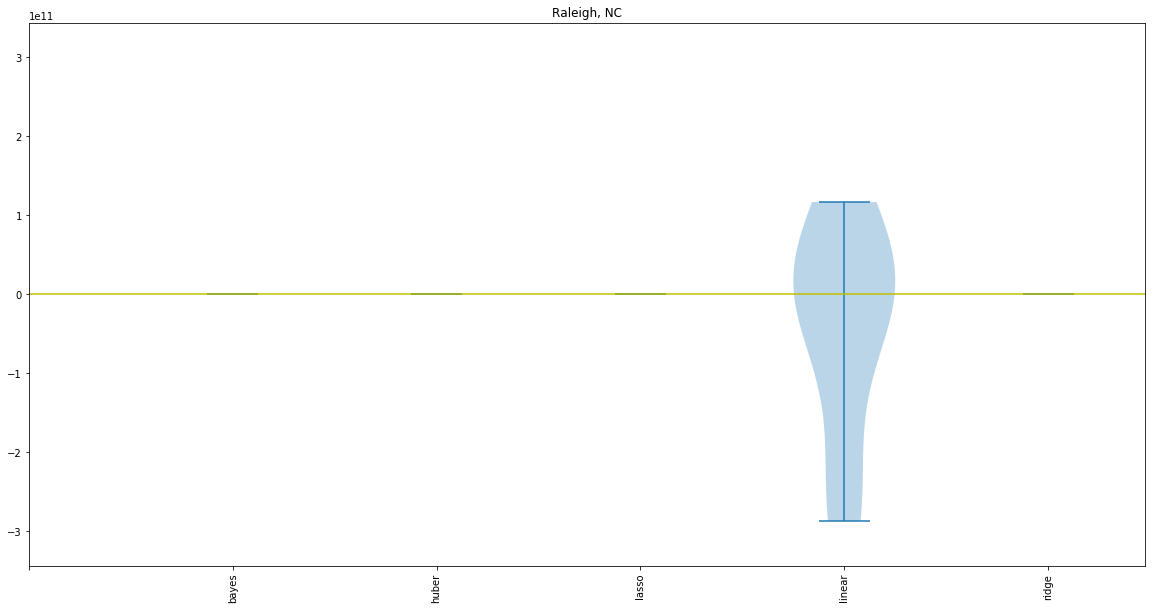

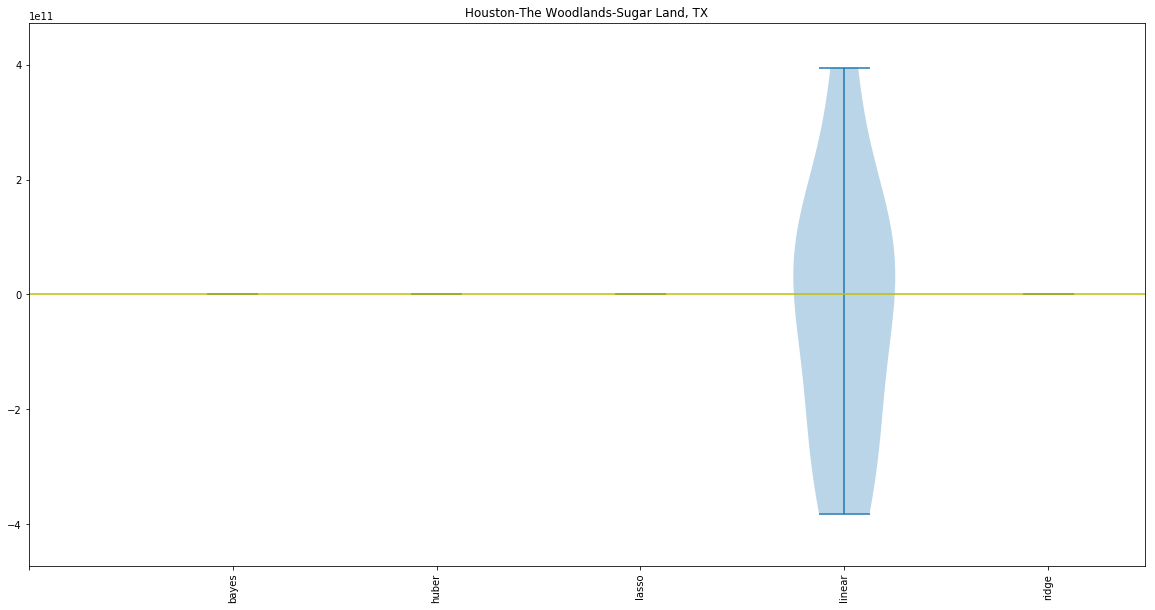

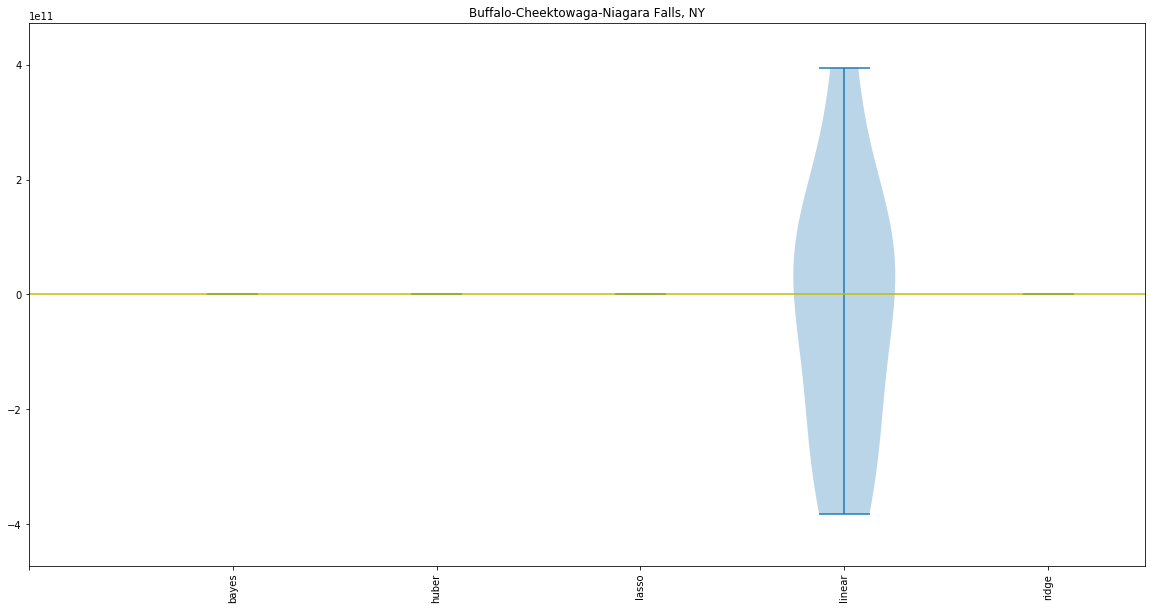

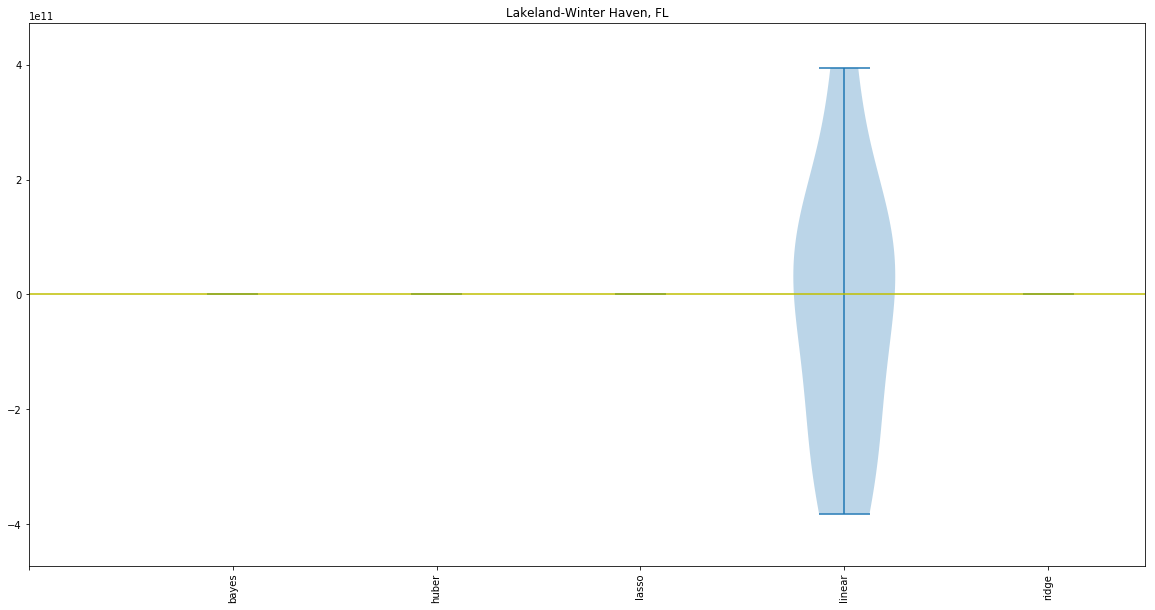

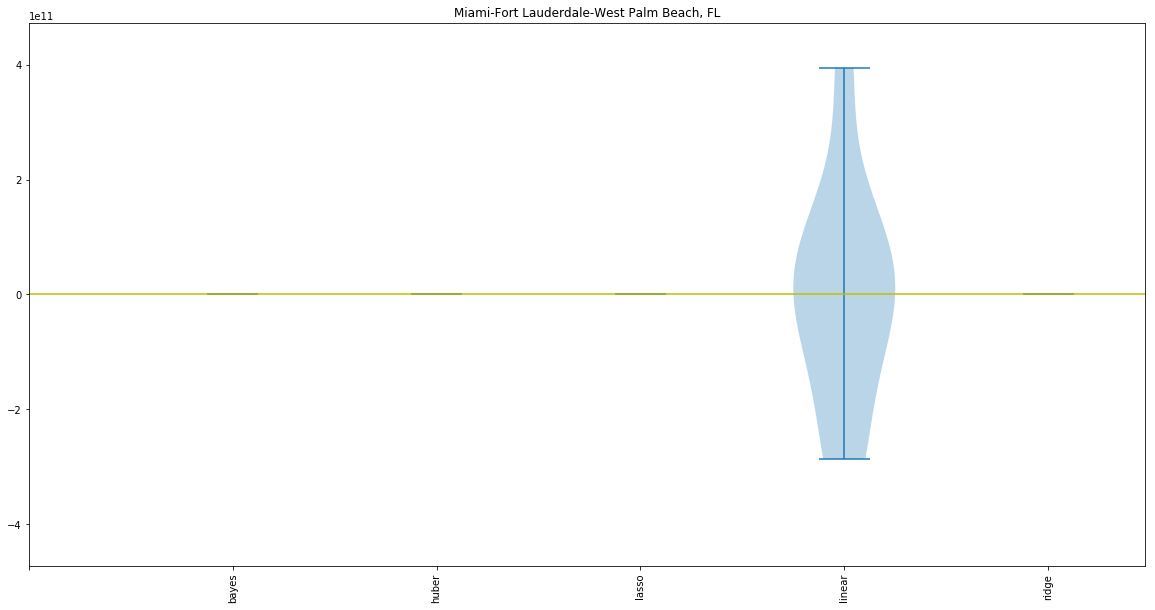

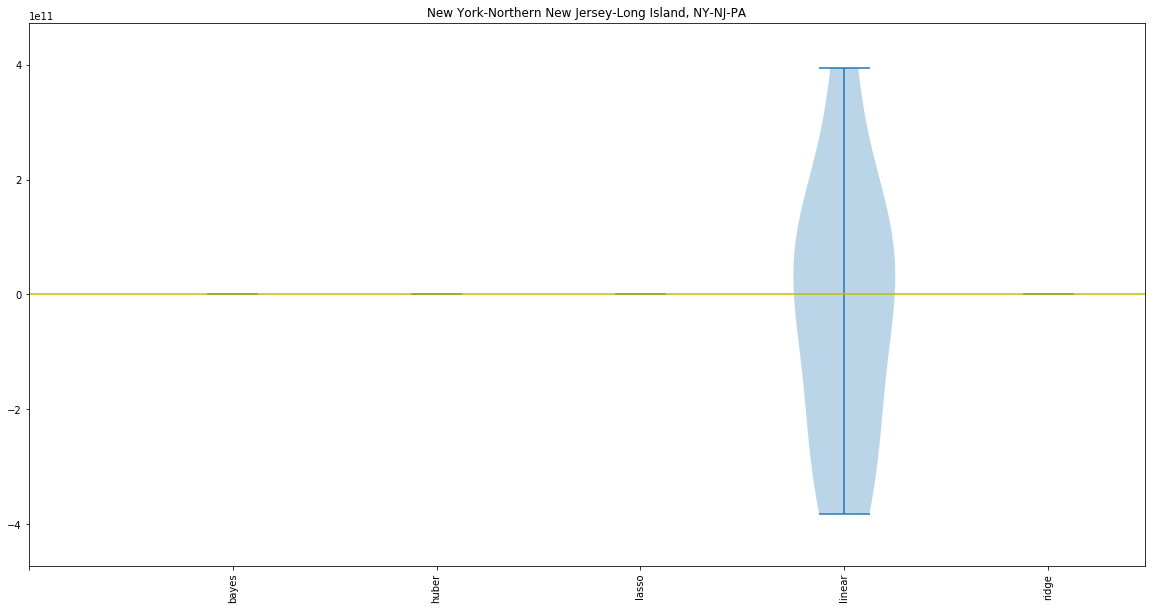

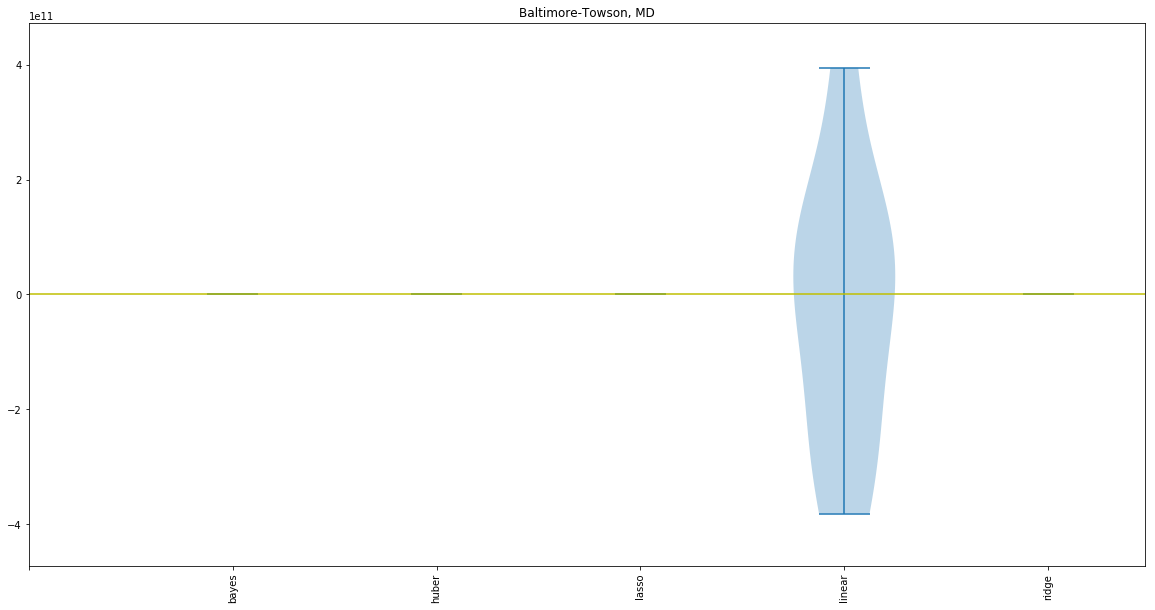

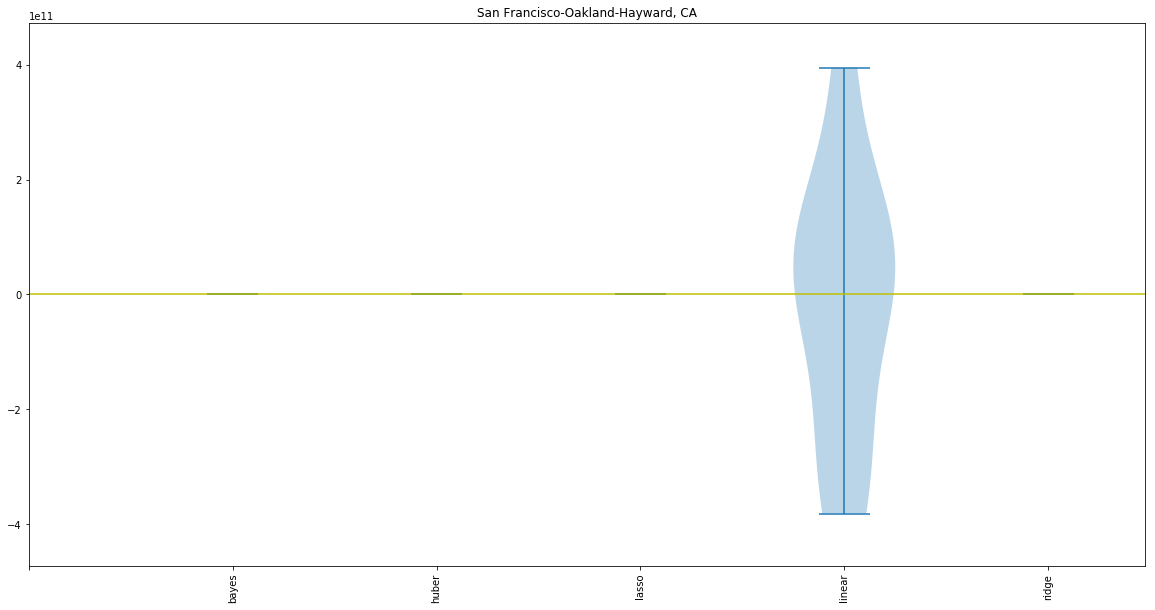

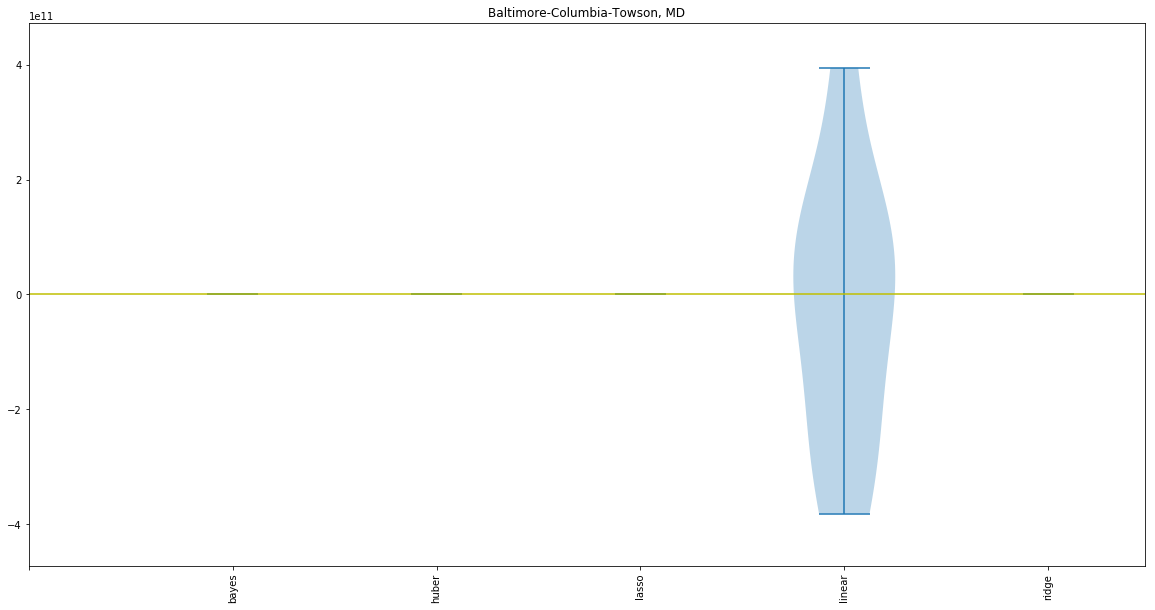

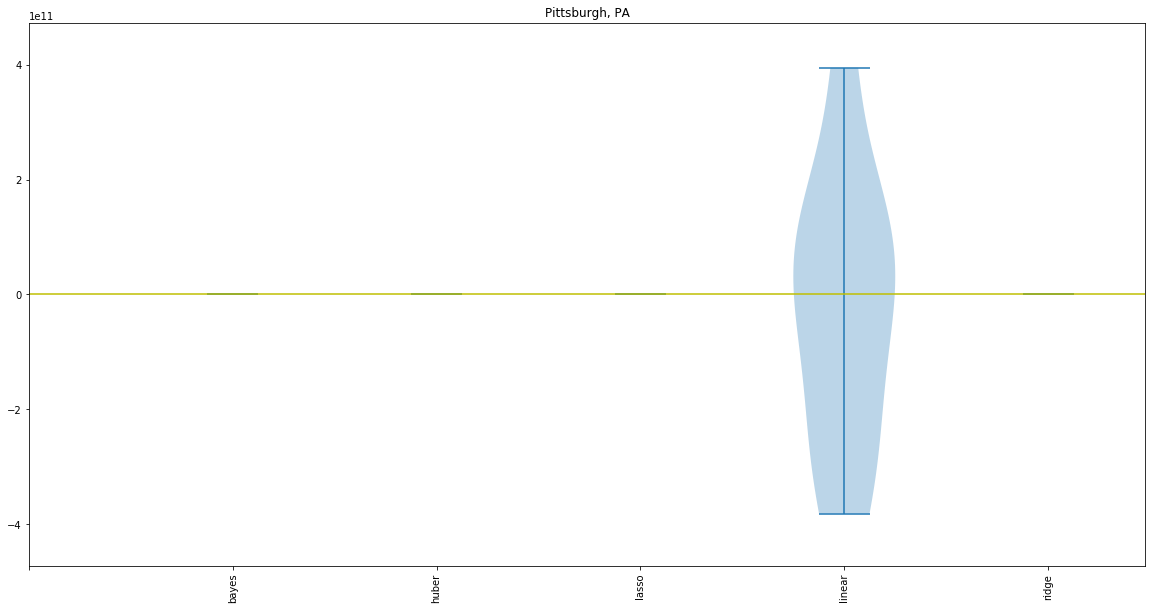

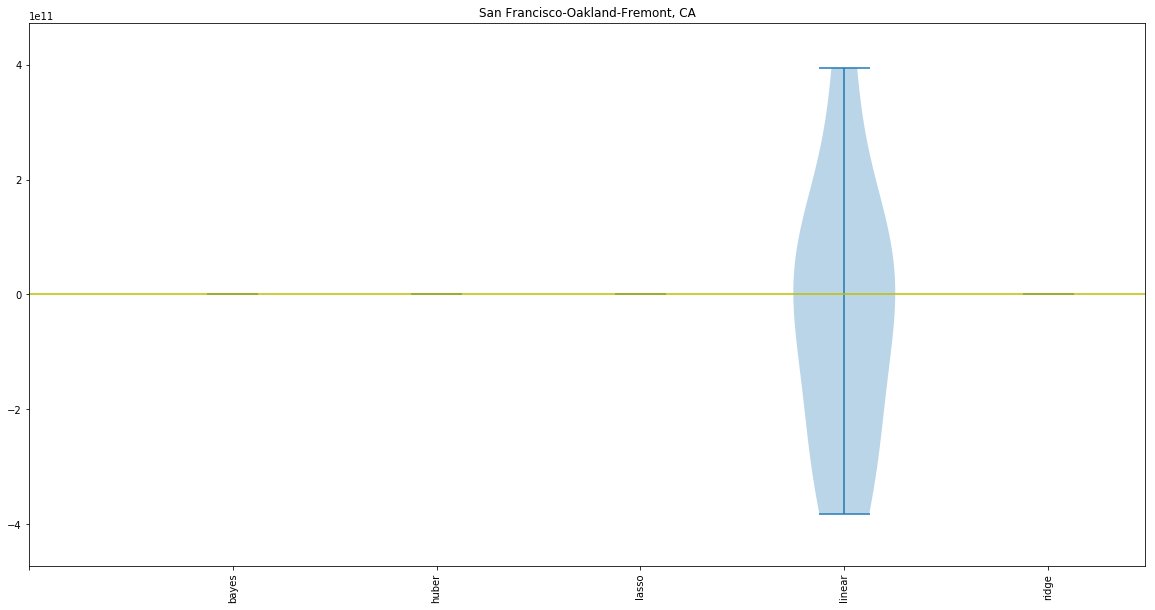

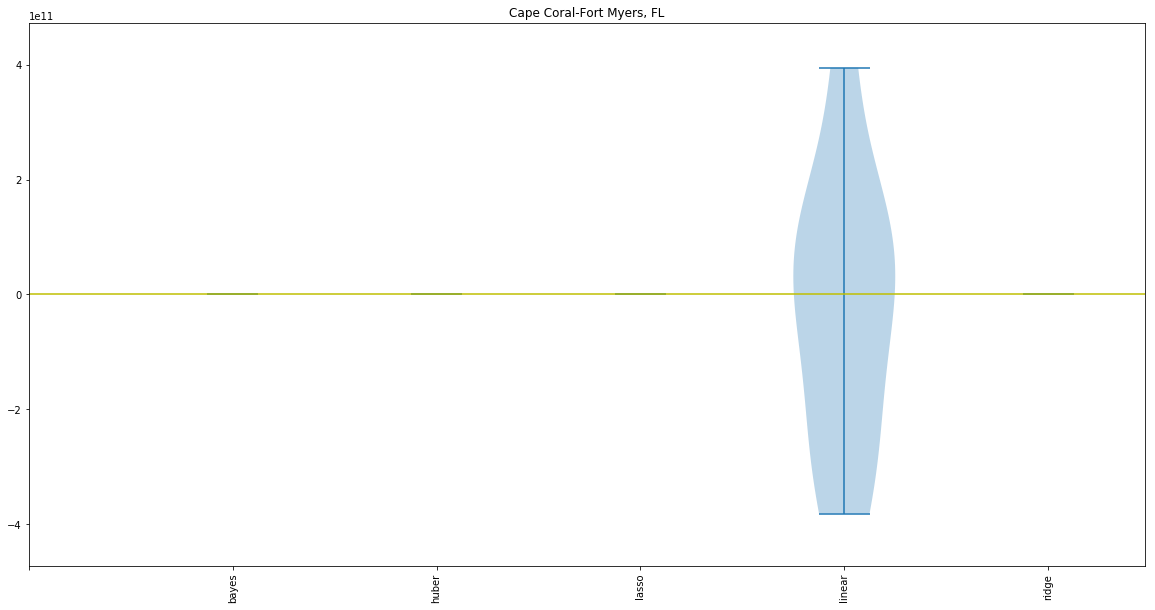

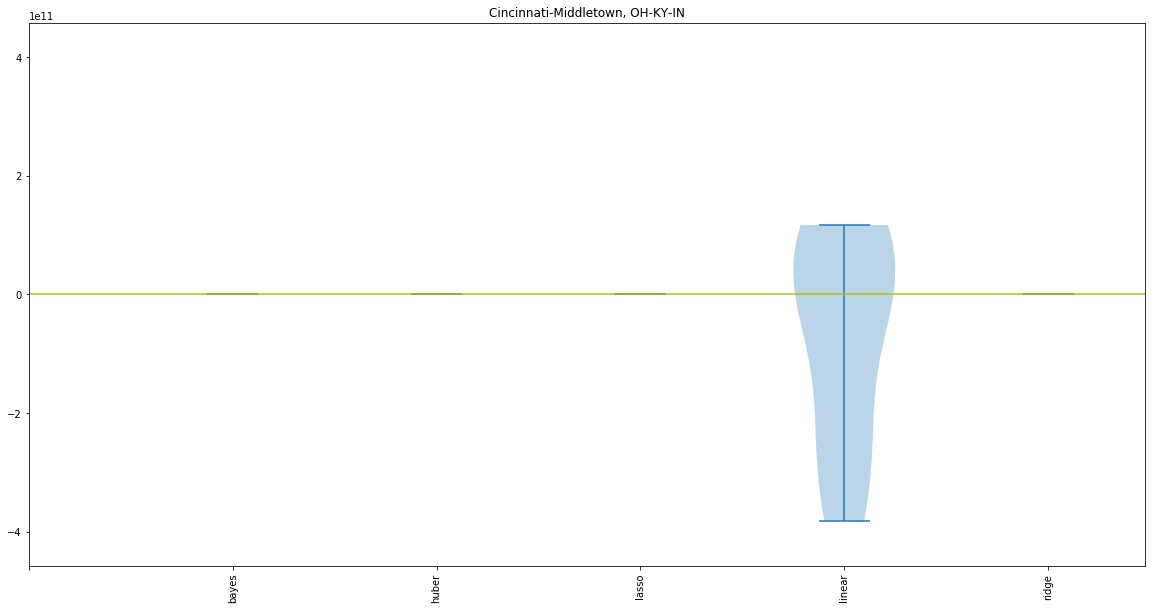

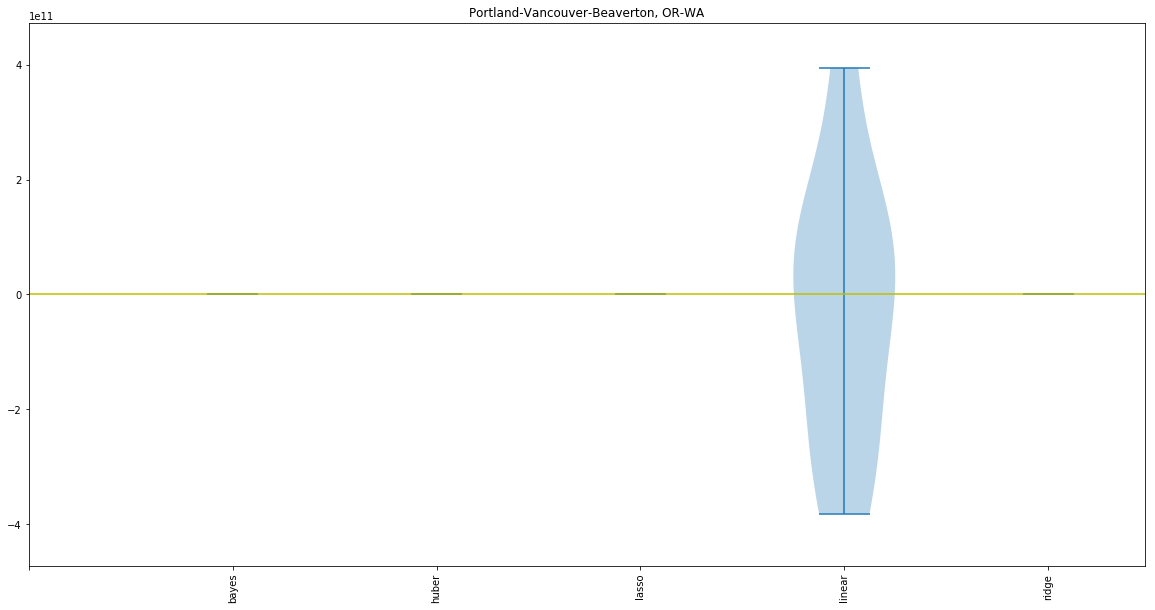

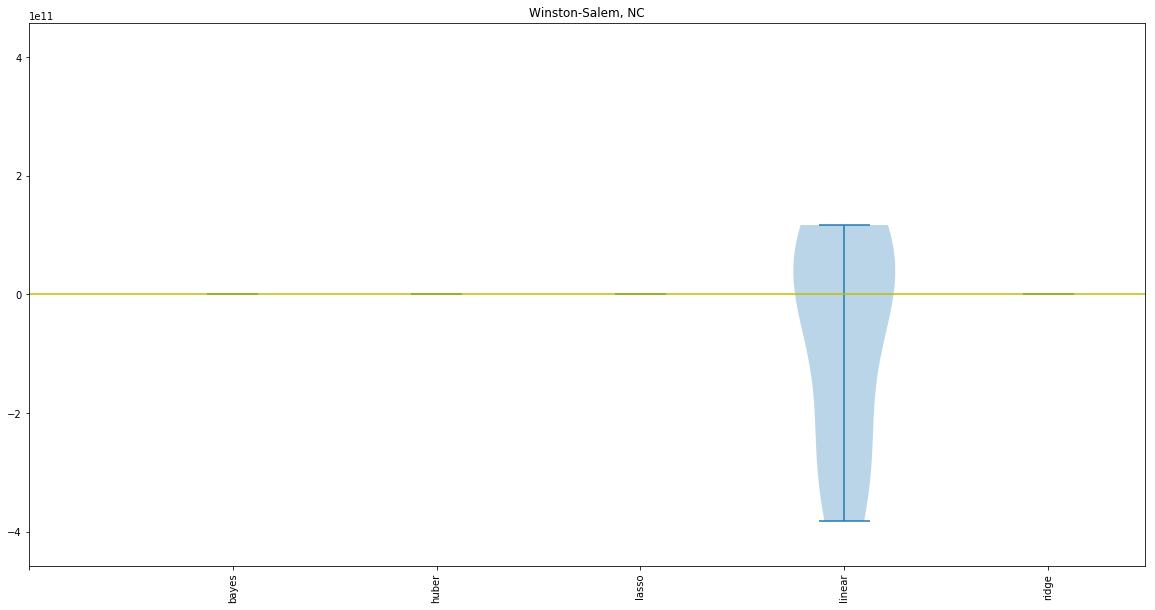

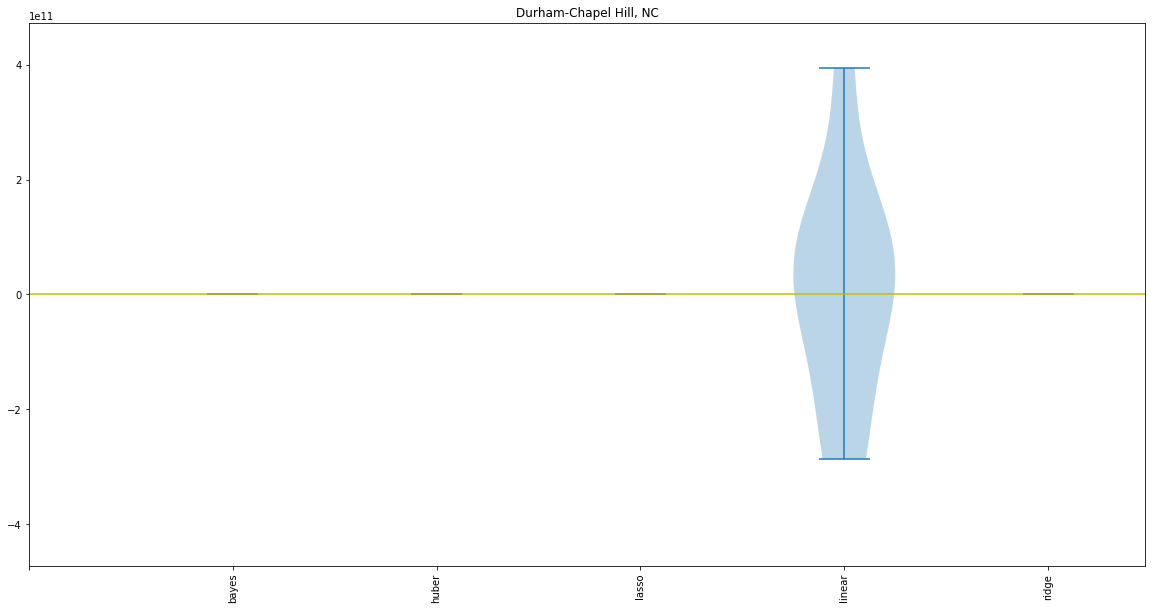

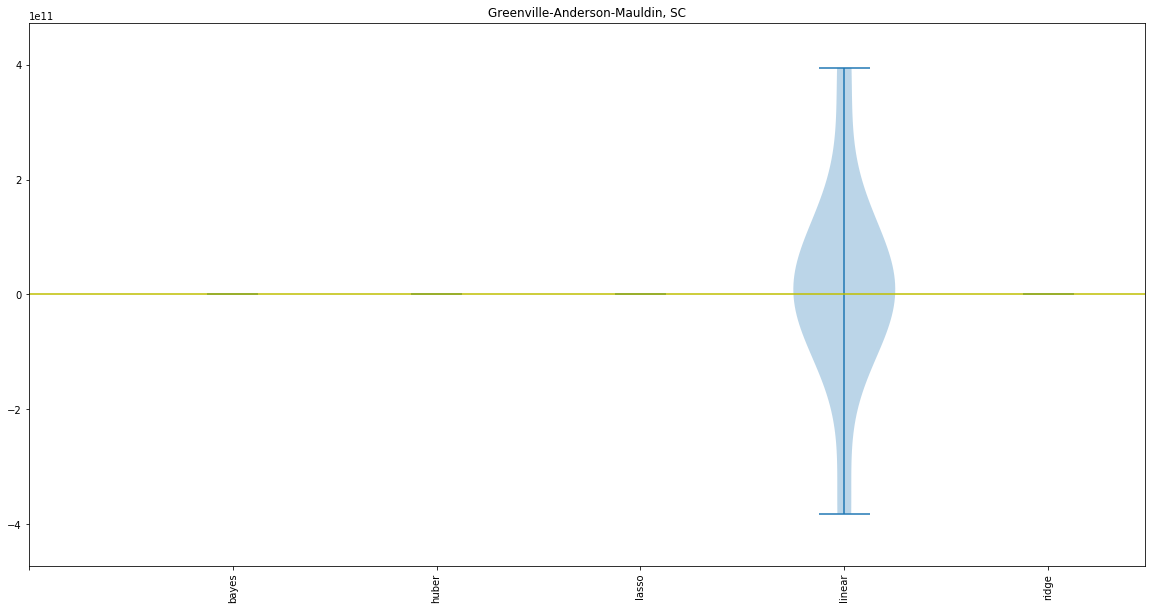

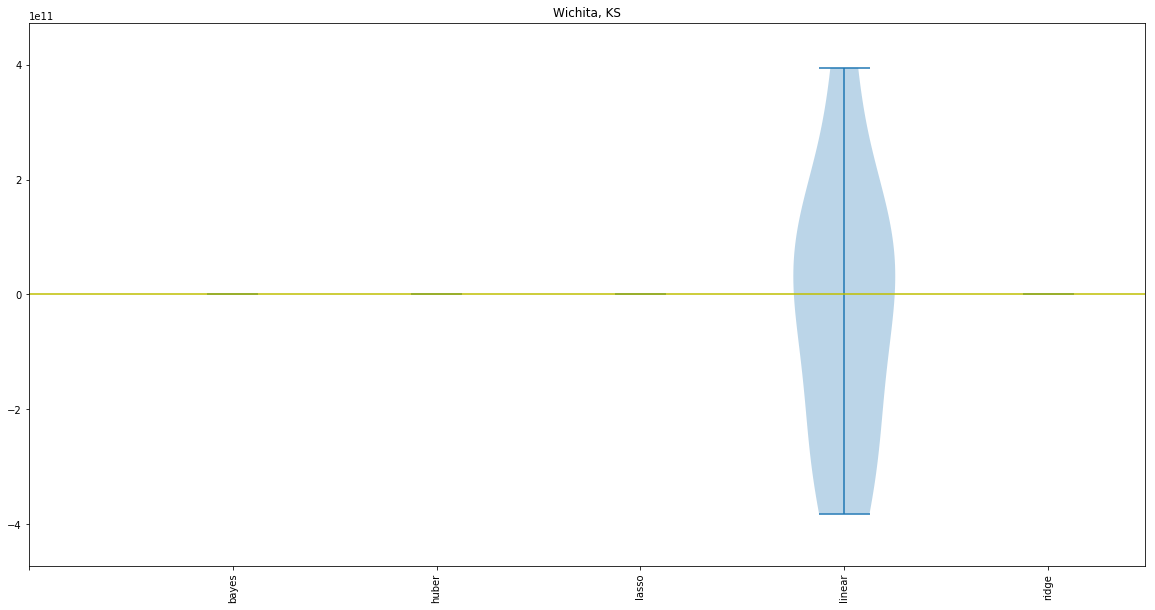

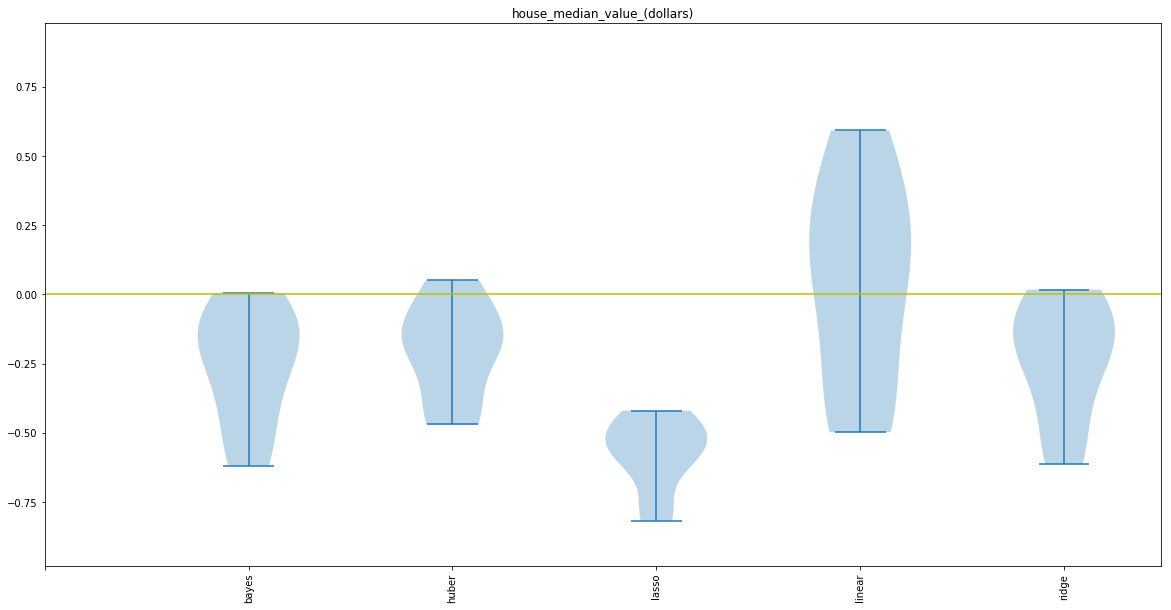

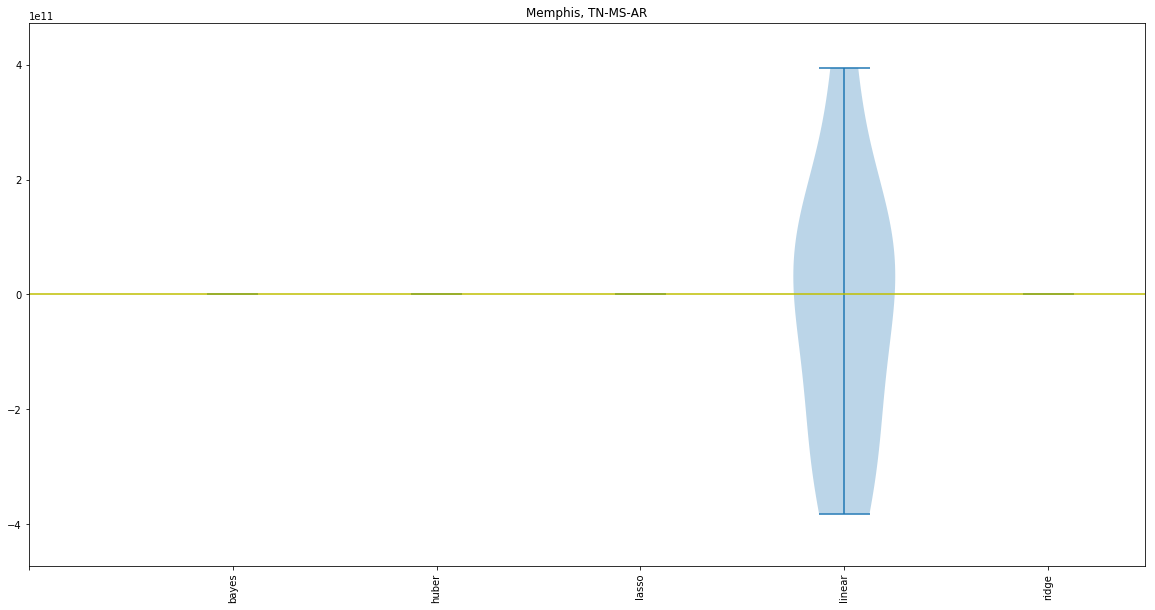

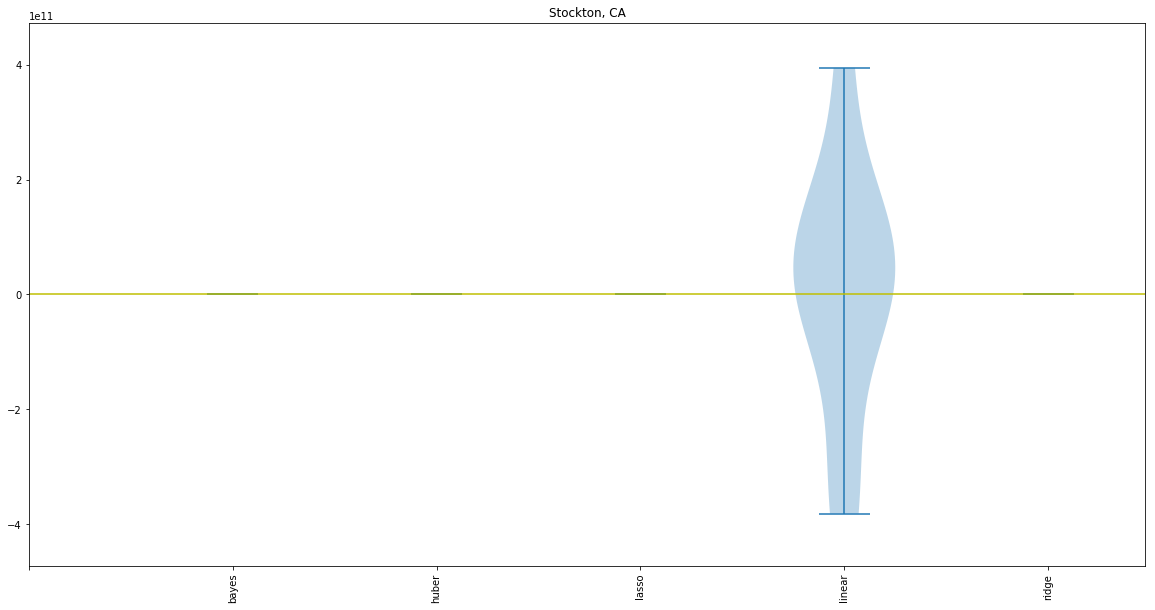

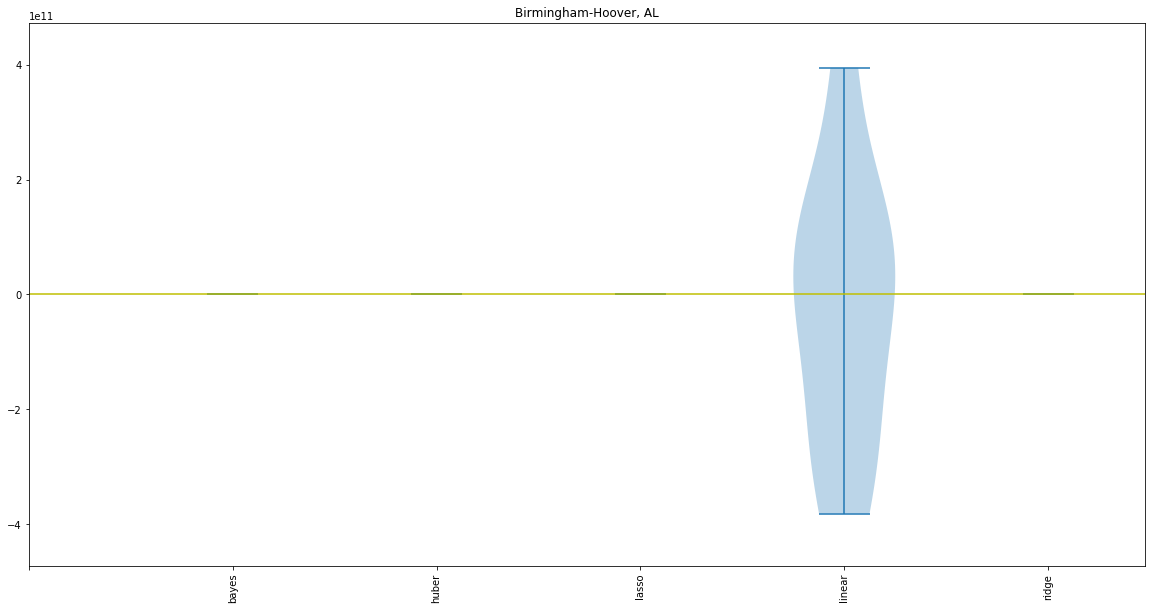

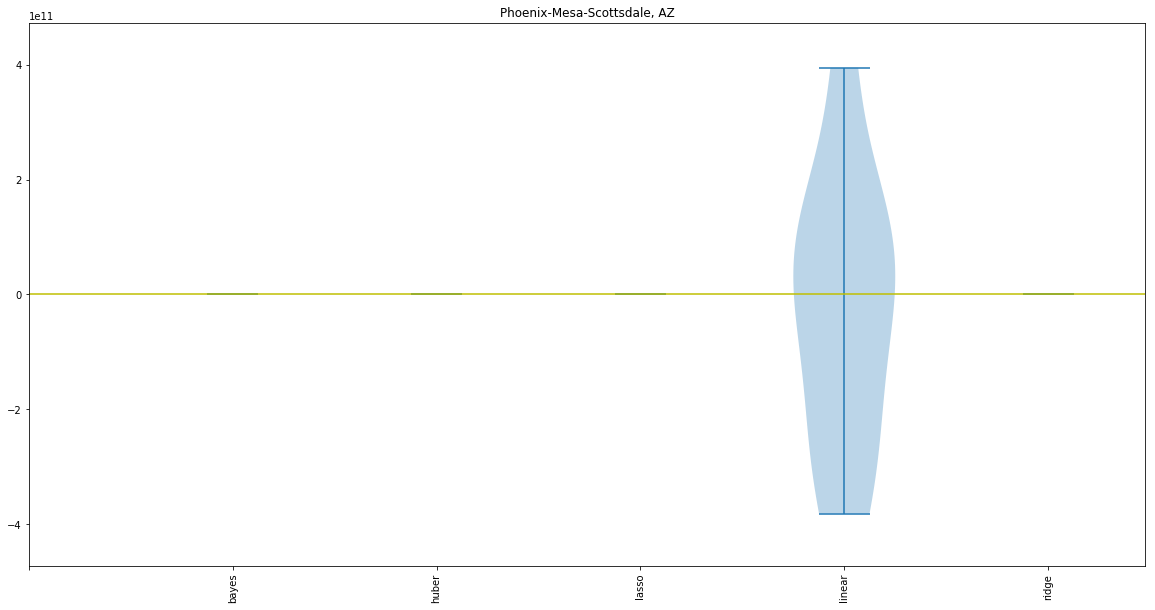

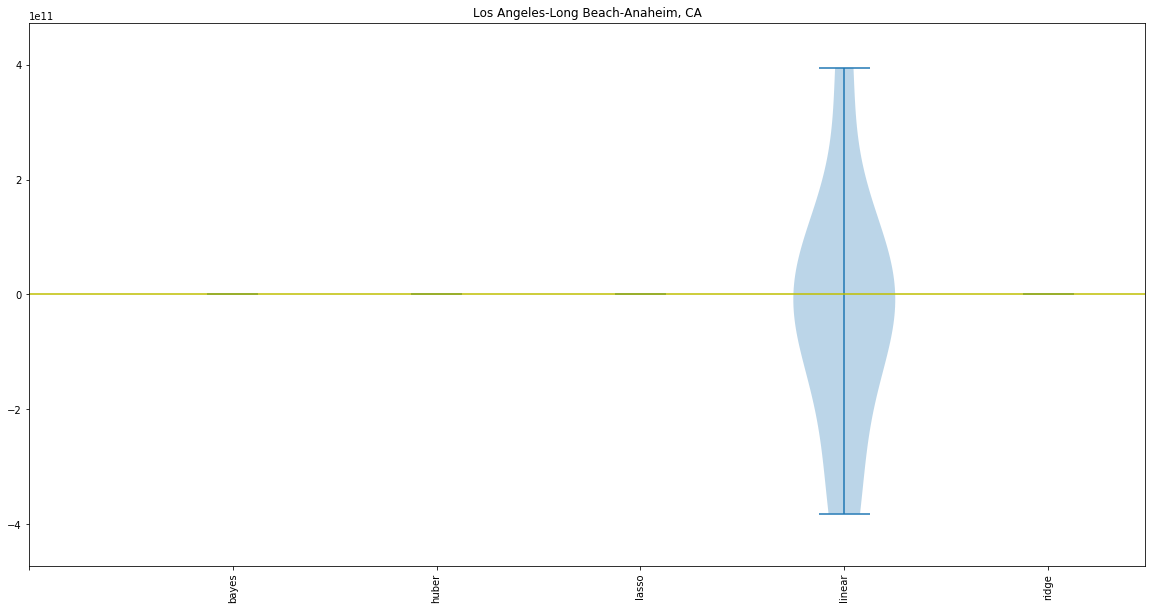

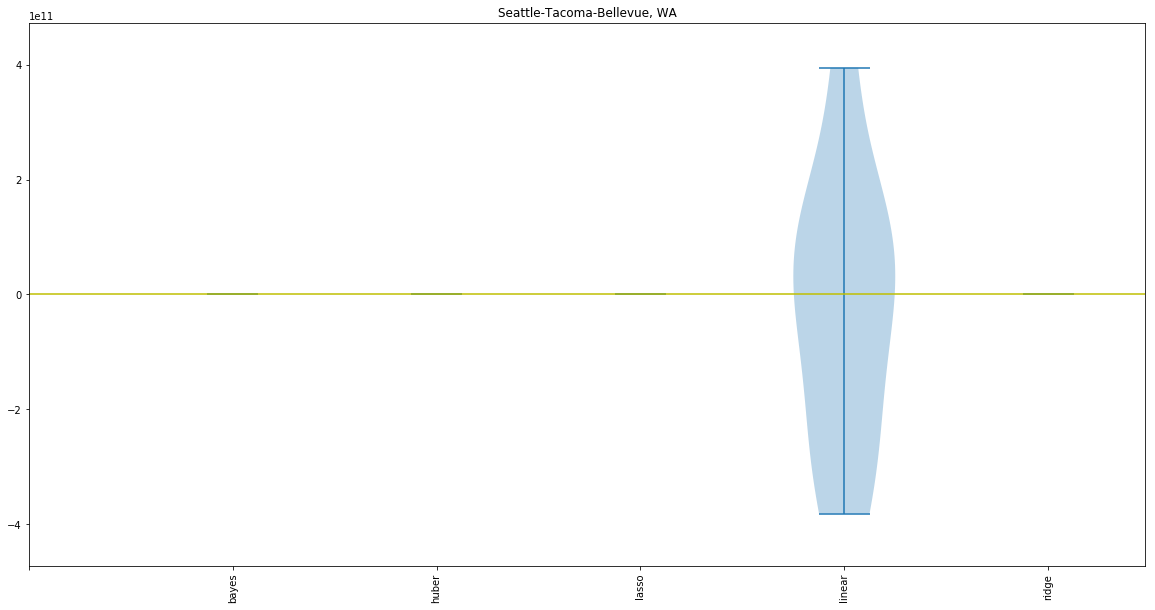

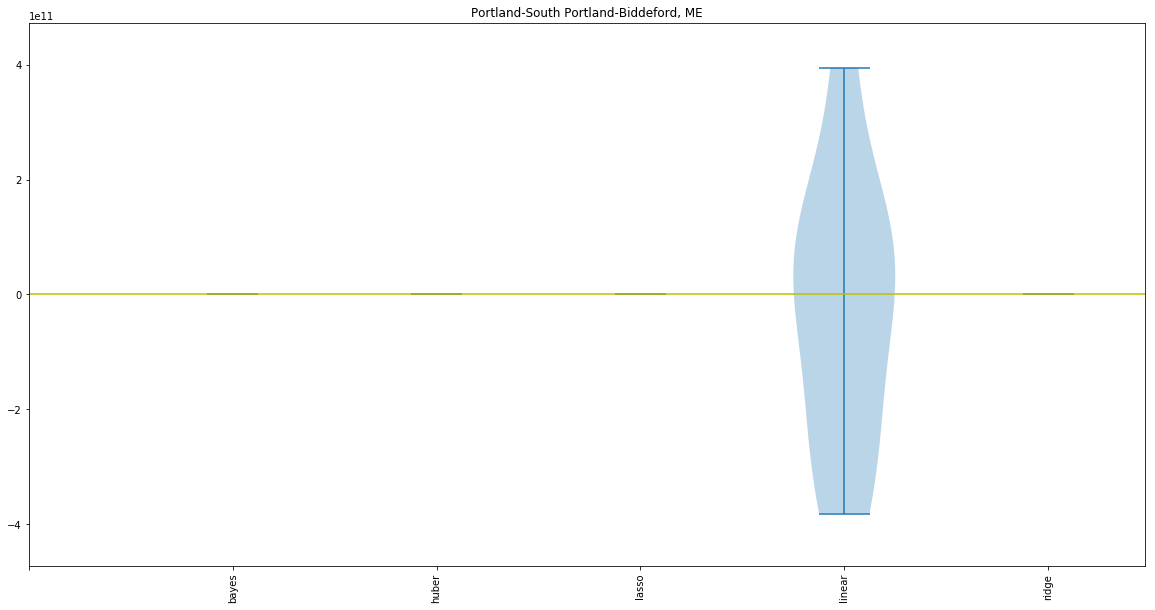

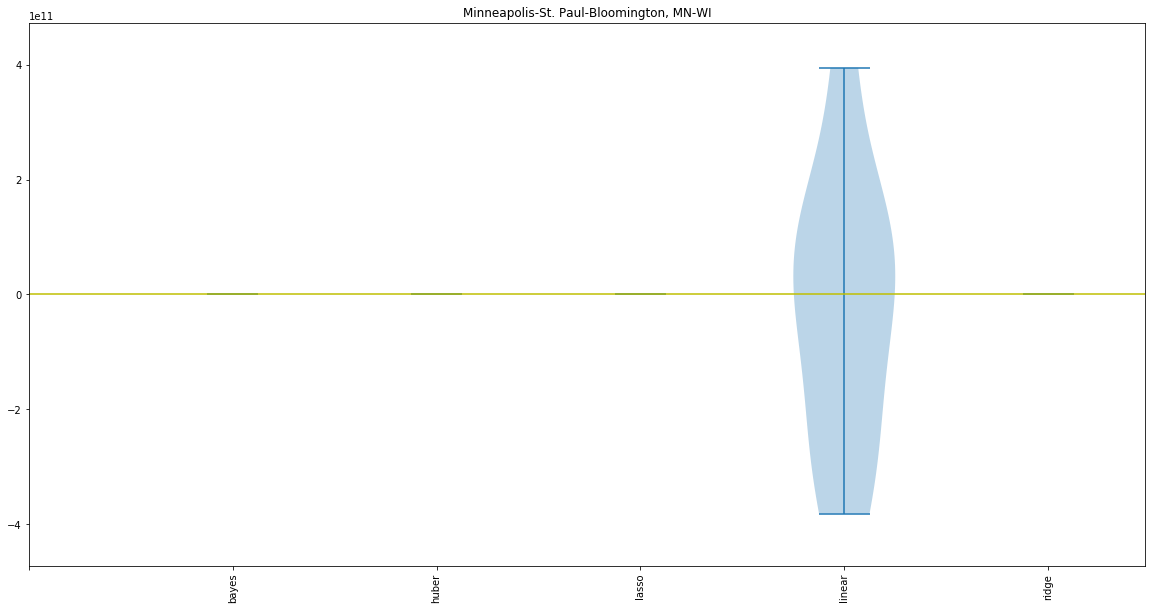

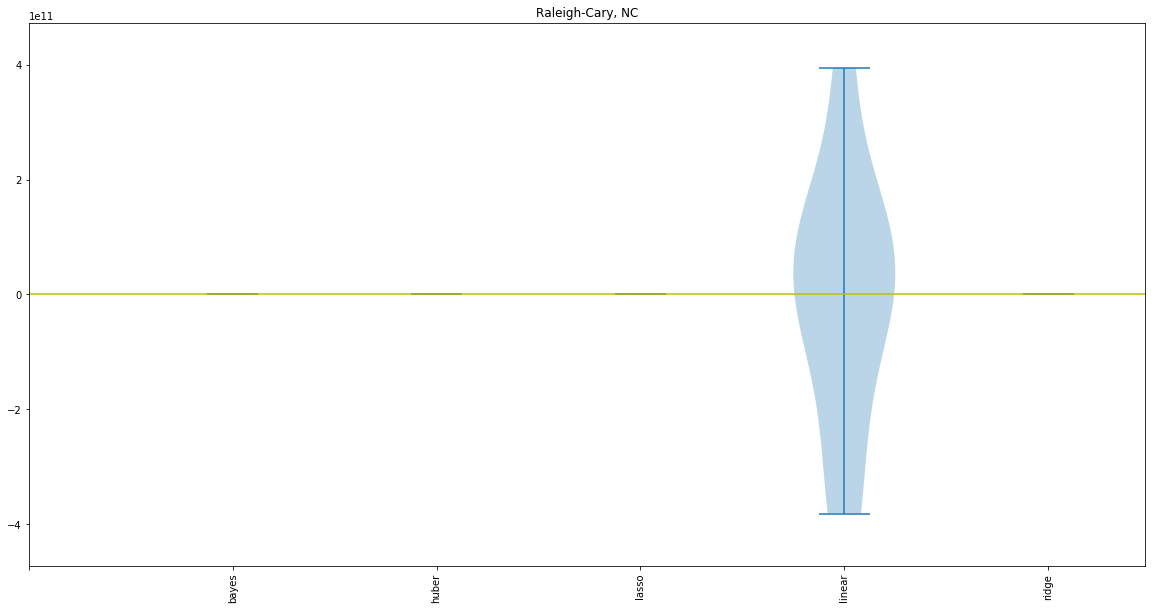

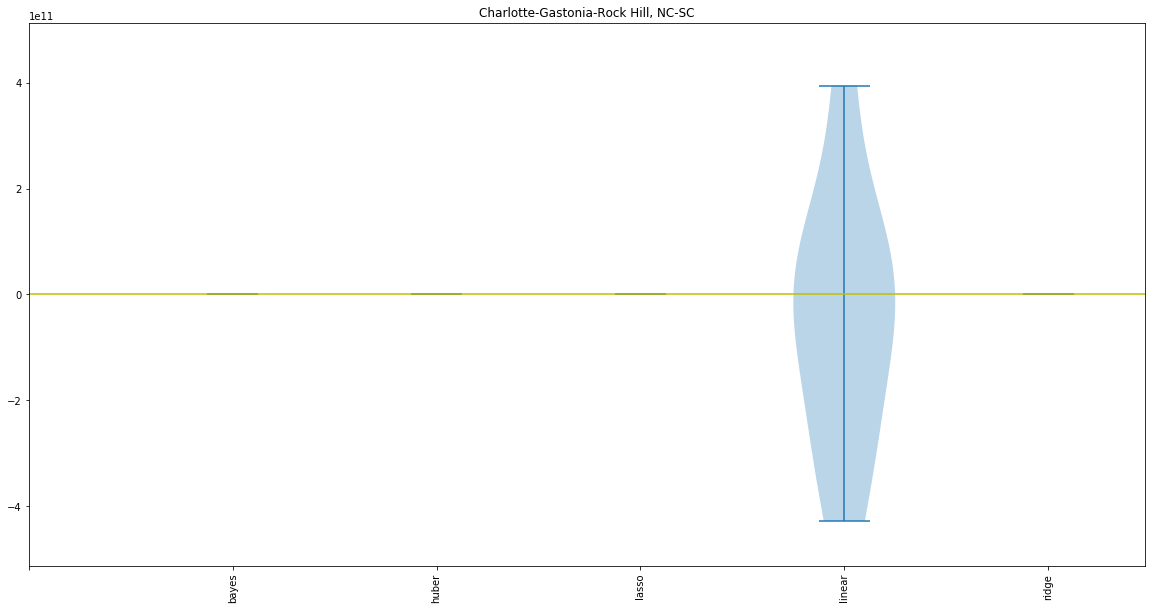

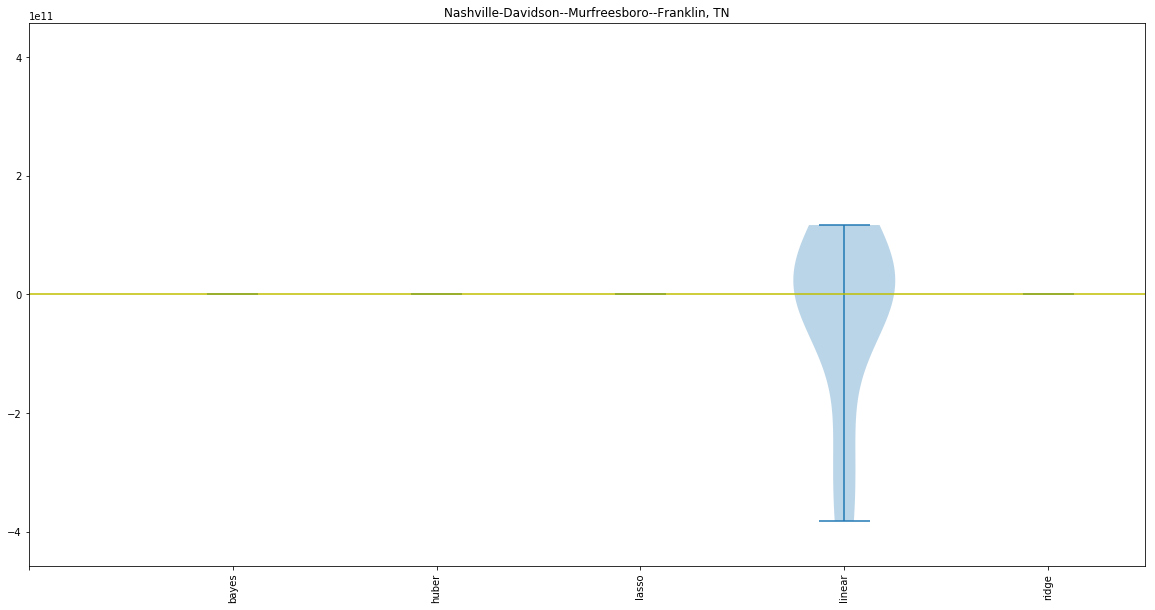

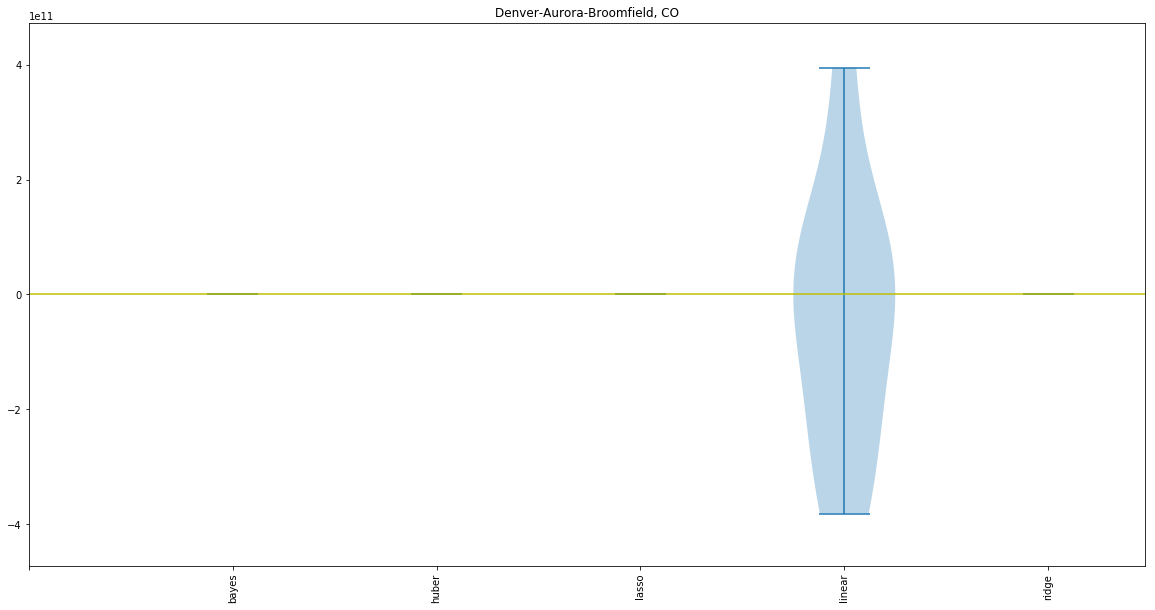

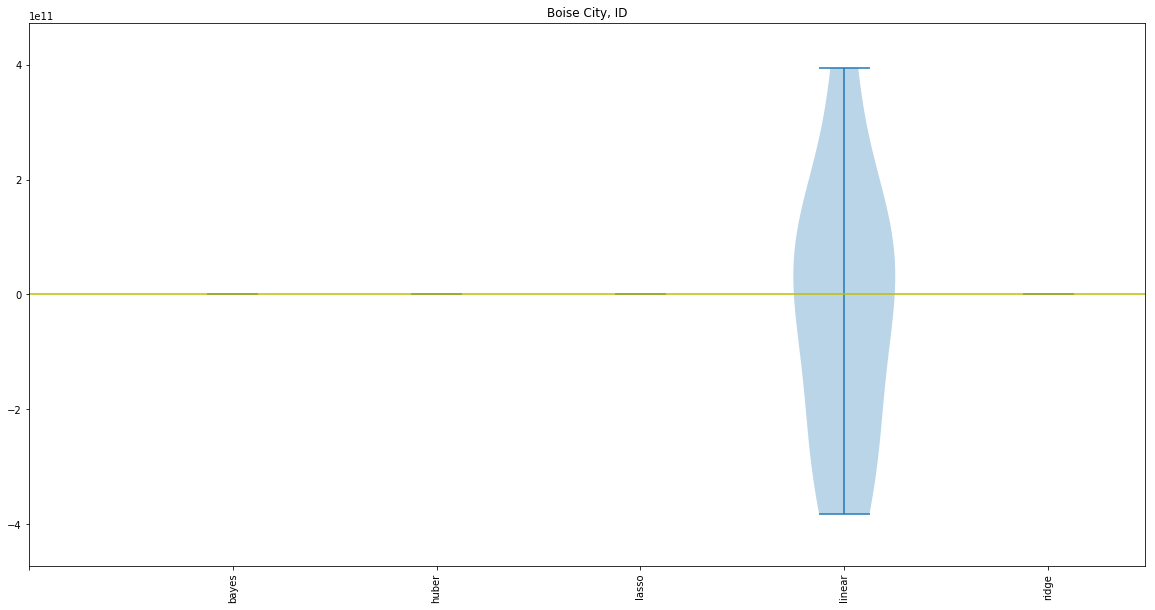

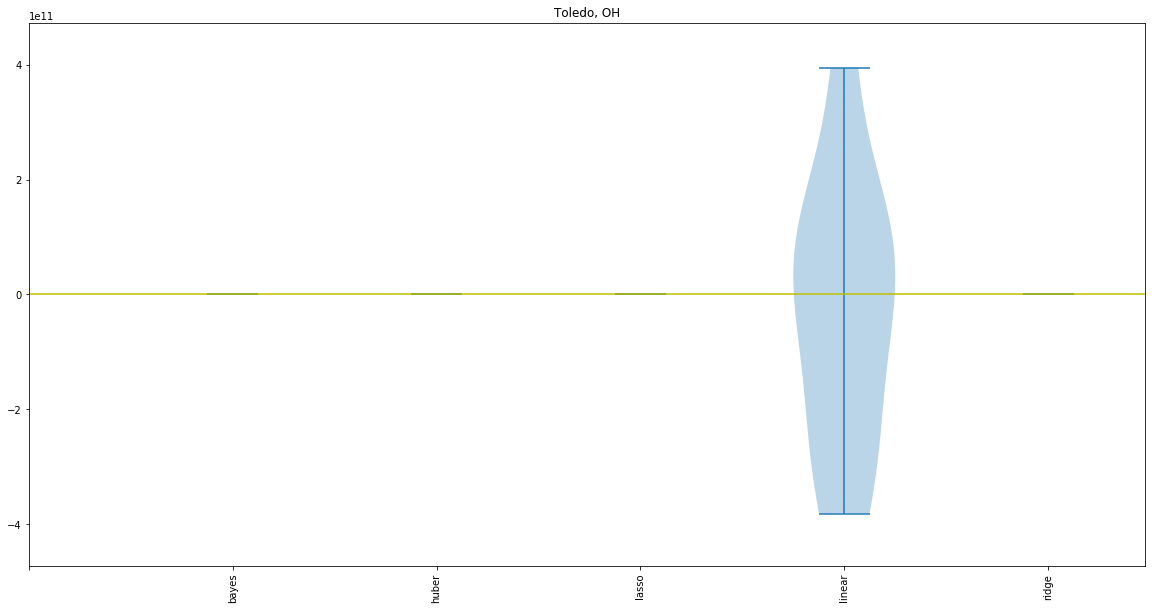

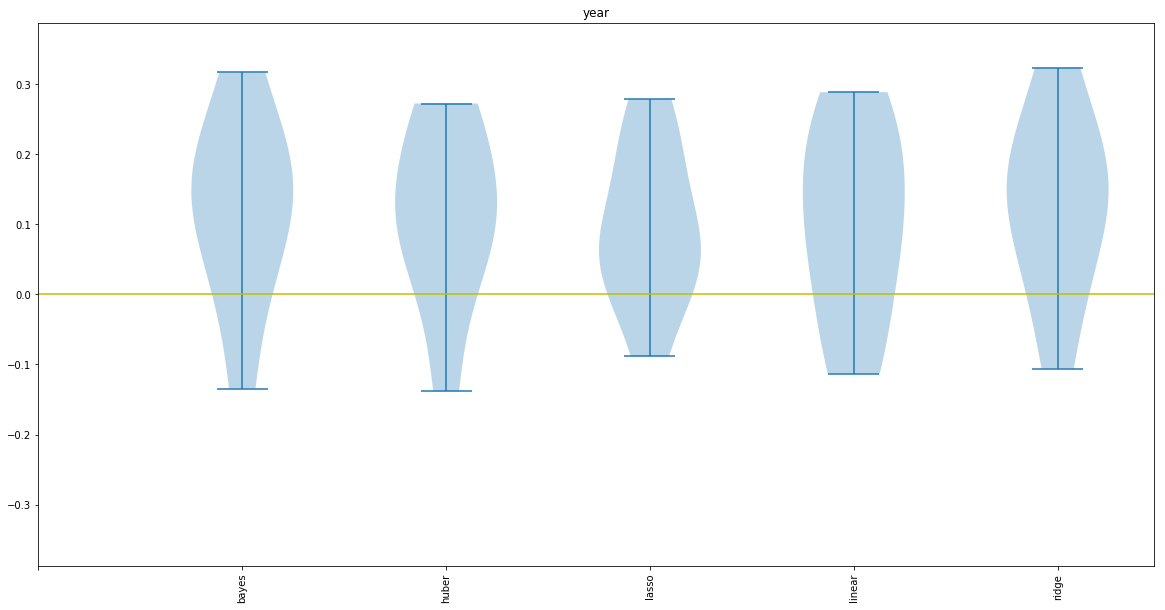

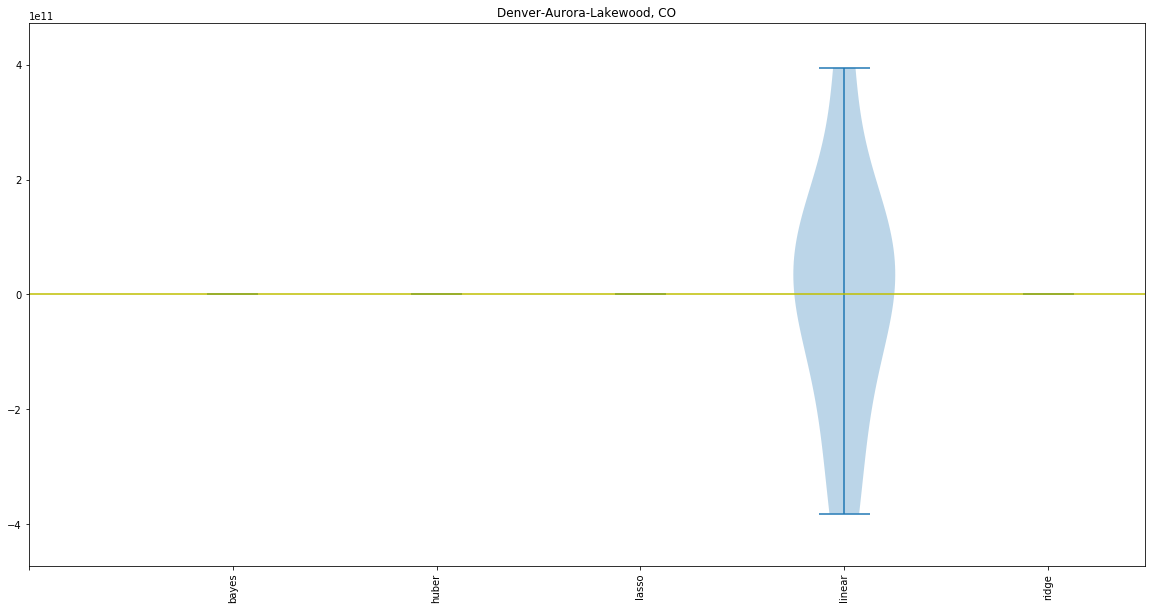

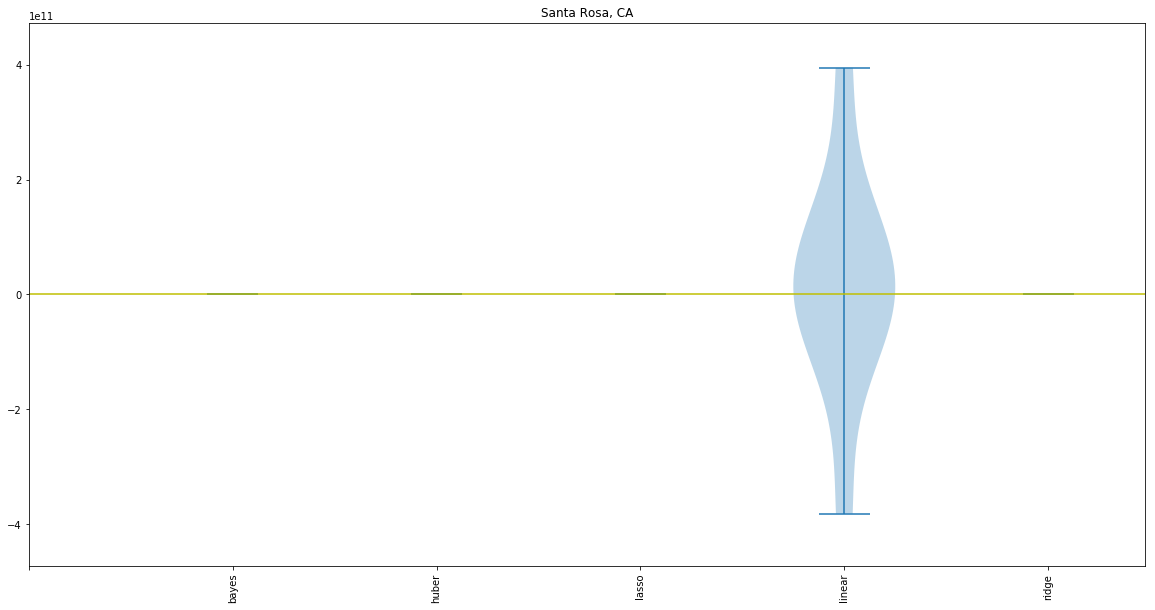

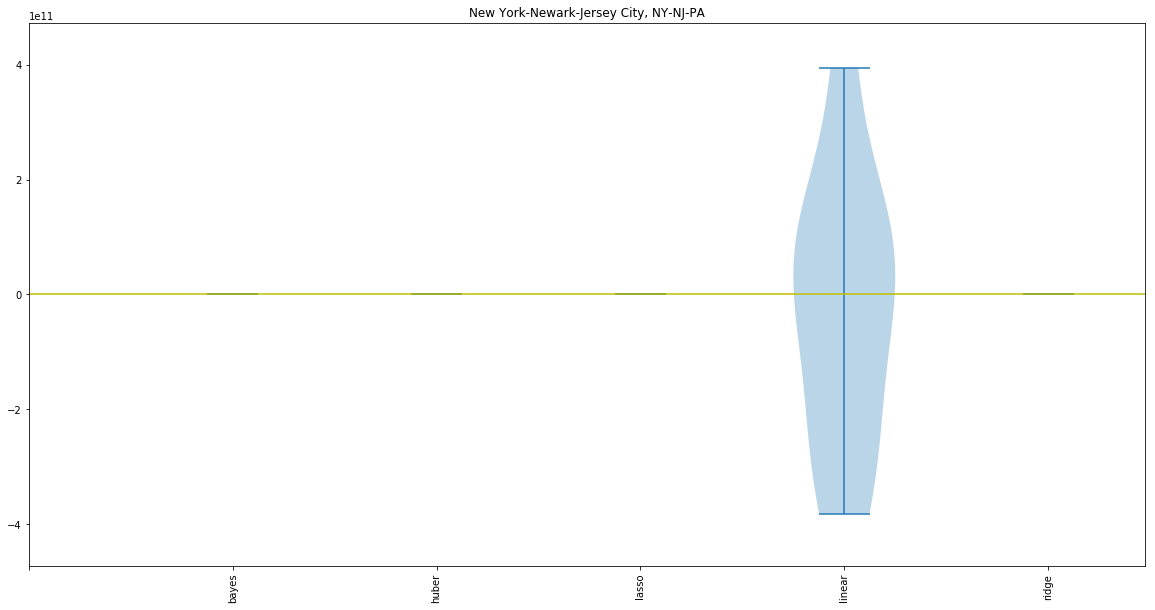

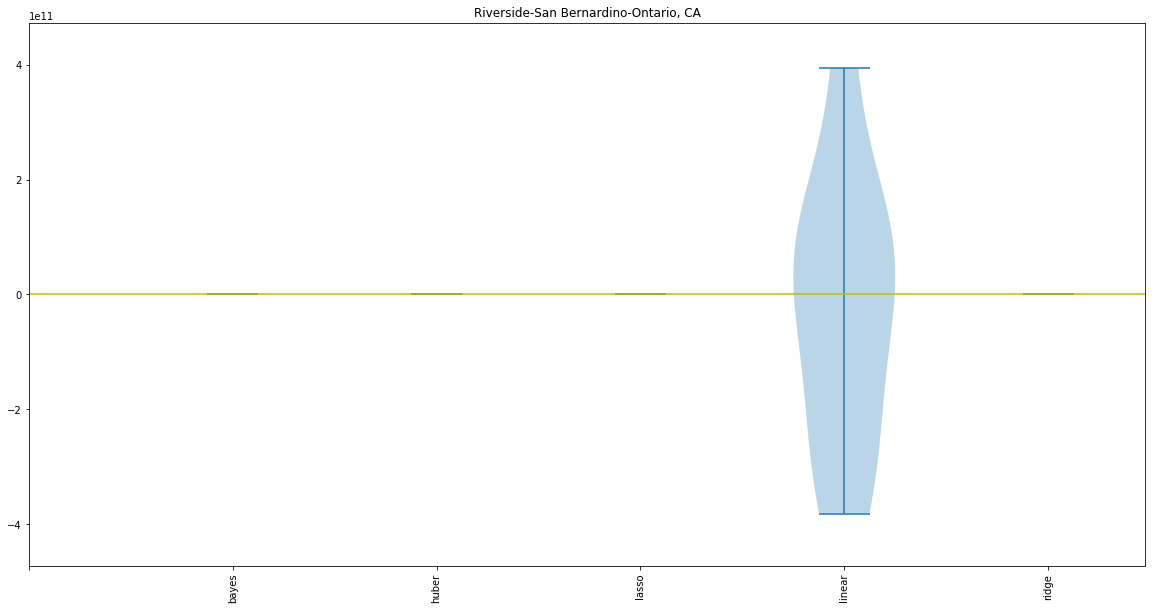

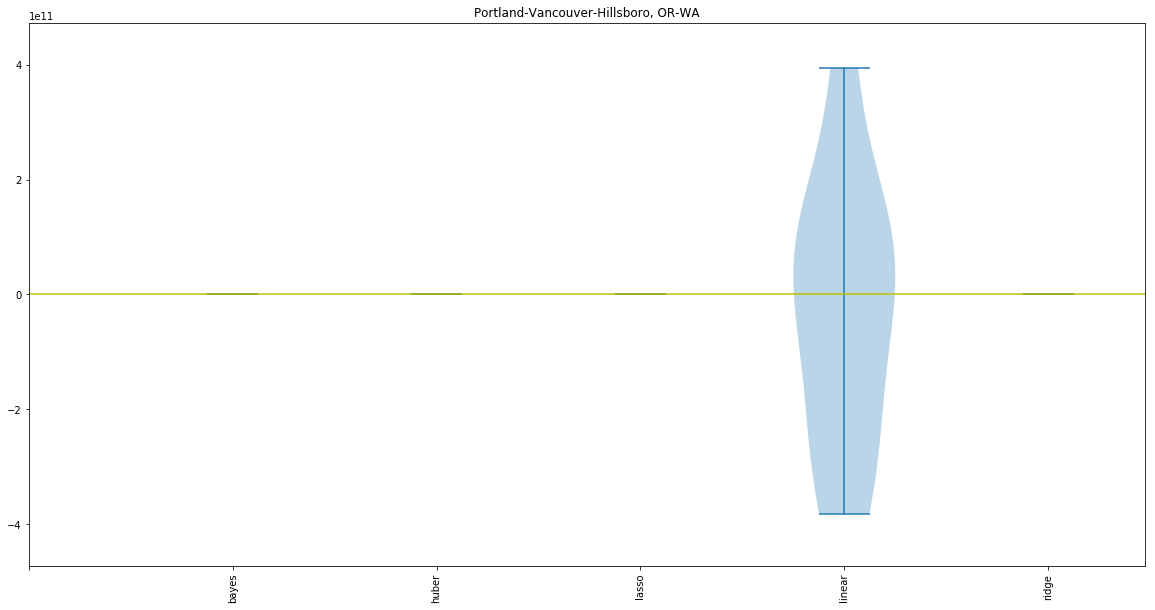

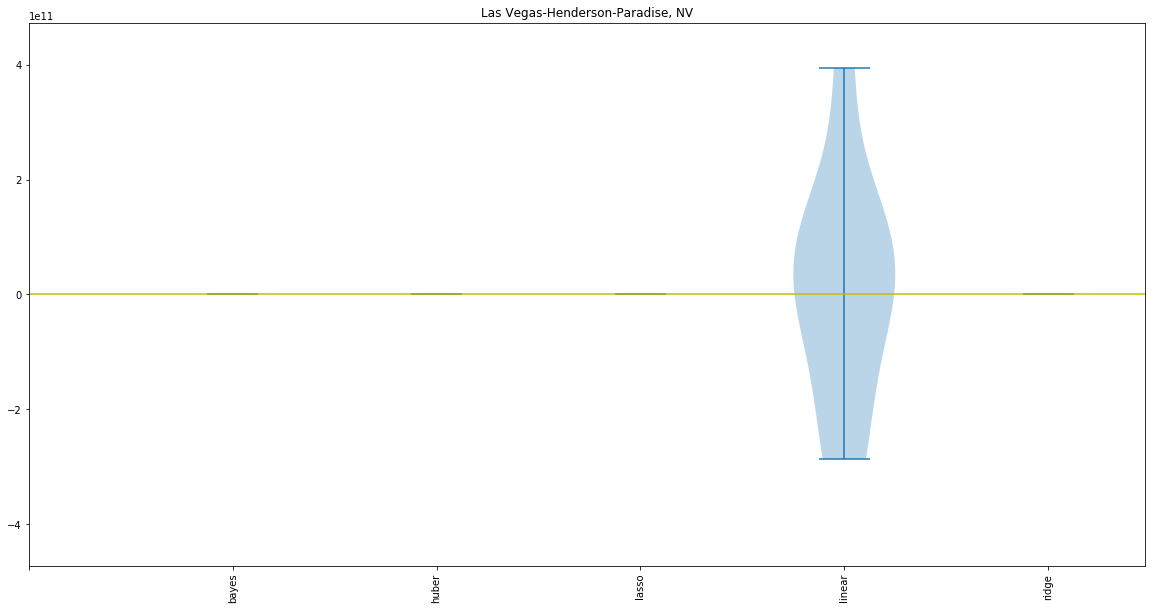

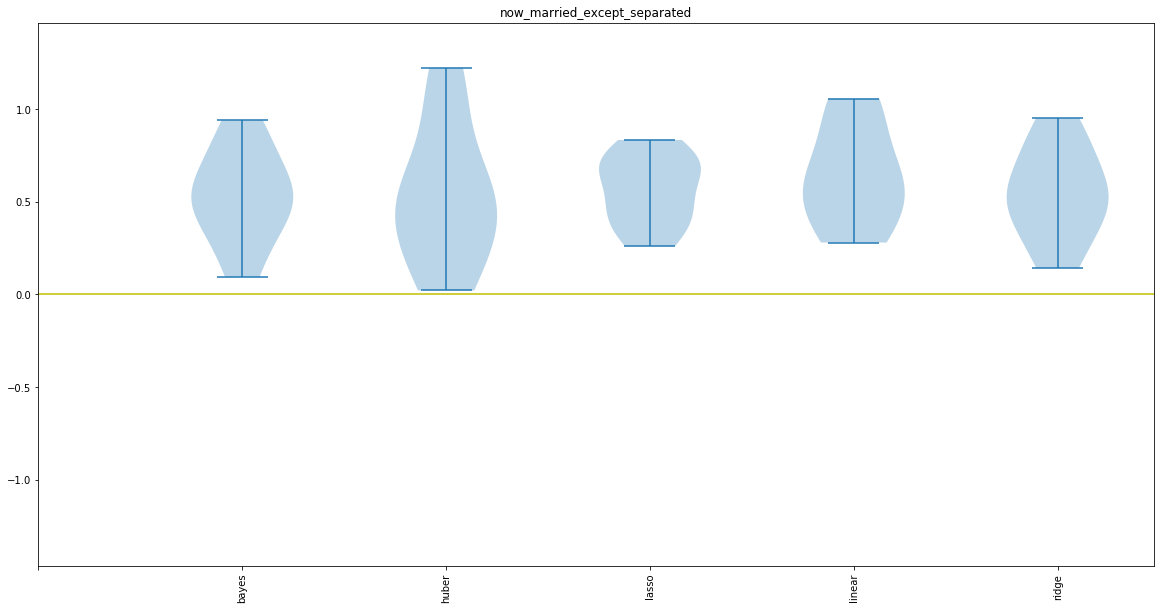

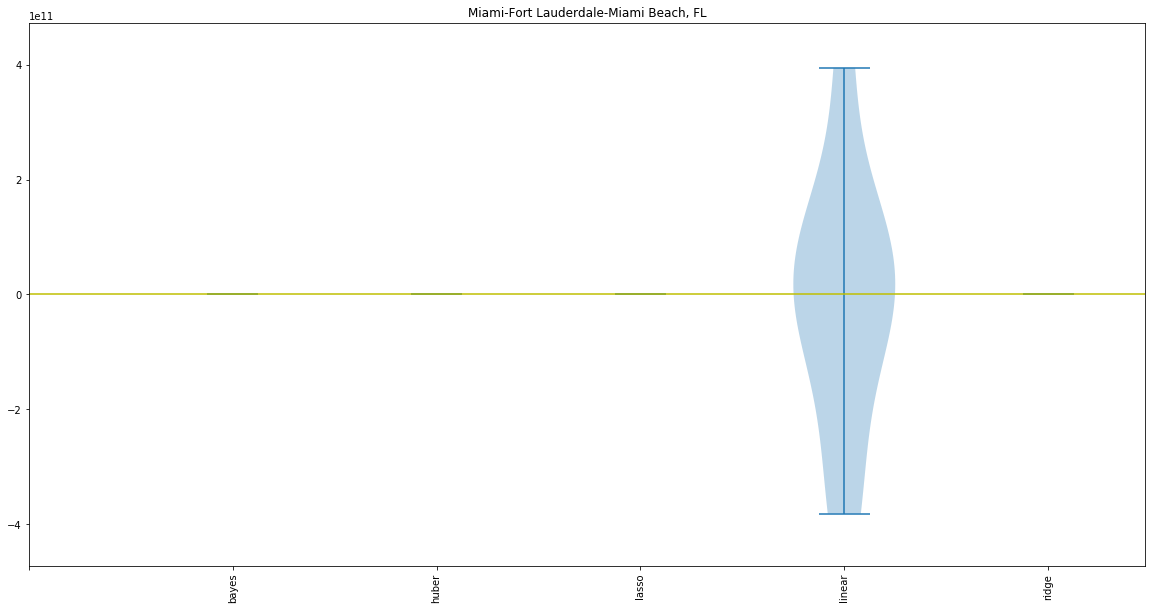

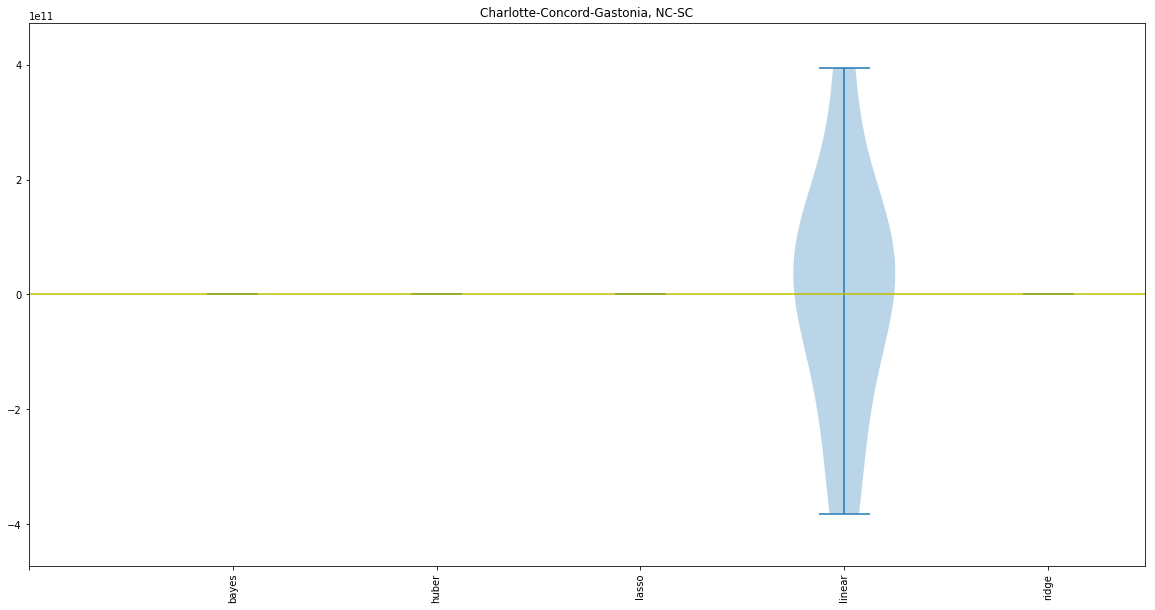

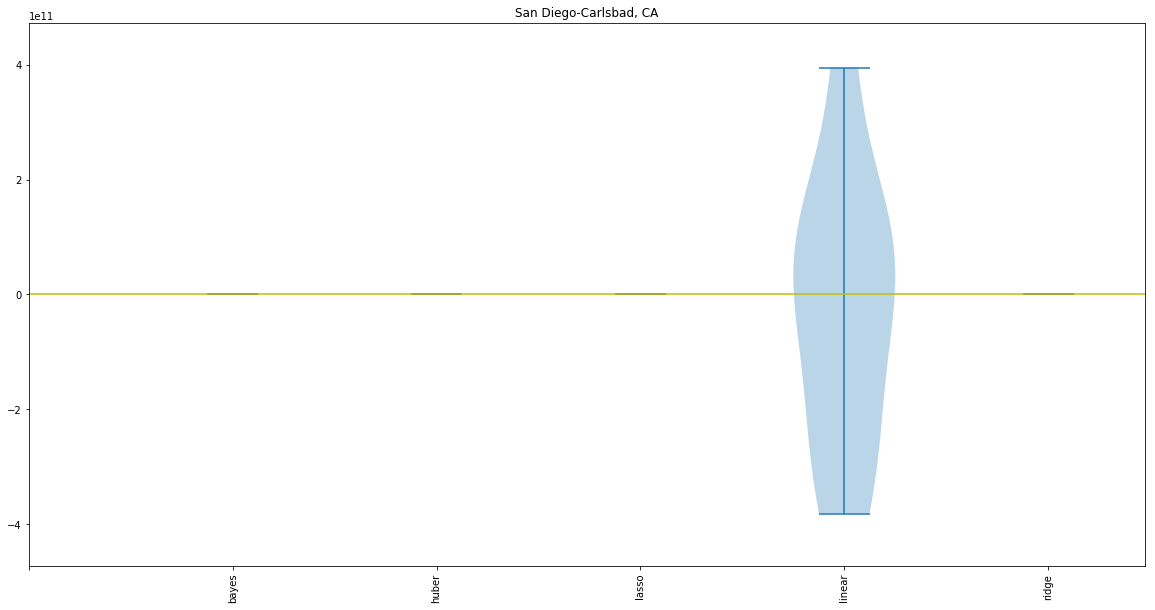

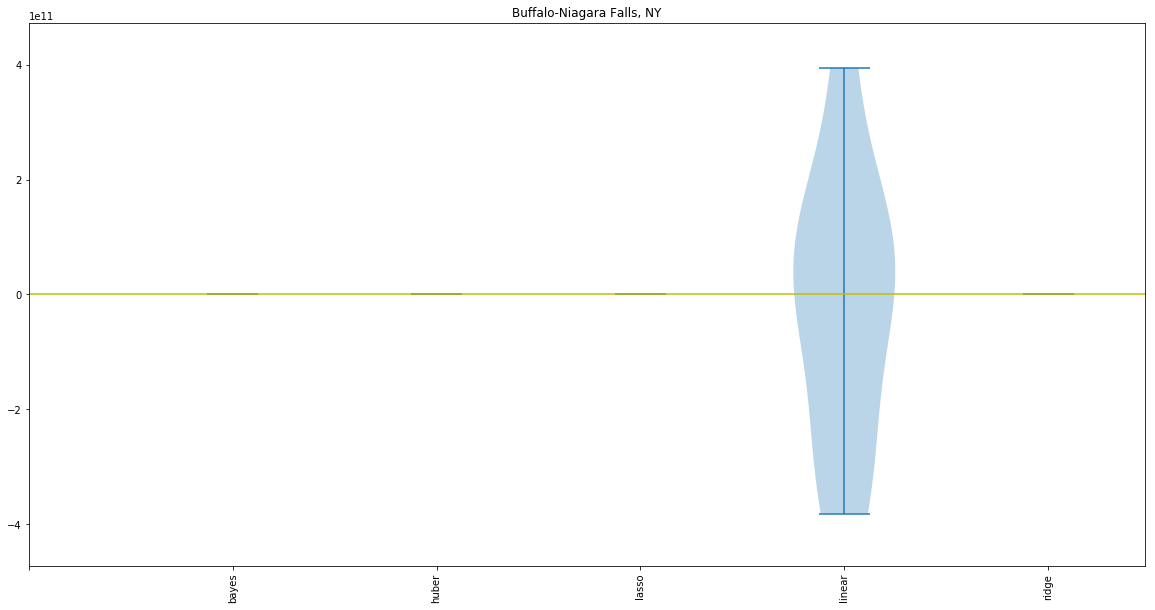

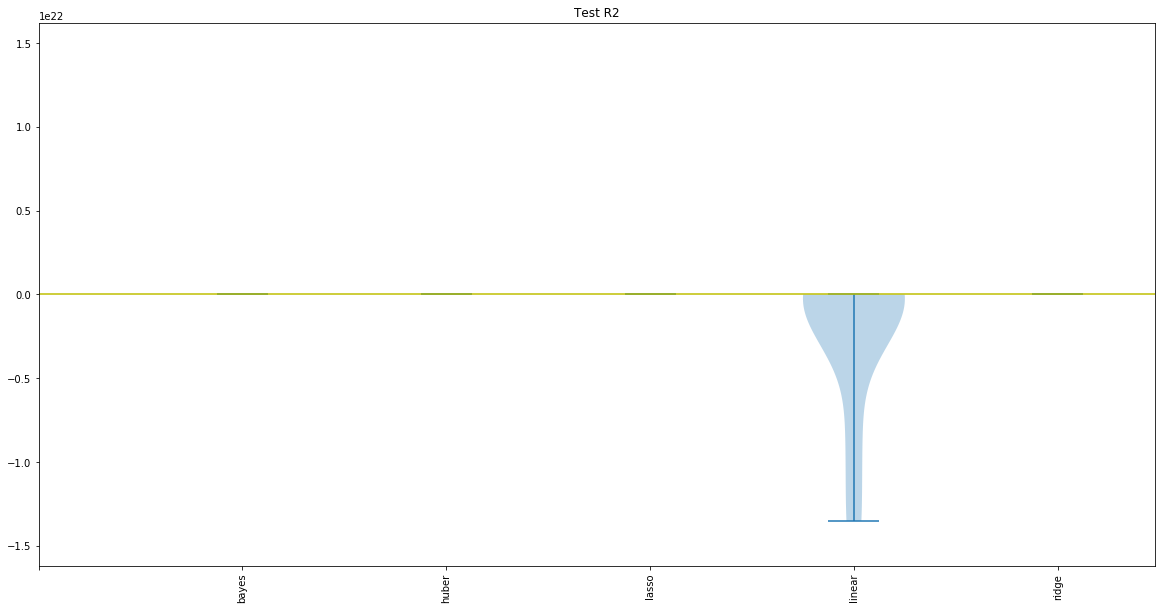

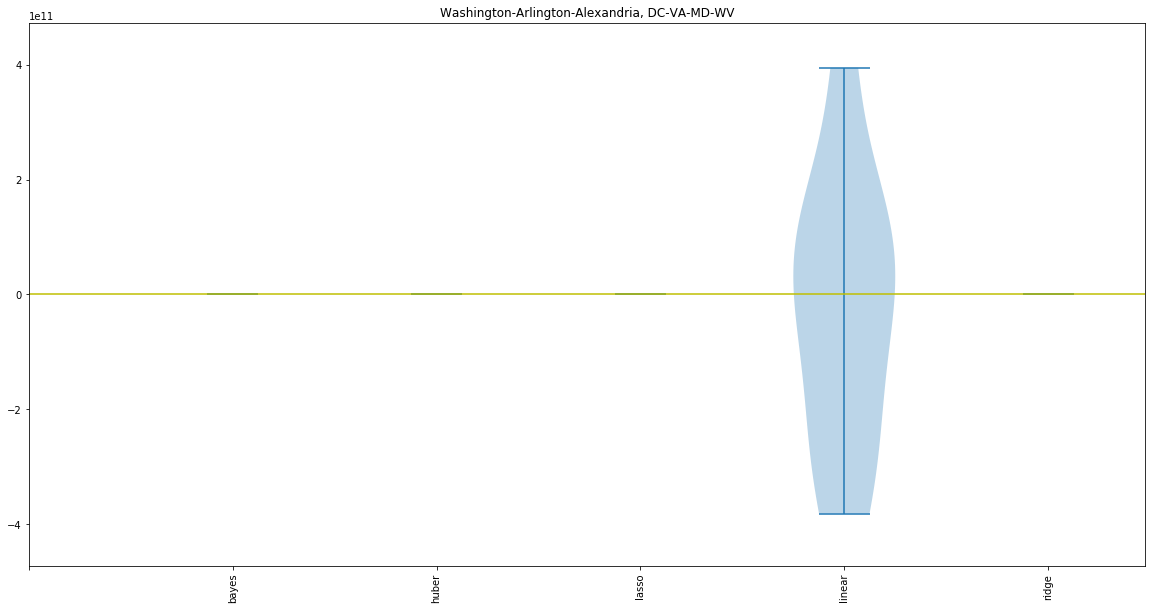

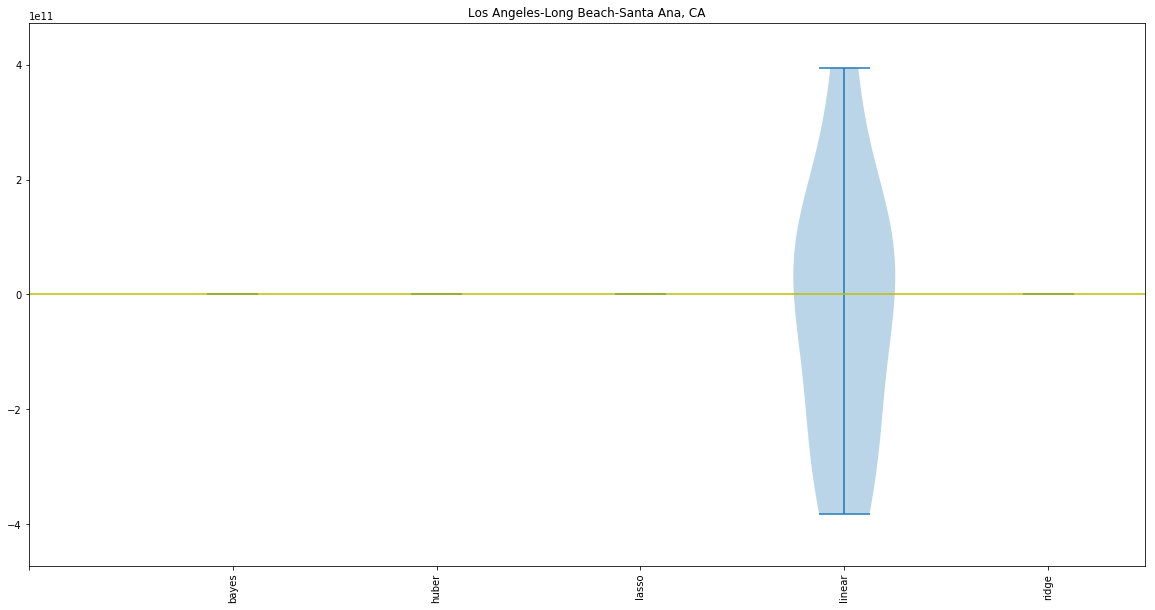

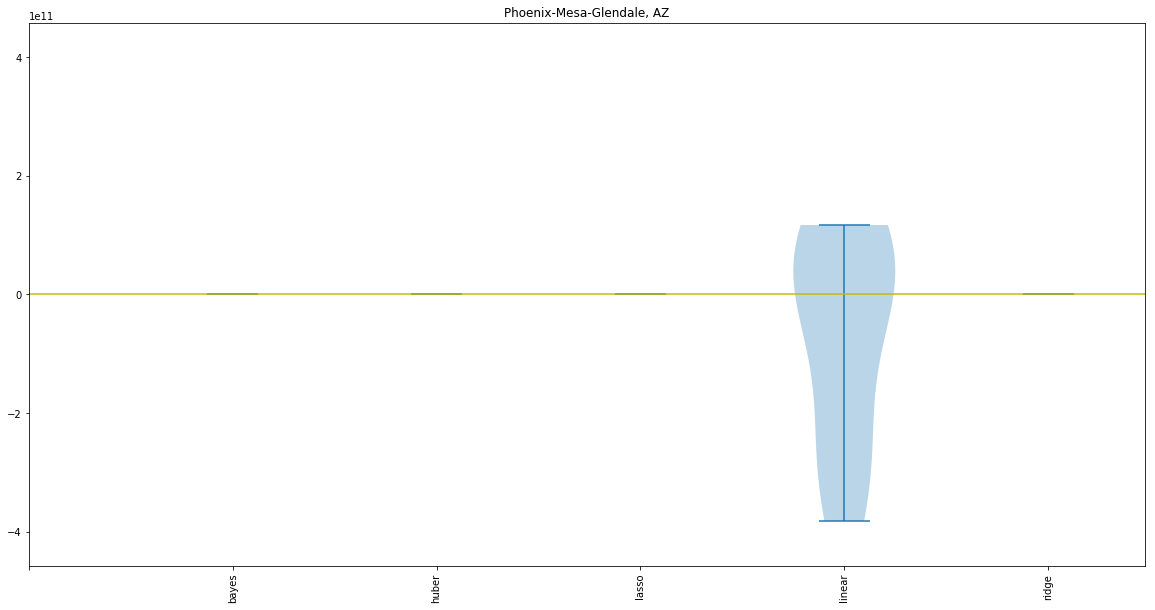

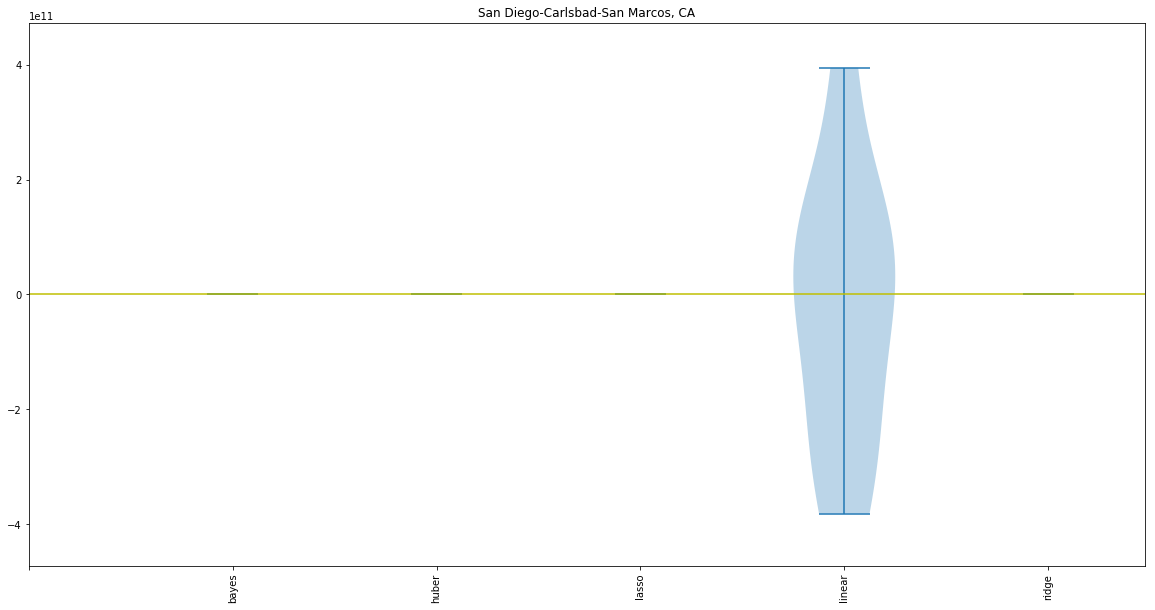

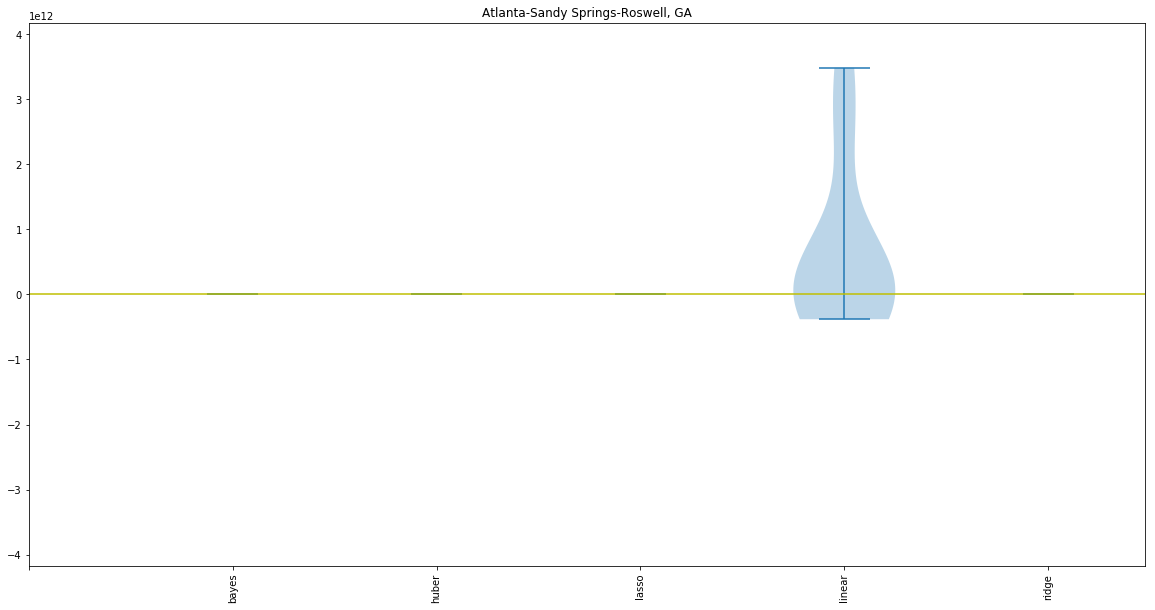

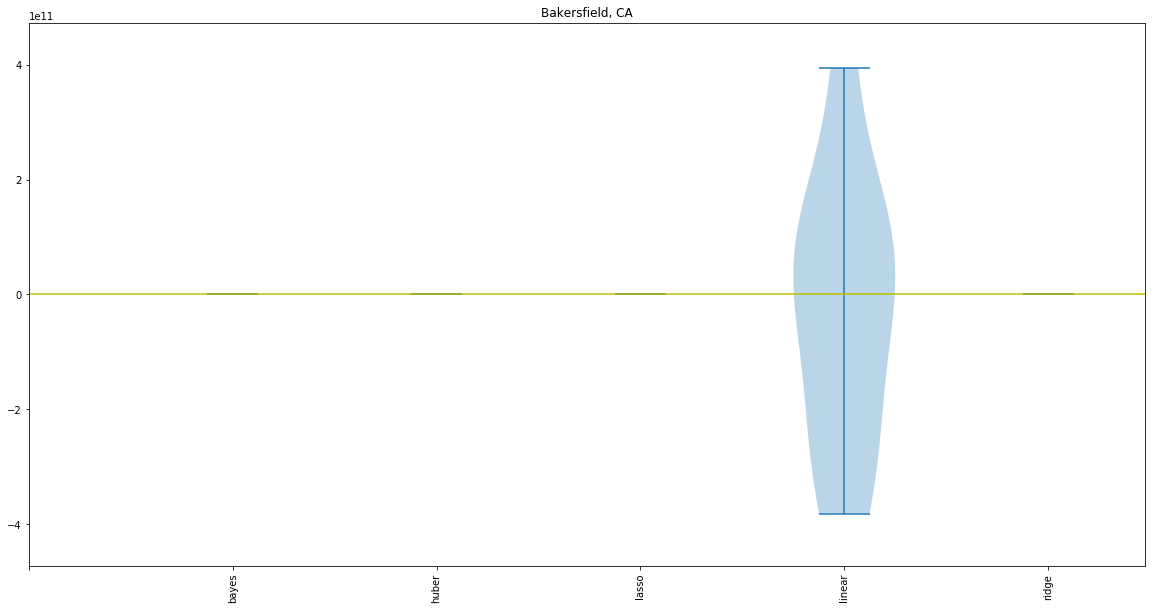

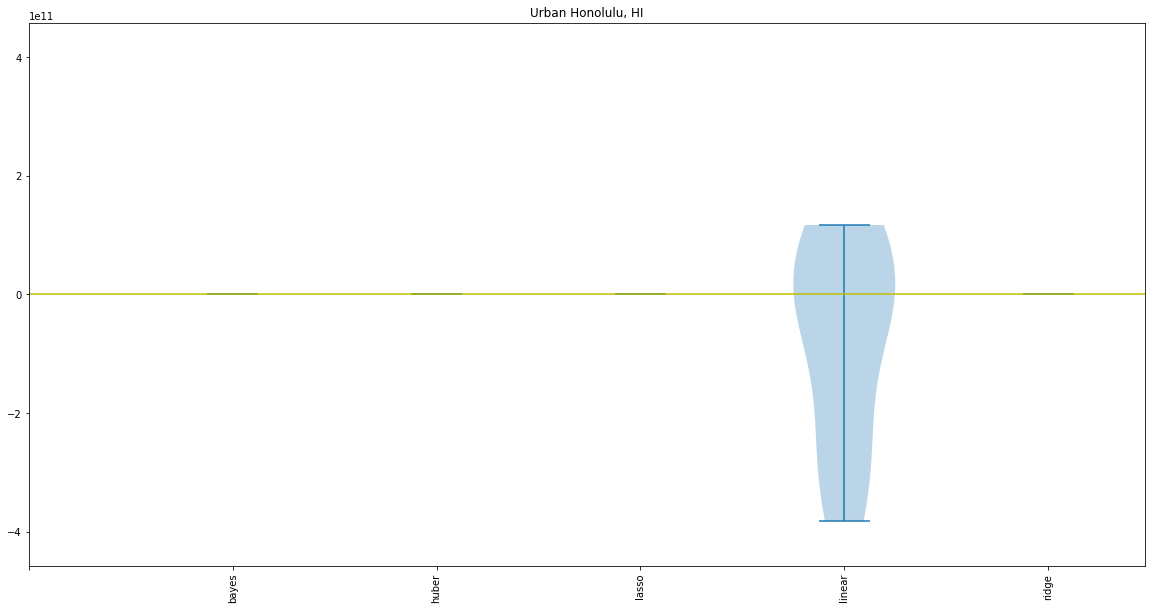

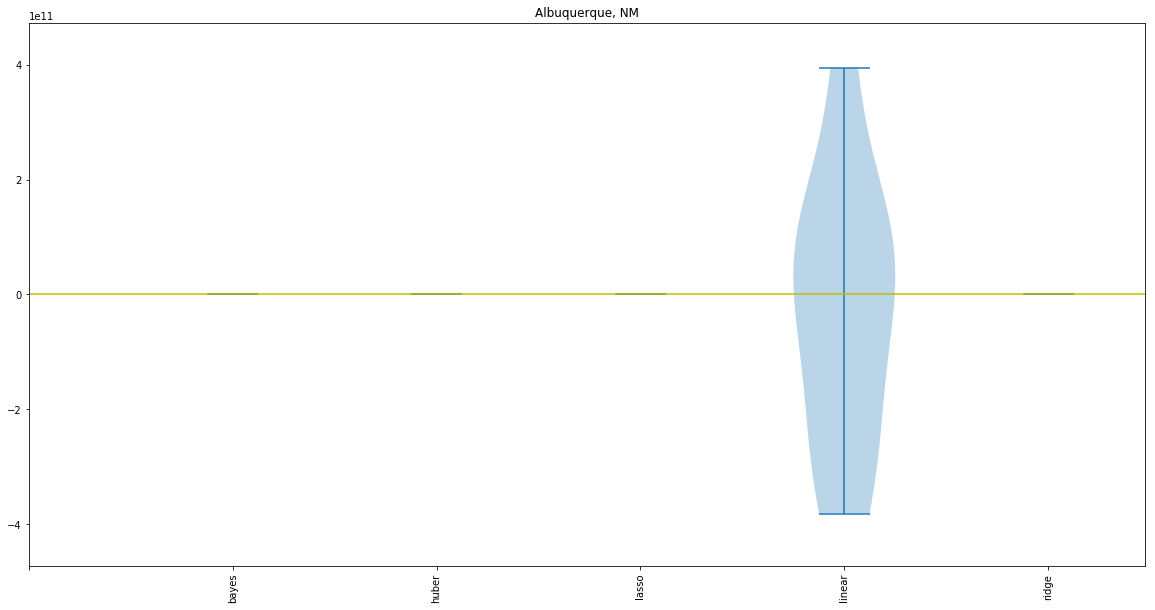

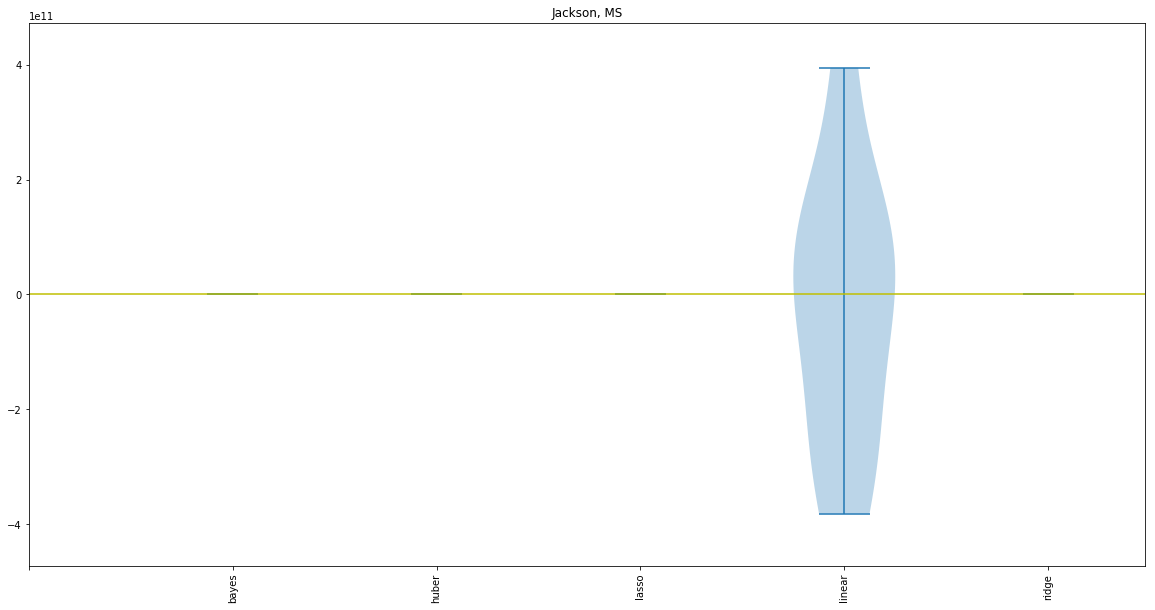

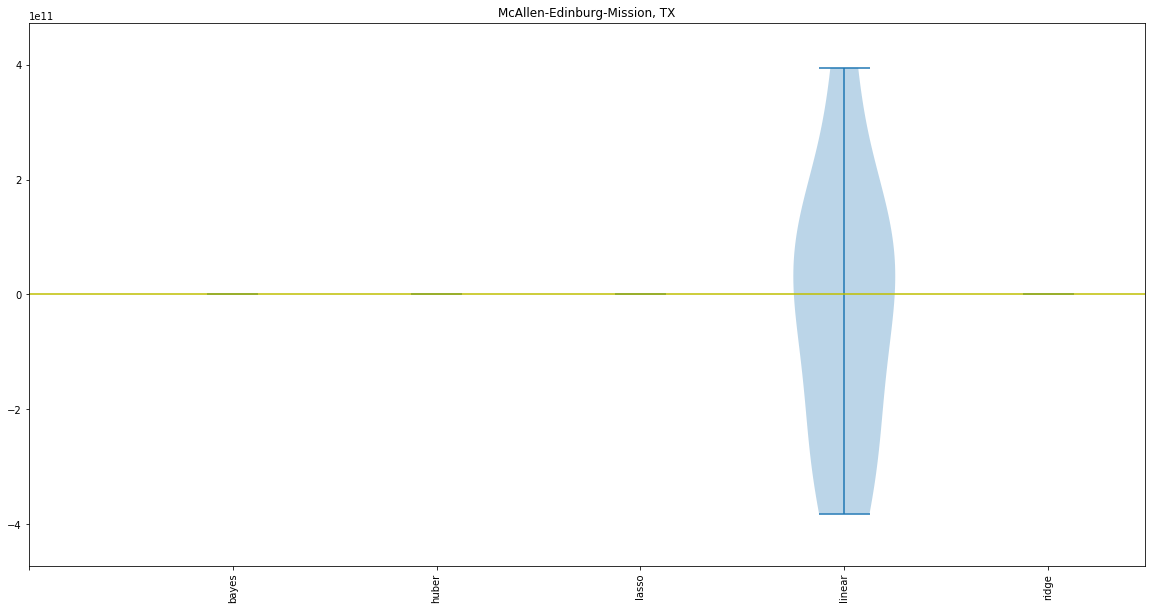

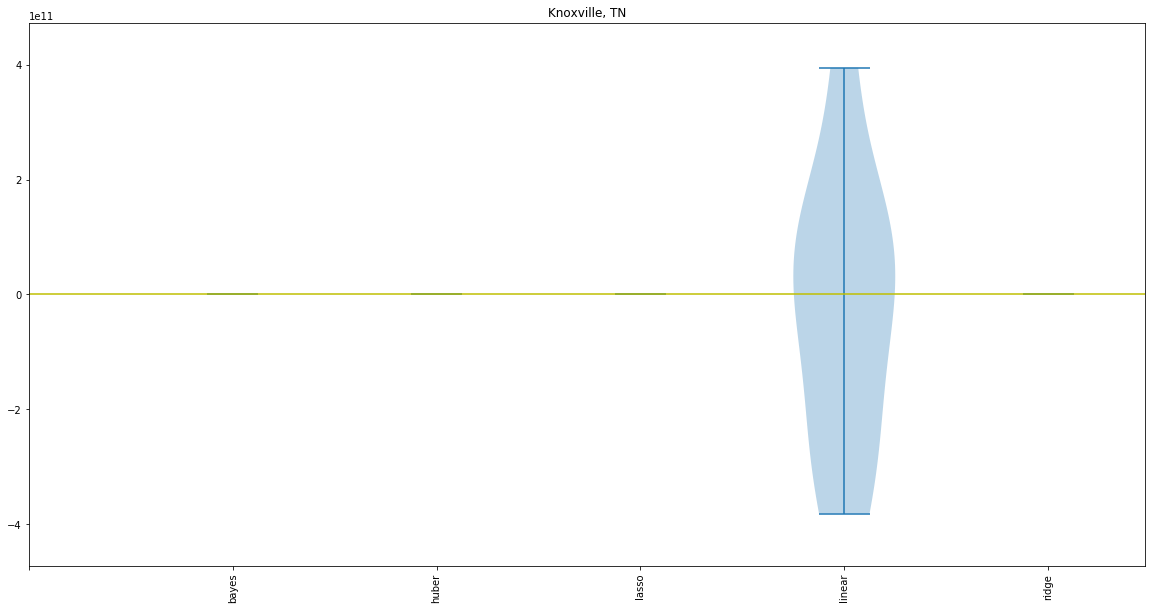

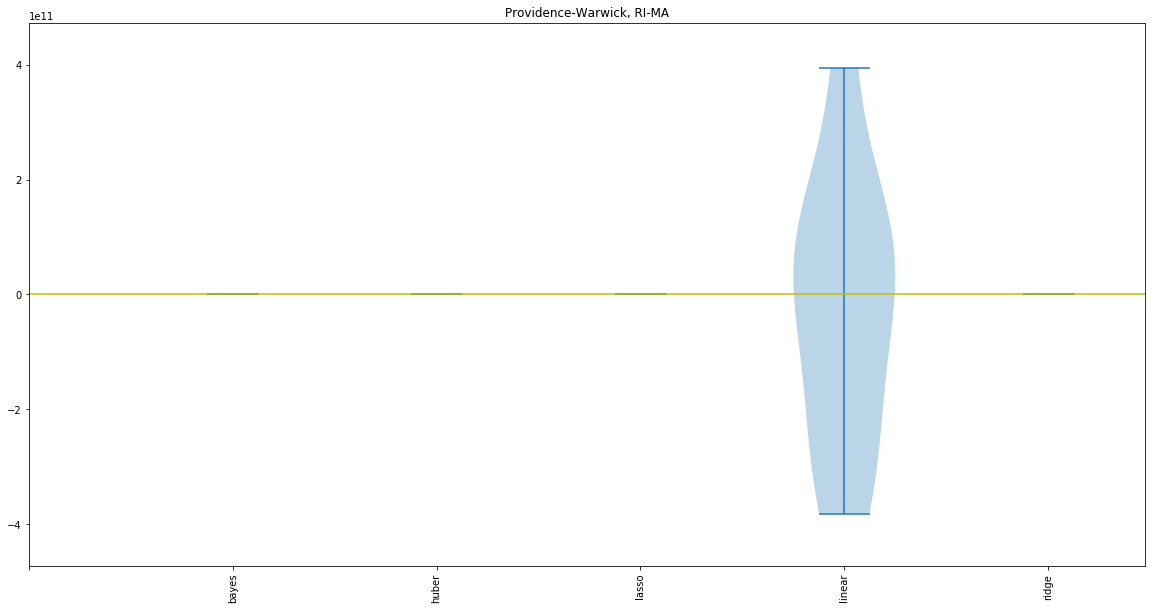

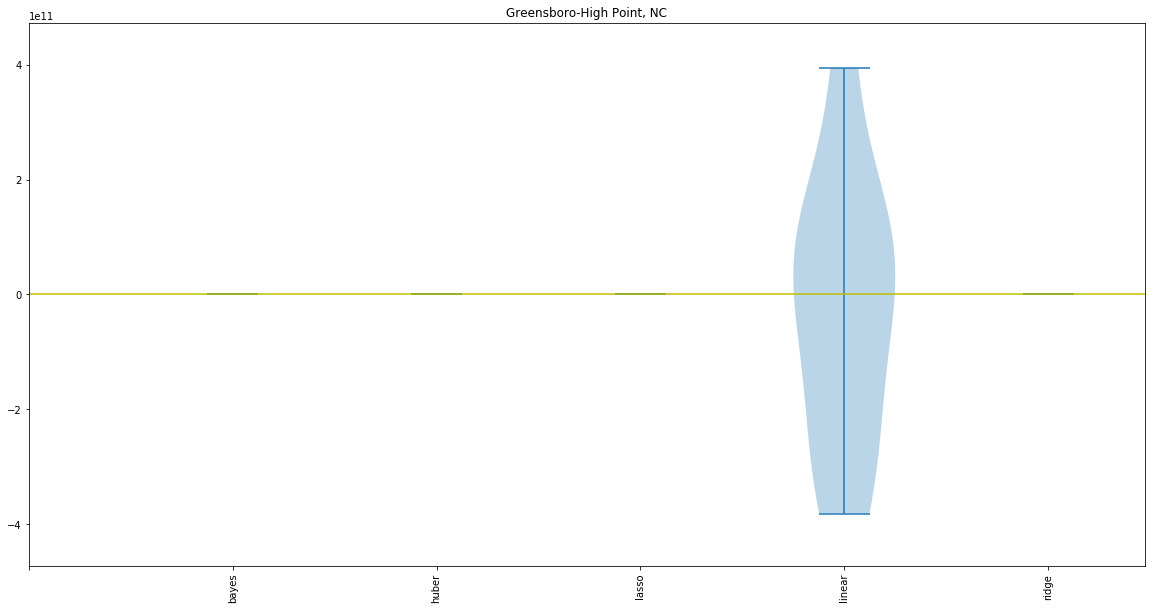

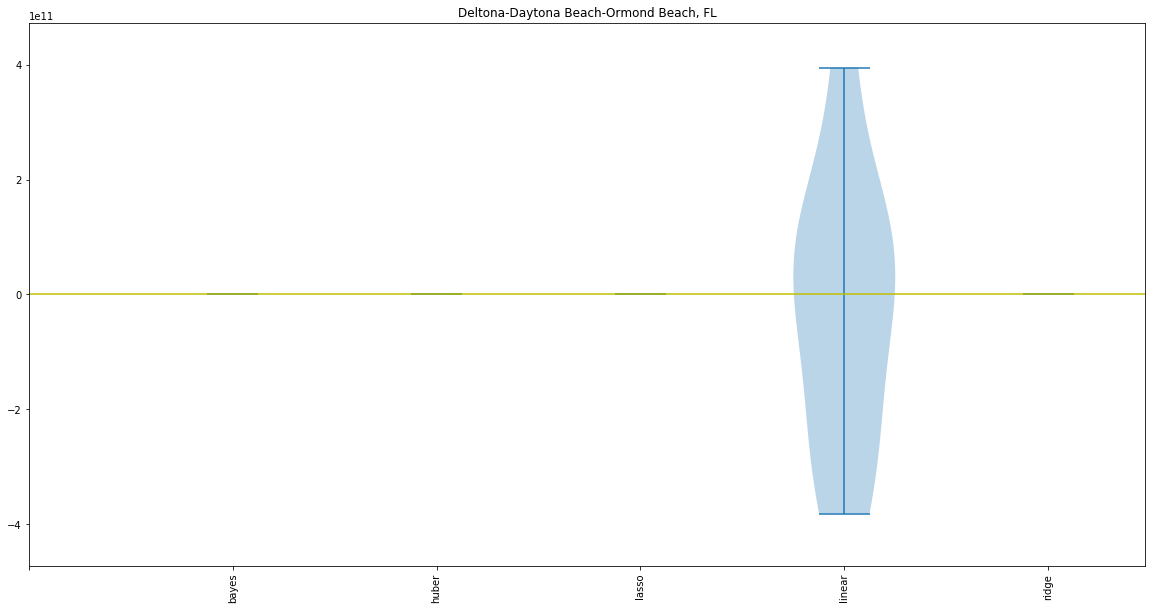

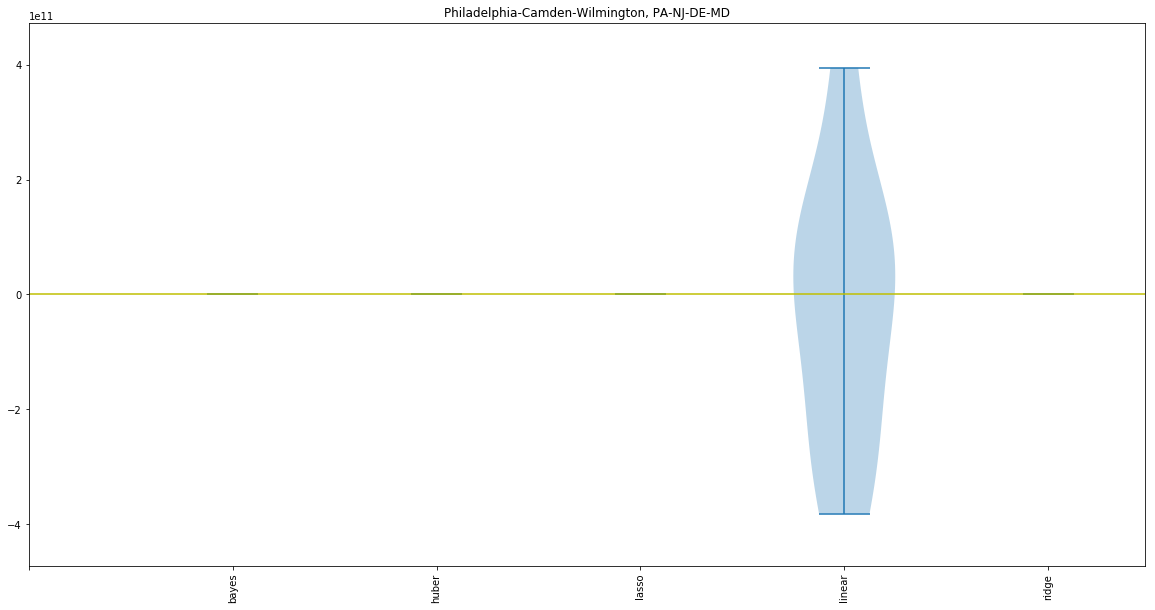

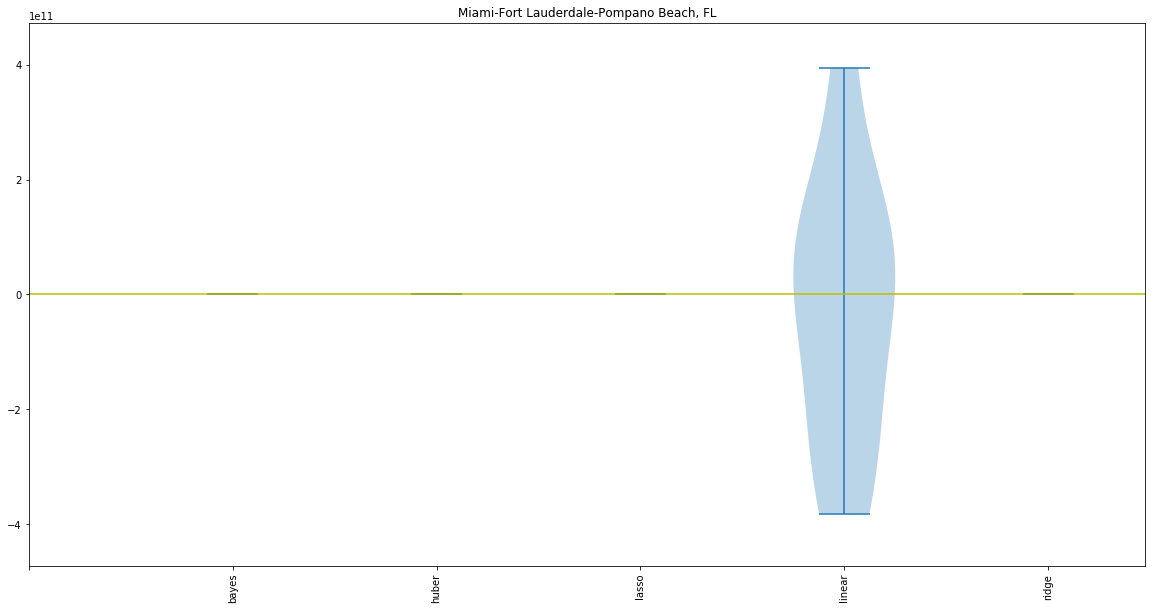

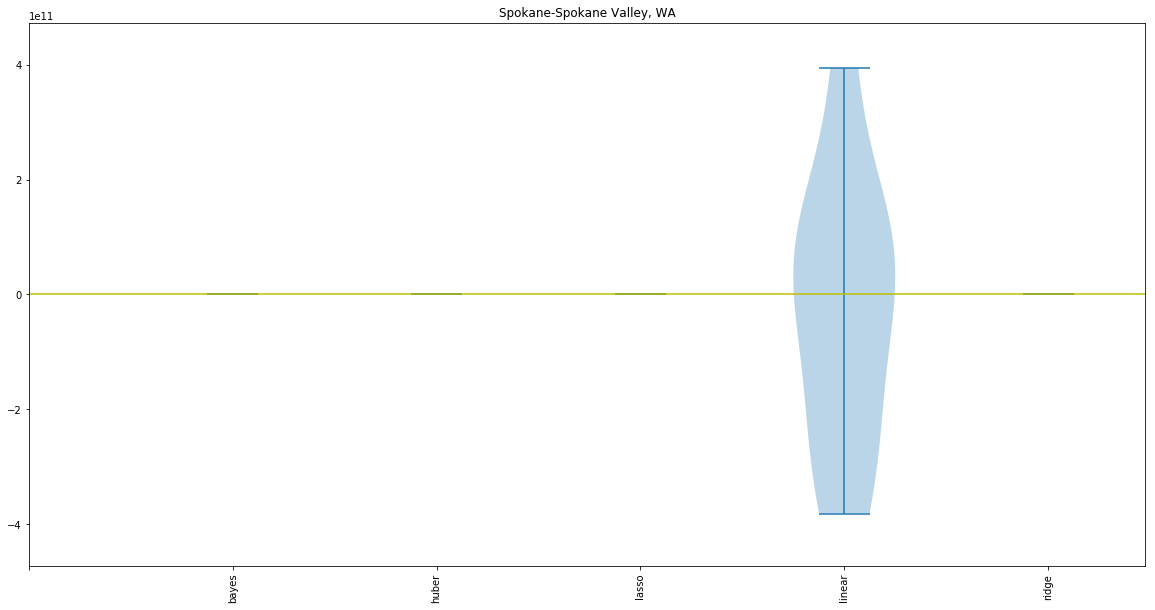

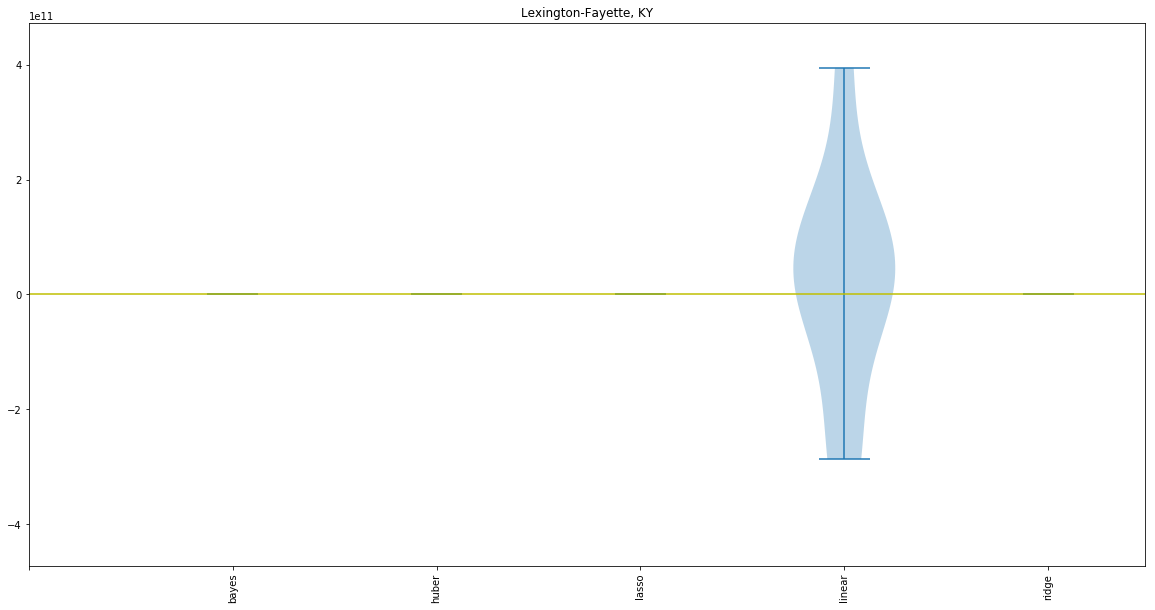

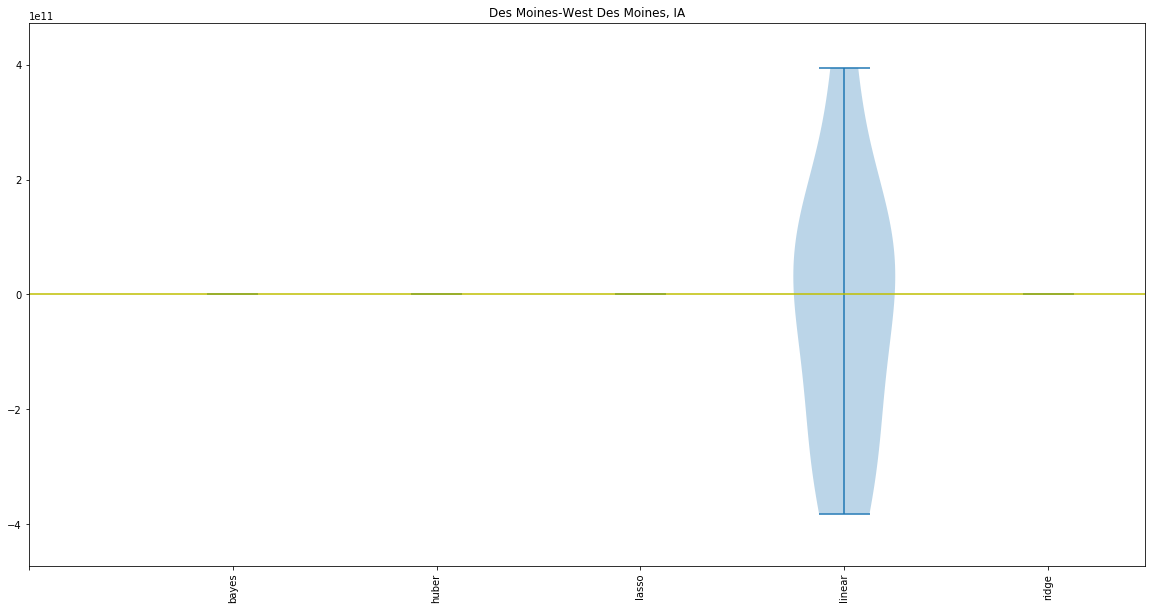

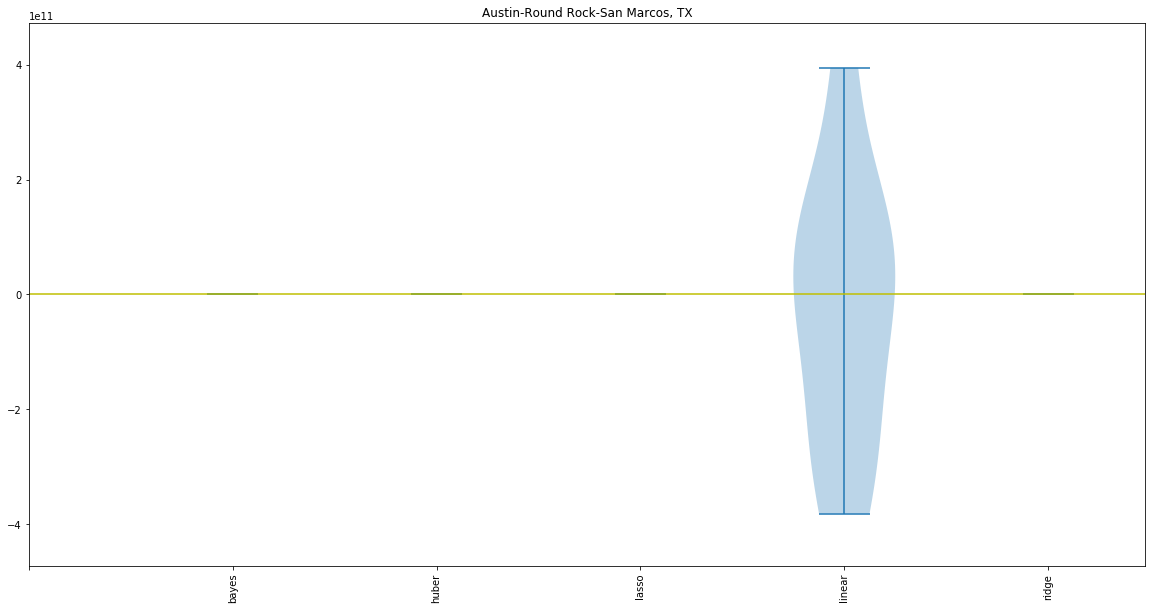

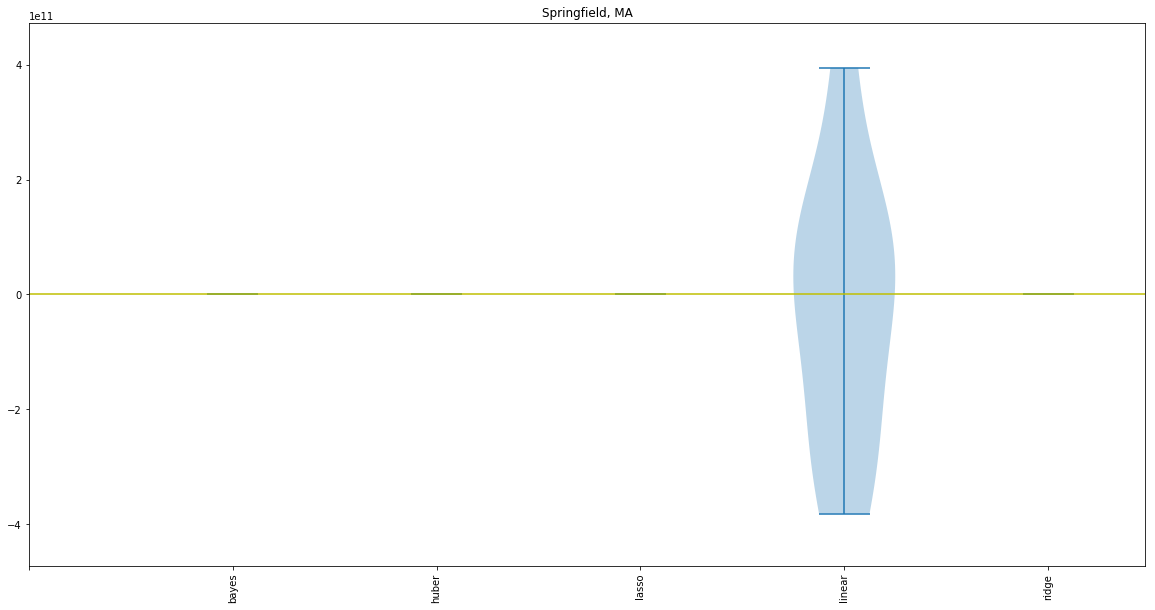

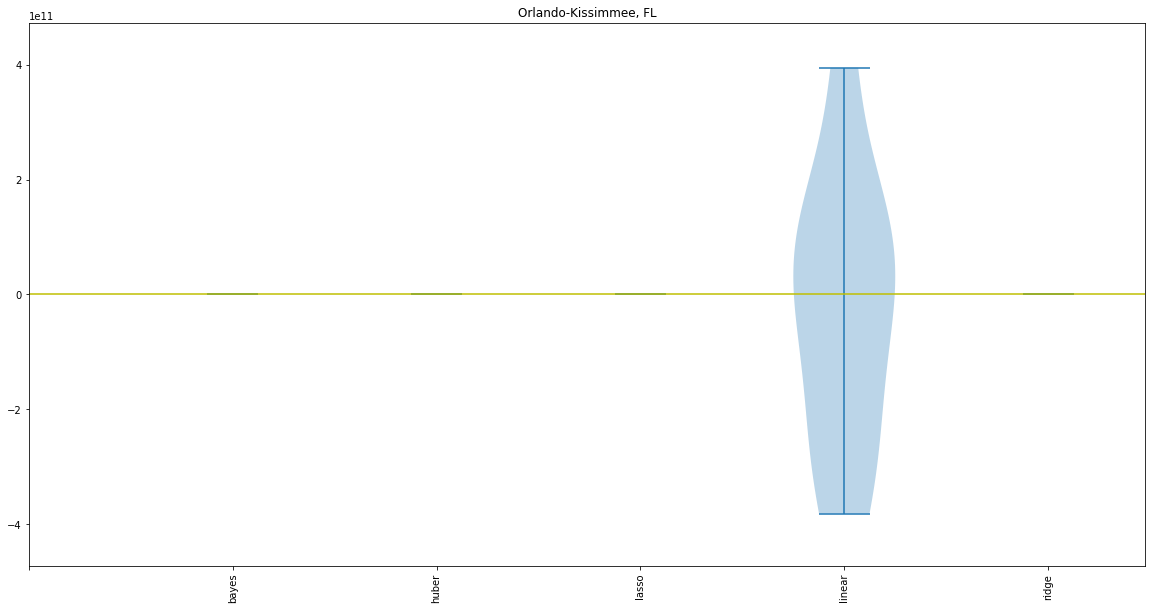

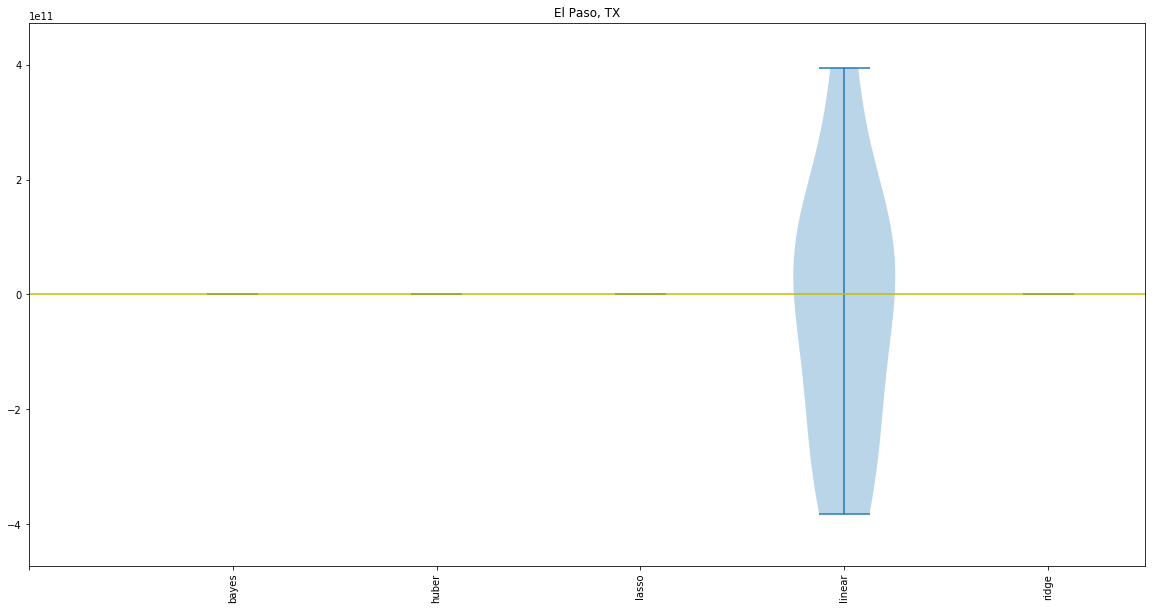

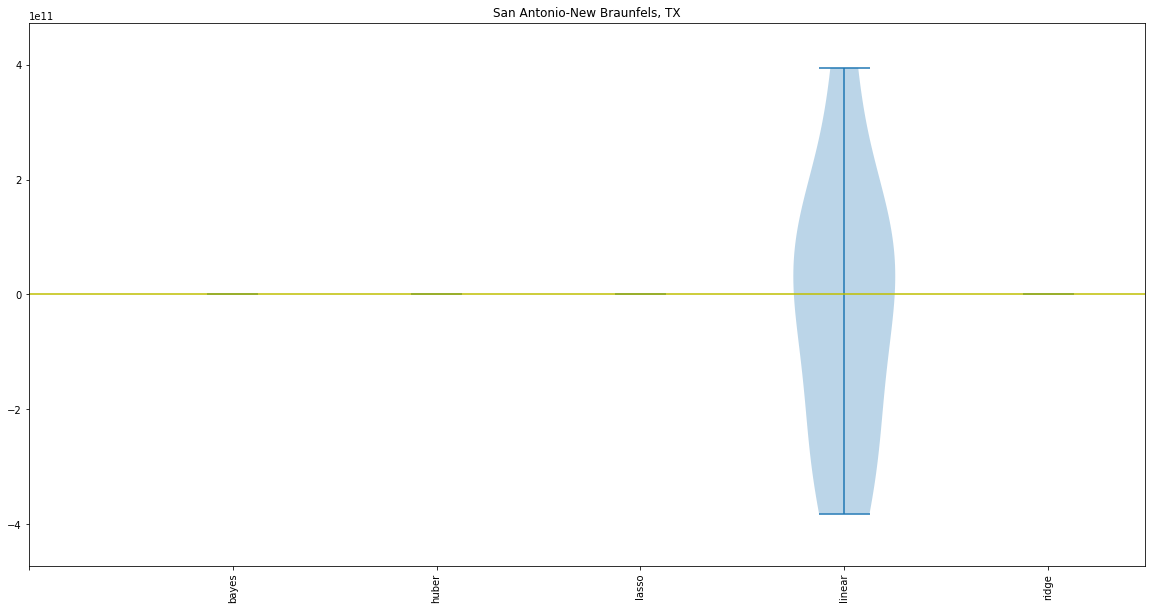

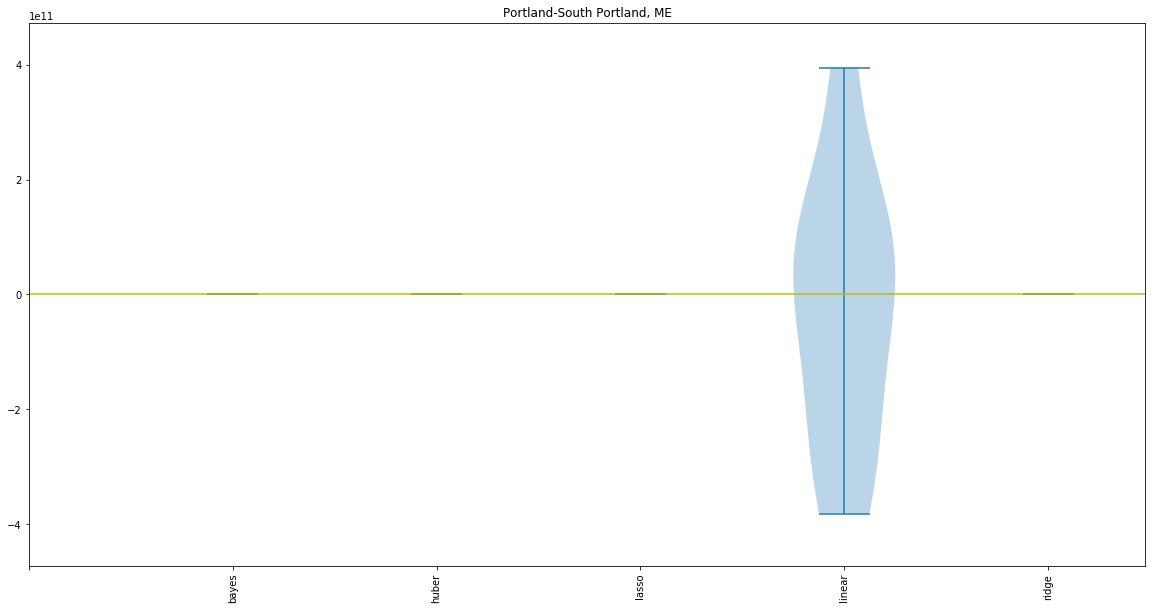

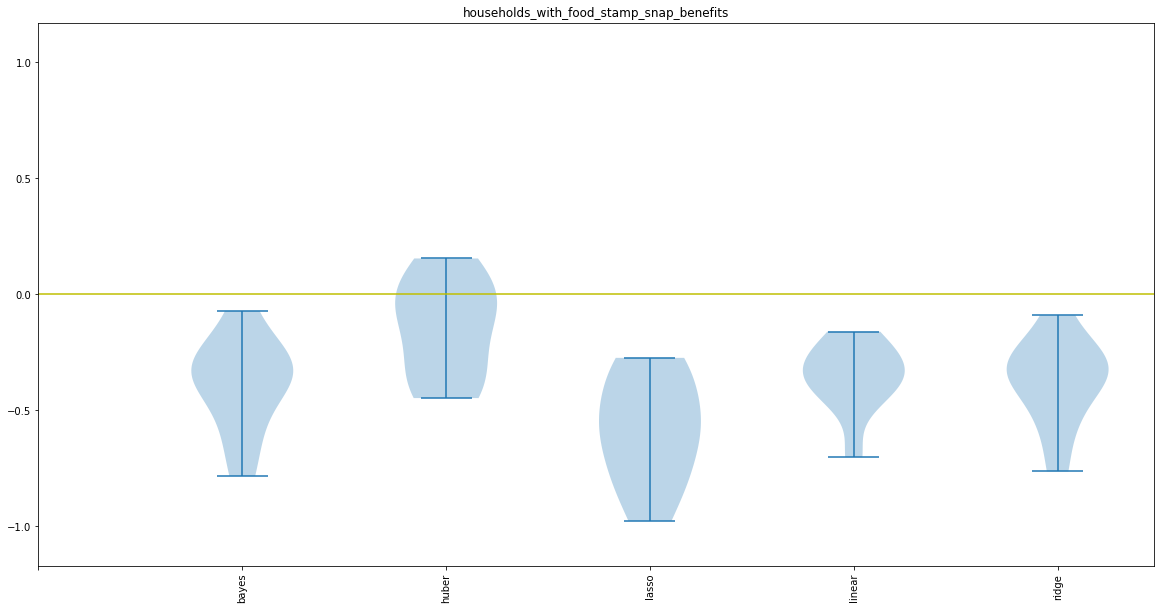

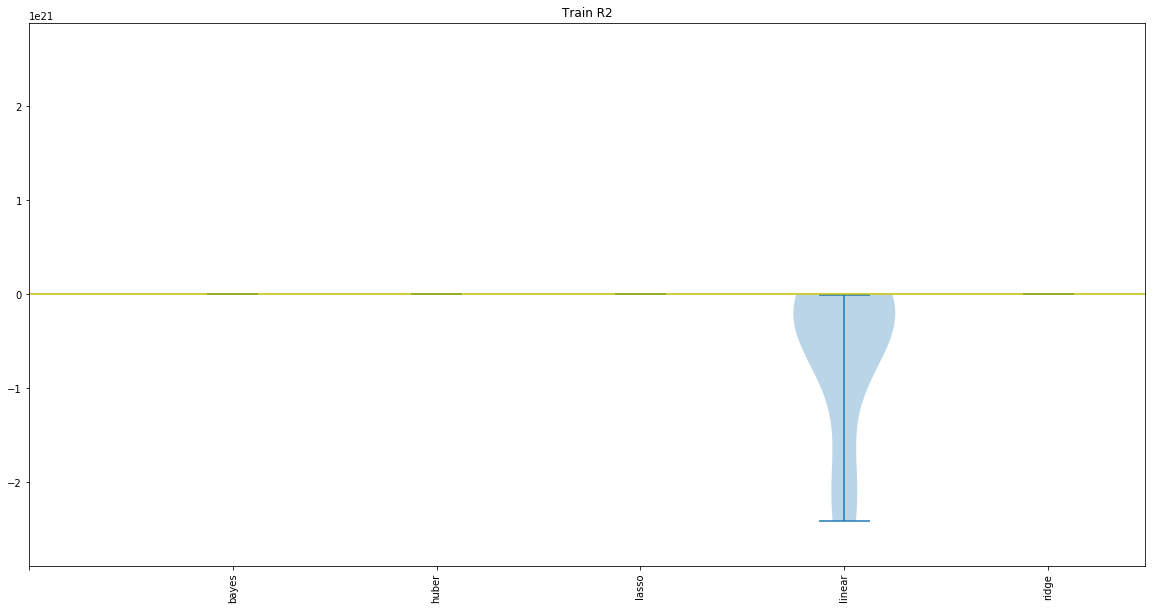

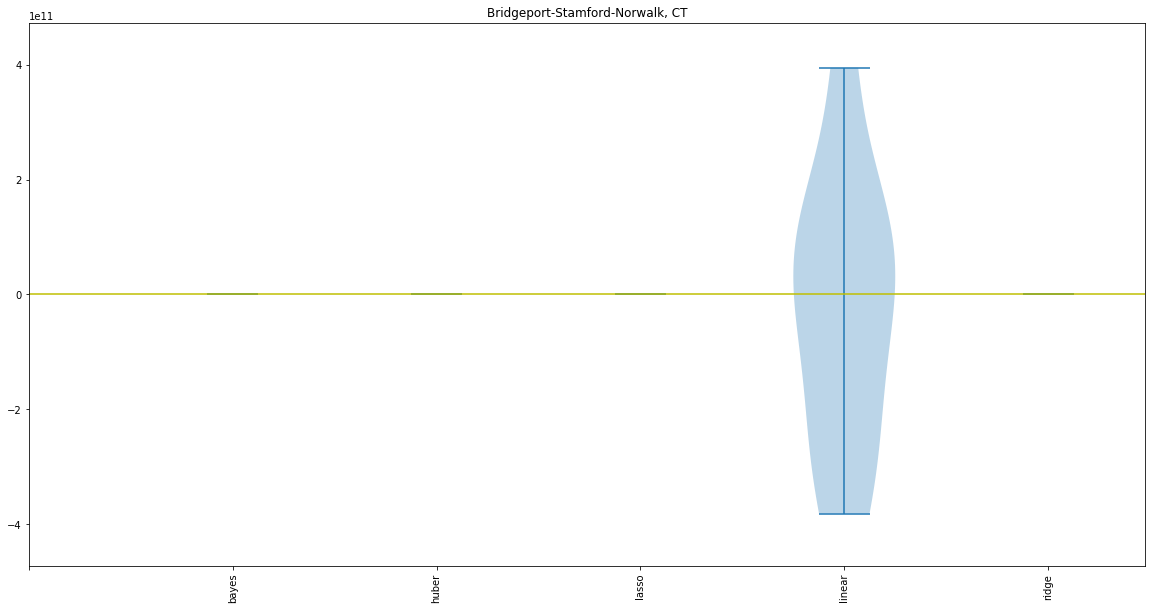

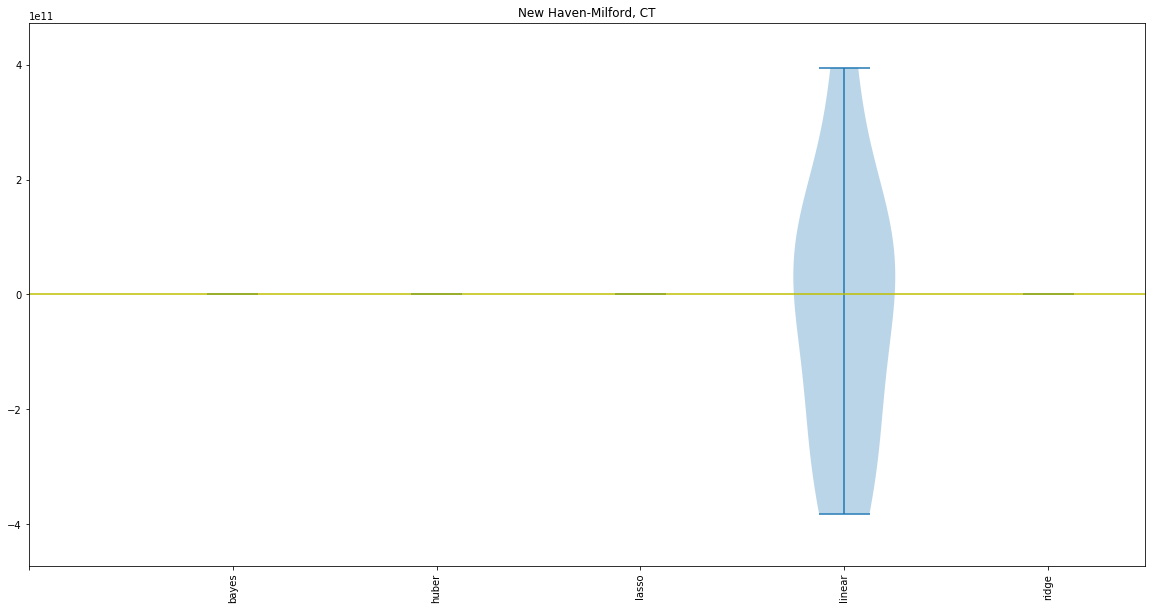

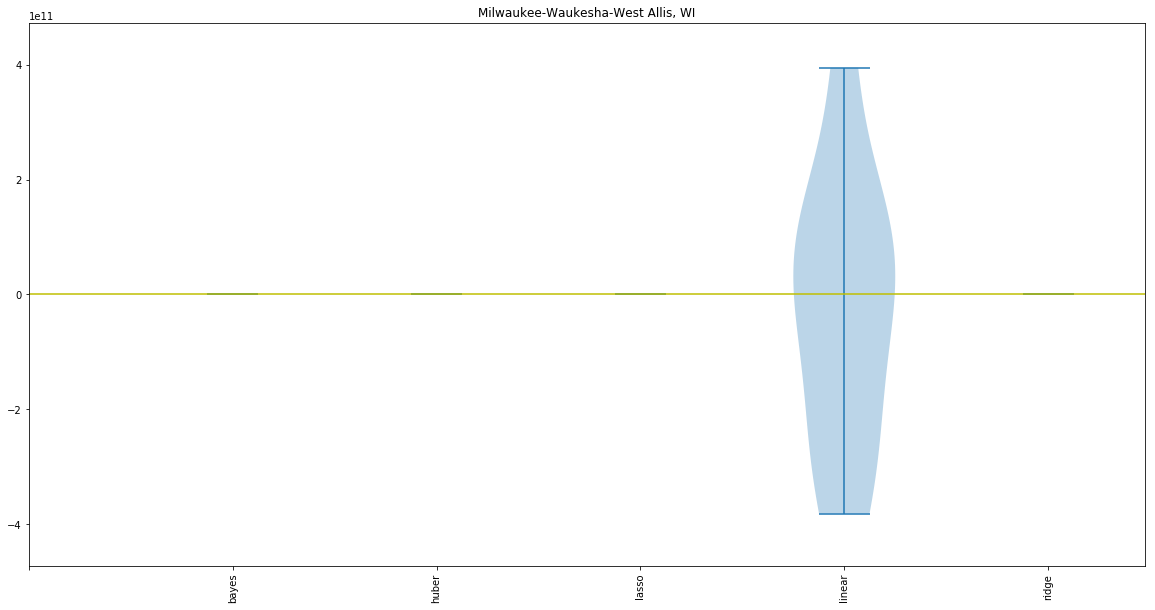

In [156]:
violin_coefs(exp_2)

In [166]:
for d in exp_2:
    print('\n'+d)
    print(' Mean: {:.4f}'.format(exp_2[d]['Test R2'].mean()))
    print(' Stdd: {:.4f}'.format(exp_2[d]['Test R2'].std()))
    print(' Min: {:.4f}'.format(exp_2[d]['Test R2'].min()))
    print(' Max: {:.4f}'.format(exp_2[d]['Test R2'].max()))


linear
 Mean: -2335979405585233215488.0000
 Stdd: 4635004127477124562944.0000
 Min: -13519358361822407163904.0000
 Max: -4318164118172976640.0000

ridge
 Mean: 0.7775
 Stdd: 0.0224
 Min: 0.7493
 Max: 0.8227

bayes
 Mean: 0.7765
 Stdd: 0.0219
 Min: 0.7495
 Max: 0.8201

lasso
 Mean: 0.7698
 Stdd: 0.0161
 Min: 0.7485
 Max: 0.7927

huber
 Mean: 0.7604
 Stdd: 0.0316
 Min: 0.7151
 Max: 0.8273
